##### PACKAGES IMPORT #####

In [6]:
# packages imports

import numpy as np
from sklearn.linear_model import LinearRegression

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize

from typing import Sequence, Union

import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from tqdm.notebook import tqdm

# import utils.metropolishastings as mh
# from utils.state import State
import random
import math as m
from math import pi, sqrt, exp, log
import seaborn as sns
import json
import ast

import os
print(os.getcwd())

from math import sqrt
from matplotlib.lines import Line2D

import time

import warnings
warnings.filterwarnings("ignore") 

c:\Users\artur\OneDrive\Desktop\EPFL\Thesis\Code


##### PARAMETERS #####

In [ ]:
# SIMULATION Parameters

initial_date = 2010
final_date = 2025
selected_sigma = .5 # sigma for the gaussian kernel used to smooth the birth rate
multiplier_factor = 1.75 
to_print = True
to_save = True
alternative_uk_mothers = True

experiment_number = 14
# experiment_name = 'experiment 14'

experiment_notes =  (f"same as experiment 11, changed the multiplier factor to {multiplier_factor} \n")

output_dir = f'experiments_results/experiment {experiment_number}'
os.makedirs(output_dir, exist_ok=True)

file_path = os.path.join(output_dir, f"experiment_notes_#{experiment_number}.txt")

with open(file_path, "w") as f:  # Use "a" to append instead of overwrite
    f.write("Experiment: " + str(experiment_number) + "\n" + 
            "Notes: " + experiment_notes + "\n")

data_switch = 1 # {0: test data, 1: census data}

##### LOAD & PROCESS (ETL) CENSUS DATA #####

In [8]:
# read_data() --> used to load sample data (my family :))

def read_data():
    persons_df = pd.read_csv('data/persons_time_indep.csv', delimiter=';')
    households_df = pd.read_csv('data/households_time_indep.csv', delimiter=';')
    memberships_df = pd.read_csv('data/memberships_time_indep.csv', delimiter=';')

    # households_df['members'] = households_df['members'].apply((lambda x: ast.literal_eval(x) if (pd.notnull(x) and x[0]=="[") else x))
    # households_df['members'] = households_df['members'].apply(lambda x: [int(i) for i in x])

    households_df.drop(columns=['ambito'], inplace=True)
    persons_df.drop(columns=['ambito'], inplace=True)

    # Set person_id as the index for persons_df
    persons_df.set_index('person_id', inplace=True)

    # Set household_id as the index for households_df
    households_df.set_index('household_id', inplace=True)

    # Set a unique index for memberships_df using a string concatenation of household_id + _ + person_id
    memberships_df['membership_id'] = memberships_df['person_id'].astype(str) + '_' + memberships_df['household_id'].astype(str)
    memberships_df.set_index('membership_id', inplace=True)

    # transform Nan values in hh column to None in all 3 dataframes for all columns
    memberships_df = memberships_df.where(pd.notnull(memberships_df), None)
    persons_df = persons_df.where(pd.notnull(persons_df), None)
    households_df = households_df.where(pd.notnull(households_df), None)	

    return persons_df, households_df, memberships_df


In [9]:
# Census data load & process function

def load_census(date):
    file_name = f'data/hh_rw_' + str(date) + '_ms.csv'

    temp = pd.read_csv(file_name, delimiter=',')
    temp.drop(columns=['hhweight', 'age_discrete', 'nind', 'total_num_licences'], inplace=True)

    temp.reset_index(inplace=True)
    temp.rename(columns={'hid': 'household_id', 'index': 'person_id', 'role':'ind_rank'}, inplace=True)

    temp['start_date'] = date - 1
    temp['end_date'] = 9999
    temp['leave_cause'] = None

    temp['driving_licence'] = temp['driving_licence'].replace({2: 0, 1: 1})
    temp['gender'] = temp['gender'].replace({1: 'M', 2: 'F'})

    # fix values in htype --> age of consent = 16 impossible to be a child if age gap with parent is < 16
    temp.sort_values(by=['household_id', 'age'], ascending=[True, False])

    # Calculate the age difference from the oldest member in each household
    temp['age_diff'] = temp.groupby('household_id')['age'].transform(lambda x: x.max() - x)

    # Calculate age difference from the oldest woman in the household
    temp['age_diff_woman'] = temp.groupby('household_id').apply(
        lambda x: x.loc[x['gender'] == 'F', 'age'].max() - x['age']).reset_index(level=0, drop=True)
    
    # single parent with children with size = 2 where the child has age diff < 16 --> set as couple
    temp.loc[temp['household_id'].isin(temp.loc[(temp['age_diff'] < 16) &
                                                (temp['ind_rank'] == 2) &
                                                (temp['hsize'] == 2) & 
                                                (temp['htype'] == 230), 'household_id'].unique()), 'htype'] = 210

    # single parent with children with size >2 where 1st child has age diff < 16 --> set as couple with children
    temp.loc[temp['household_id'].isin(temp.loc[(temp['age_diff'] < 16) &
                                                    (temp['ind_rank'] > 1) & 
                                                    (temp['hsize'] > 2) &
                                                    (temp['htype'] == 230), 'household_id'].unique()), 'htype'] = 220
     
    if to_print:
        print(f'\nAFTER FIXING SINGLE PARENTS:',temp['htype'].value_counts())

    # multi-gen if age_gap_woman > 46 or > 56 yo from oldest man --> new bracket "40" = 3-gen hh / complex situations
    temp['multi_gen'] = 0
    for htype_sel in [30, 220, 230]:
        temp.loc[temp.household_id.isin(temp.loc[(temp['age_diff_woman'] > 46) & 
                                            (temp['htype'] == htype_sel),'household_id'].unique()), ('htype','multi_gen')] = (40,1)
        temp.loc[temp.household_id.isin(temp.loc[(temp['age_diff'] > 56) & 
                                            (temp['htype'] == htype_sel),'household_id'].unique()), ('htype','multi_gen')] = (40,1)

    # filter htype 30 with only one generation (NO MEMBER with age gap >= 16) 
    # --> new bracket "31" = 2-gen hh (FALSE flatmates: flatmates with children?)
    temp['single_gen'] = 0
    not_one_gen = temp.loc[(temp['age_diff'] >= 16), 'household_id'].unique()
    temp.loc[(temp['htype'] == 30) & (temp['household_id'].isin(not_one_gen)), ('htype', 'single_gen')] = (31, 1)
    
    if to_print:
        print(f'\nWITH MULTI-GEN HH:',temp['htype'].value_counts())

    
    # drop complex situations (htype = 40 & 31) !!!!
    temp = temp.loc[~temp['htype'].isin([31, 40])]
    # - for others (htype = 31, 40) --> primary_hh = household_id + max(household_id) + 1
    #TO BE DONE --> EXPERIMENT: FIND BIGGEST GAPS BETWEEN AGE SORTED --> assuming htype 30 is 2-gen, htype 40 is 3-gen

    if to_print:
        print(f'\nAFTER FIXING MULTI-GEN HH:',temp['htype'].value_counts())


    # fix primary_hh
    # - for single and couple (htype = 10, 210, 30) --> primary_hh = household_id + max(household_id) + 1
    max_hh_id = temp['household_id'].max()

    temp.loc[(temp['htype'].isin([10,210,30])), 'primary_hh'] = temp['person_id'] + max_hh_id + 1
    temp.loc[(temp['htype'].isin([10,30])), 'role'] = 'single'
    temp.loc[(temp['htype'] == 210), 'role'] = 'partner'

    # - for couple & single with children (htype = 220, 230) -->  for parents: primary_hh = household_id + max(household_id) + 1
    #                                                             for children: primary_hh = current household_id
    temp.loc[(temp['htype'] == 220) & (temp['ind_rank'] > 2), 'primary_hh'] = temp['household_id']
    temp.loc[(temp['htype'] == 220) & (temp['ind_rank'] > 2), 'role'] = 'child'

    temp.loc[(temp['htype'] == 220) & (temp['ind_rank'] <= 2), 'primary_hh'] = temp['person_id'] + max_hh_id + 1
    temp.loc[(temp['htype'] == 220) & (temp['ind_rank'] <= 2), 'role'] = 'partner'

    temp.loc[(temp['htype'] == 230) & (temp['ind_rank'] > 1), 'primary_hh'] = temp['household_id']
    temp.loc[(temp['htype'] == 230) & (temp['ind_rank'] > 1), 'role'] = 'child'

    temp.loc[(temp['htype'] == 230) & (temp['ind_rank'] == 1), 'primary_hh'] = temp['person_id'] + max_hh_id + 1
    temp.loc[(temp['htype'] == 230) & (temp['ind_rank'] == 1), 'role'] = 'single'

    # temp['age_diff_int'] = temp['age_diff'].diff().fillna(0).astype(int)
    # temp['age_diff_int'] = temp['age_diff_int'].clip(lower=0)

    temp.loc[temp['age'] < 18, 'role'] = 'child' 
    temp.loc[temp['age'] < 18, 'primary_hh'] = temp['household_id']
    
    temp.loc[temp.role == 'child', 'marital_status'] = 1
    # For partners in hh with htype [210,220], and different marital_status between partners --> marital_status = 1 (not married)
    married_in_hh = temp.groupby('household_id')['marital_status'].apply(lambda x: (x == 2).sum())
    temp = temp.merge(married_in_hh.rename('married_in_hh'), on='household_id', how='left')
    temp.loc[(temp.htype.isin([210,220])) & (temp.married_in_hh == 1) & (temp.role == 'partner'), 'marital_status'] = 1

    temp['birth'] = date - temp['age']

    temp['membership_id'] = temp['person_id'].astype(str) + '_' + temp['household_id'].astype(str)
    temp.set_index('membership_id', inplace=True)

    # generate persons_df 
    temp_pers = temp[['person_id', 'birth', 'gender', 'primary_hh']]
    temp_pers['death'] = 9999
    temp_pers.set_index('person_id', inplace=True)

    # generate households_df
    temp_household = temp[['household_id', 'htype']].drop_duplicates().reset_index(drop=True)
    temp_household.drop(columns=['htype'], inplace=True)
    temp_household.set_index('household_id', inplace=True)
    temp_household['hh_start'] = date
    temp_household['hh_end'] = 9999
    temp_household['end_cause'] = None
        
    return temp_pers, temp_household, temp[['person_id', 'household_id', 'start_date', 'end_date',
                                             'role', 'leave_cause', 'marital_status']]

In [10]:
# GENERATE households, persons and memberships dataframes 

if data_switch == 0:
    # Import existing data
    persons_df , households_df, memberships_df = read_data()

else:
    persons_df, households_df, memberships_df = load_census(initial_date)
    temp = memberships_df.copy()



AFTER FIXING SINGLE PARENTS: htype
220    68600
210    38968
10     17397
230     9190
30      4752
Name: count, dtype: int64

WITH MULTI-GEN HH: htype
220    67727
210    38968
10     17397
230     9076
30      2043
31      1850
40      1846
Name: count, dtype: int64

AFTER FIXING MULTI-GEN HH: htype
220    67727
210    38968
10     17397
230     9076
30      2043
Name: count, dtype: int64


In [11]:
persons_df.head()

,birth,gender,primary_hh,death
person_id,,,,
0,1970,M,5717131.0,9999
1,1970,M,5717132.0,9999
2,1971,F,5717133.0,9999
3,1971,M,5717134.0,9999
4,2002,F,100004.0,9999


In [12]:
households_df.head()

,hh_start,hh_end,end_cause
household_id,,,
100002,2010,9999,None
620949,2010,9999,None
100004,2010,9999,None
100005,2010,9999,None
620952,2010,9999,None


In [13]:
memberships_df

,person_id,household_id,start_date,end_date,role,leave_cause,marital_status
membership_id,,,,,,,
0_100002,0,100002,2009,9999,single,None,1.0
1_620949,1,620949,2009,9999,single,None,1.0
2_100004,2,100004,2009,9999,partner,None,2.0
3_100004,3,100004,2009,9999,partner,None,2.0
4_100004,4,100004,2009,9999,child,None,1.0
...,...,...,...,...,...,...,...
138902_1041889,138902,1041889,2009,9999,partner,None,2.0
138903_520947,138903,520947,2009,9999,partner,None,2.0
138904_1041894,138904,1041894,2009,9999,partner,None,2.0


##### UTILS #####

In [14]:
# HOUSEHOLD MEMBERSHIP AND RELATIONSHIPS UTILS

# SUMMARY of FUNCTIONS:
# - `get_hh_memberships_t`(hh_id, date): Retrieves members of a household's memberships at a specific date.
# - `get_hh_members_ids_t`(hh_id, date): Retrieves IDs of household members at a specific date.
# - `get_hh_members_details_t`(hh_id, date): Gets time-indep info of household members at a specific date merging with persons_df.
# - `get_hhs_members_dict_t`(date): Creates a dictionary mapping all household_ids to their members' person_ids at a specific date.

# - `get_hh_children`(hh_id, date): Retrieves children of a household's memberships at a specific date.
# - `get_hh_children_ids`(hh_id, date): Retrieves IDs of children in a household at a specific date.
# - `get_hh_children_details`(hh_id, date): Retrieves detailed info of children in a household at a specific date.
# - `get_hhs_children_dict`(date): Creates a dictionary mapping all household_ids to their children members' person_ids at a specific date.

# - `get_pers_memberships`(pers_id): Retrieves all memberships of a person.
# - `get_pers_membership_t`(pers_id, date): Retrieves membership of a person at a specific date.
# - `get_pers_membership_id_t`(pers_id, date): Retrieves the membership ID of a person in a household at a specific date.
# - `get_pers_hh_id_t`(pers_id, date): Retrieves the household ID a person belongs to (membership active) at a specific date.
# - `get_pers_hh_memberships_t`(pers_id, date): Retrieves membership details of all members in a person's household at a specific date.
# - `get_pers_hh_members_ids_t`(pers_id, date): Retrieves IDs of all members in a person's household at a specific date.
# - `membership_id_str`(pers_id, household_id): Generates a membership ID string for a person in a household.

# - `is_membership_open`(membership_id): Checks if a membership is open-ended (active).
# - `is_pers_membership_open_t`(pers_id, date): Checks if a person's membership at a specific date is open-ended.
# - `is_pers_last_membership_t`(pers_id, date): Checks if a person's membership at a specific date is his last one (no future memberships).

# - `check_pers_membership_continuity`(pers_id): Checks if every membership row for a person has a start date that coincides with the previous membership's end date.
# - `check_membership_continuity`(): Checks if every membership row for all persons has a start date that coincides with the previous membership's end date.
# - `get_active_hhs_ids_t`(date): Retrieves the IDs of active households at a specific date.
# - `get_active_hhs_memberships_t`(date): Retrieves the memberships of active households at a specific date.

# - `get_htype_t`(hh_id, date): Determines the type of a household at a specific date based on its members' roles.
# - `get_htype_dict_t`(date): Creates a dictionary mapping all household_ids to their respective types at a specific date.

################# HOUSEHOLD MEMBERSHIP ###############

members_features = ['person_id', 'birth', 'gender', 'role', 'primary_hh']

def get_hh_memberships_t(memberships_df,household_id, date):
    """
    Returns the details of the members of a household at a certain date.
    """
    members = memberships_df.loc[(memberships_df['household_id'] == household_id) & 
                             (memberships_df['start_date'] <= date) & 
                             (memberships_df['end_date'] > date)]
    return members

def get_hh_members_ids_t(memberships_df, household_id, date):
    """
    Returns the ids of the members of a household at a certain date.
    """
    members = get_hh_memberships_t(memberships_df, household_id, date)
    return members['person_id'].values.tolist() if not members.empty else []

def get_hh_members_details_t(memberships_df, persons_df, household_id, date):
    """
    Returns the details of the members of a household at a certain date.
    """
    members = get_hh_memberships_t(memberships_df, household_id, date)
    members_details = members.merge(persons_df, on='person_id', how='inner')
    return members_details[members_features]

def get_hhs_members_dict_t(memberships_df, date):
    """
    Returns a dictionary with the households and their respective members from the households_df members column.
    """
    households_members_dict = {}
    for id in memberships_df.household_id.unique().tolist():
        households_members_dict[id] = get_hh_members_ids_t(memberships_df, id, date)
    return households_members_dict

def get_hh_children(memberships_df, household_id, date):
    """
    Returns the children of a household at a certain date.
    """
    current_hh = get_hh_memberships_t(memberships_df,household_id, date)
    children = current_hh[(current_hh['role'] == 'child')]
    return children

def get_hh_children_ids(memberships_df, household_id, date):
    """
    Returns the ids of the children of a household at a certain date.
    """
    children = get_hh_children(memberships_df, household_id, date)
    return children['person_id'].values.tolist()

def get_hh_children_details(memberships_df, persons_df, household_id, date):
    """
    Returns the details of the children of a household at a certain date.
    """
    children = get_hh_children(memberships_df, household_id, date)
    children_details = children.merge(persons_df, on='person_id', how='inner')
    return children_details[members_features]

def get_hhs_children_dict(memberships_df, date):
    """
    Returns a dictionary with the households and their respective children from the households_df children column.
    """
    households_children_dict = {}
    for id in memberships_df.household_id.unique().tolist():
        households_children_dict[id] = get_hh_children_ids(memberships_df, id, date)
    return households_children_dict

################# PERSON MEMBERSHIP ###############

def get_pers_memberships(memberships_df, person_id):
    """
    Returns the membership details of a person.
    """
    membership = memberships_df[memberships_df['person_id'] == person_id]
    return membership

def get_pers_membership_t(memberships_df, person_id, date):
    """
    Returns the membership details of a person at a certain date.
    """
    membership = memberships_df[(memberships_df['person_id'] == person_id) & 
                                (memberships_df['start_date'] <= date) & 
                                (memberships_df['end_date'] > date)]
    return membership

def get_pers_membership_id_t(memberships_df, person_id, date):
    """
    Returns the membership id of a person in a household.
    """
    membership = get_pers_membership_t(memberships_df, person_id, date)
    return membership.index.values[0]

def get_pers_hh_id_t(memberships_df, person_id, date):
    """
    Returns the household id of a person at a certain date.
    """
    membership = get_pers_membership_t(memberships_df, person_id, date)
    return int(membership['household_id'].values[0]) if not membership.empty else None

def get_pers_hh_memberships_t(memberships_df, person_id, date):
    """
    Returns the current membership of the persons belonging to the same household at a certain date.
    """
    current_hh_id = get_pers_hh_id_t(memberships_df, person_id, date)
    members  = get_hh_memberships_t(memberships_df, current_hh_id, date)
    return members

def get_pers_hh_members_ids_t(memberships_df, person_id, date):
    current_hh_id = get_pers_hh_id_t(memberships_df, person_id, date)
    hh_members_ids = get_hh_members_ids_t(memberships_df, current_hh_id, date)
    return hh_members_ids

def membership_id_str(person_id, household_id):
    """
    Returns the membership id of a person in a household.
    """
    return str(int(person_id)) + '_' + str(int(household_id))

############### OPEN END MEMBERSHIP ###############

def is_membership_open(memberships_df, membership_id):
    """
    Check if the membership of a person is open. 
    """
    return memberships_df.loc[membership_id, 'end_date'] == 9999

def is_pers_membership_open_t(memberships_df, person_id, date):
    """
    Check if the membership of a person is open at a certain date.
    """
    membership_id = get_pers_membership_id_t(memberships_df, person_id, date)
    return is_membership_open(memberships_df, membership_id)

def is_pers_last_membership_t(memberships_df, person_id, date):
    """
    Check if the person has no next membership.
    """
    # Get the current membership of the person
    current_membership = get_pers_membership_t(memberships_df, person_id, date)

    # Check if there are any future memberships for the person
    future_memberships = memberships_df[(memberships_df['person_id'] == person_id) & 
                                        (memberships_df['start_date'] > current_membership['start_date'].values[0])]
    return future_memberships.empty

############### CONTINUITY CHECKS ###############

def check_pers_membership_continuity(memberships_df, person_id):
    """
    Check if every membership row for a person has a start date that coincides with the previous membership's end date.
    """
    
    person_memberships = get_pers_memberships(memberships_df, person_id).sort_values(by='start_date')
    for i in range(1, len(person_memberships)):
        if person_memberships.iloc[i]['start_date'] != person_memberships.iloc[i - 1]['end_date']:
            return False
    return True

def check_membership_continuity(memberships_df):
    """
    Check if every membership row for a person has a start date that coincides with the previous membership's end date.
    """
    # Get all unique person_ids
    person_ids = memberships_df['person_id'].unique()
    
    # Check continuity for each person
    for person_id in person_ids:
        if not check_pers_membership_continuity(memberships_df, person_id):
            return False
    return True

############### ACTIVE MEMBERSHIP ###############

def get_active_hhs_ids_t(memberships_df, date):
    """
    Returns the ids of the active households at a certain date.
    """
    active_hhs = get_active_hhs_memberships_t(memberships_df, date)
    return active_hhs['household_id'].unique().tolist()

def get_active_hhs_memberships_t(memberships_df, date):
    """
    Returns the ids of the active (having at least 1 member) households at a certain date.
    """
    return memberships_df[(memberships_df['start_date'] <= date) & (memberships_df['end_date'] > date)]

def get_open_hhs_memberships(memberships_df):
    """
    Returns the ids of the open (active) households.
    """
    return memberships_df[memberships_df['end_date'] == 9999]

############### HH TYPE ###############

def get_htype_t(memberships_df, household_id, date):
    """
    Returns the type of the household at a certain date.
    """
    members = get_hh_memberships_t(memberships_df, household_id, date)

    if members.empty:
        return 'inactive'
        
    elif len(members) == 1:
        return 'single'

    else: 
        role_counts = members['role'].value_counts().unstack(fill_value=0)
        role_counts['size'] = role_counts.sum(axis=1)  # Add a column for the total size of each household

        # Define the conditions for each household type
        conditions = [
            (role_counts['partner'] == 2) & (role_counts['child'] == 0),
            (role_counts['single'] == 1) & (role_counts['child'] == 0),
            (role_counts['partner'] == 2) & (role_counts['child'] >= 1),
            (role_counts['single'] == 1) & (role_counts['child'] >= 1),
            (role_counts['single'] >= 2) & (role_counts['child'] == 0),
        ]
        # Define the corresponding household types
        household_types = [
            210, #'couple' 
            10, #'single' 
            220, #'couple with children'
            230, #'single with children'
            30, #'flatmates'
        ]

        # Apply the conditions to assign household types
        role_counts['derived_htype'] = np.select(conditions, household_types, default=40) #40: 'multi-gen or complex'
        return role_counts['derived_htype'].values[0]  # Return the household type of the first row
        
def get_htype_dict_t(memberships_df, date):
    """
    Returns a dictionary with the households and their respective types.
    """
    active_memberships = get_active_hhs_memberships_t(memberships_df, date)
    role_counts = active_memberships.groupby('household_id')['role'].value_counts().unstack(fill_value=0)
    role_counts['size'] = role_counts.sum(axis=1)  # Add a column for the total size of each household

    conditions = [
        (role_counts['partner'] == 2) & (role_counts['child'] == 0),
        (role_counts['single'] == 1) & (role_counts['child'] == 0),
        (role_counts['partner'] == 2) & (role_counts['child'] >= 1),
        (role_counts['single'] == 1) & (role_counts['child'] >= 1),
        (role_counts['single'] >= 2) & (role_counts['child'] == 0),
    ]

    household_types = [
        210, #'couple' 
        10, #'single' 
        220, #'couple with children'
        230, #'single with children'
        30, #'flatmates'
    ]

    # Apply the conditions to assign household types
    role_counts['derived_htype'] = np.select(conditions, household_types, default=40)
    role_counts = role_counts.reset_index().drop_duplicates()
    return dict(zip(role_counts['household_id'], role_counts['derived_htype']))


In [15]:
# rescale_array function to rescale probabilities after dropping indices (used for NEW_COUPLE)

def rescale_array(probs: np.ndarray, drop_indices: Union[Sequence[int], int]):
    """
    Given a 1D array of probabilities summing to 1, remove the entries
    at drop_indices and return a new array (length-len(drop_indices)) summing to 1.
    """
    probs = np.asarray(probs, dtype=float)
    total = probs.sum()
    if not np.isclose(total, 1.0):
        raise ValueError(f"Input array must sum to 1, but sums to {total}")

    # Normalize drop_indices to a list of unique ints
    if isinstance(drop_indices, int):
        drop_indices = [drop_indices]
    drop_indices = sorted({int(i) for i in drop_indices})
    if any(i < 0 or i >= probs.size for i in drop_indices):
        raise IndexError("One or more drop_indices out of range")

    # Build mask and apply
    mask = np.ones(probs.shape, dtype=bool)
    mask[drop_indices] = False
    remaining = probs[mask]

    # Rescale to sum to 1
    rem_sum = remaining.sum()
    if rem_sum <= 0:
        raise ValueError("No remaining probability mass after dropping")
    return (remaining / rem_sum)

In [16]:
# GET AVAILABLE ACTIONS function

def get_available_actions(memberships_df, persons_df, date, initial=False):
    active_memberships = get_active_hhs_memberships_t(memberships_df, date)

    # Group by household_id and count the number of each role
    role_counts = active_memberships.groupby('household_id')['role'].value_counts().unstack(fill_value=0)
    role_counts['size'] = role_counts.sum(axis=1)  # Add a column for the total size of each household

    # Define the conditions for each household type
    conditions = [
        (role_counts['partner'] == 2) & (role_counts['child'] == 0),
        (role_counts['single'] == 1) & (role_counts['child'] == 0),
        (role_counts['partner'] == 2) & (role_counts['child'] >= 1),
        (role_counts['single'] == 1) & (role_counts['child'] >= 1),
        (role_counts['single'] >= 2) & (role_counts['child'] == 0),
    ]
    # Define the corresponding household types
    household_types = [
        210, #'couple' 
        10, #'single' 
        220, #'couple with children'
        230, #'single with children'
        30, #'flatmates'
    ]

    # Apply the conditions to assign household types
    role_counts['derived_htype'] = np.select(conditions, household_types, default=40) #40: 'multi-gen or complex'
    
    actions = active_memberships.merge(role_counts, on='household_id', how='left').merge(persons_df, on='person_id', how='left')

    if initial:
        actions = actions[["person_id", "household_id", "birth", "gender", "primary_hh", "role",'marital_status',
                            "child","single","partner","size",'derived_htype']].rename(
                                columns={"derived_htype":"htype", "child":"children_in_hh", "single":"singles_in_hh",
                                          "partner":"partners_in_hh", "size":"hh_size"})
    else:
        actions = actions[["person_id", "household_id", "birth", "gender", "primary_hh", "role",'marital_status',
                           "child","single","partner","size",'derived_htype', 'marriage_date']].rename(
                               columns={"derived_htype":"htype", "child":"children_in_hh", "single":"singles_in_hh",
                                        "partner":"partners_in_hh", "size":"hh_size"})


    # Count the number of persons with marital_status == 2 (married) in each household
    married_in_hh = active_memberships.groupby('household_id')['marital_status'].apply(lambda x: (x == 2).sum())
    actions = actions.merge(married_in_hh.rename('married_in_hh'), on='household_id', how='left')

    actions['age'] = date - actions['birth']

    # transform everything to int, handling NaN values
    for col in ['primary_hh', 'hh_size', 'children_in_hh', 'singles_in_hh', 'partners_in_hh']:
        if col in actions.columns:
            actions[col] = actions[col].fillna(0).astype(int)

    # death always available
    actions['death_av'] = 1

    # Set defaults
    actions[['leave_av', 'birth_av', 'birth_unmarried_av',
              'new_couple_av', 'marriage_av', 'couple_split_av', 'divorce_av']] = 0

    # leave available for children > 18
    actions.loc[(actions['role'] == 'child') & (actions['age']>18), 'leave_av'] = 1

    # new couple available for singles > 18 (FOR NOW: no people with past marriages)
    actions.loc[(actions['role'] == 'single') & (actions['marital_status'] == 1) & (actions['age']>18), 'new_couple_av'] = 1

    # marriage available for partners in couple or couple with children (can't be alone)
    actions.loc[(actions['marital_status'] == 2) & (actions['role'] == 'partner') & (actions['partners_in_hh']==2), 'marriage_av'] = 1

    # divorce available for partners in couple or couple with children (can't be alone)
    actions.loc[(actions['marital_status'] == 2) & (actions['role'] == 'partner') & (actions['partners_in_hh']==2), 'divorce_av'] = 1

    # couple split available for partners in couple or couple with children (can't be alone)
    actions.loc[(actions['marital_status'] != 2) & (actions['role'] == 'partner') & (actions['partners_in_hh']==2), 'couple_split_av'] = 1

    # birth and birth for unmarried couples --> available for women in married or unmarried couples
    actions.loc[(actions['marital_status'] == 2) & (actions['role'] == 'partner') & (actions['gender']=='F'), 'birth_av'] = 1
    actions.loc[(actions['marital_status'] != 2) & (actions['role'] == 'partner') & (actions['gender']=='F'), 'birth_unmarried_av'] = 1

    return actions

##### CENSUS MARRIAGE DATE ESTIMATION #####

In [17]:
########### PAVEL - INITIAL DATASET MARRIAGE YEAR ###########

# BAYESIAN FORMULA: 
#                                                        (1)                             (2)
#                                          P(Active(t0)|Start(t),yob_M,yob_F) * P(Start(t)|yob_M,yob_F)  
# P(Start(t)|Active(t0),yob_M,yob_F) = ---------------------------------------------------------------------
#                                      SUM(t')[P(Active(t0)|Start(t),yob_M,yob_F) * P(Start(t)|yob_M,yob_F)] 
#                                                        (3)                             (4)

### COMPUTATIONS ###
# (1) and (3): Prob of marriage still active at t0 given the start of marriage at time t and the YOBs of husband and wife


# Use Survival Model: 
# Assumption --> simplify conditional: only take duration into account (assume independence from YOBs of partners)
# P(Active(t0)|Start(t),yob_M,yob_F) --> P(Active(t0)|Start(t)) = S(t0 - t) = survival function at time t0 - t
# P(Active(t0)|Start(t)) = exp(-lambda * (t0 - t)) 

# get lambda from data --> mean of exponential distribution = 1/lambda --> lambda = 1/(mean(marriage_duration))


#                                       (A)                                     (B)   
#                             marriages ending in divorce                                                   
# mean(marriage_duration) = -------------------------------- * (mean(duration(marriages_ending_divorce)))  + 
#                                   total marriages 
#                     
#                                       (C)                                     (D)
#                               marriages ending in death
#                           + ----------------------------- * (mean(duration(marriages_ending_death)))
#                                   total marriages


# A) available
# B) available
# C) derive from: 1-A 
# D) derive from: life expectancy - mean(age @ marriage)


# (2) and (4): probability of marriage starting at time t given the YOBs of husband and wife

def mean_truncated_geometric(tm, tw, p, t0):
    """
    Compute E[T_u] for a geometric(pi=p) truncated to t ∈ [tmin, t0], where
      tmin = max(tm + 18, tw + 18)
      tmax = t0

    The (unconditional) Geometric(X; p) is defined on X = number of failures 
    before first success, taking values X=0,1,2,... with P(X=k) = q^k p, q=1-p.
    Then T = tmin + X, truncated so that X <= N where N = tmax - tmin.

    This function returns that E[T].
    """
    tmin = max(tm + 18, tw + 18)
    tmax = t0
    if tmin > tmax:
        raise ValueError(f"Invalid: tmin={tmin} > t0={t0}.")

    q = 1.0 - p
    N = tmax - tmin
    qN1 = q ** (N + 1)
    denom = 1.0 - qN1
    # numerator = 1 − (N+1)q^N + N q^(N+1)
    numerator = 1.0 - (N + 1) * (q ** N) + N * (q ** (N + 1))
    # E[X | X ≤ N] = numerator / [p * (1 − q^(N+1))]
    EX_trunc = numerator / (p * denom)
    return tmin + EX_trunc



####### Calibrate p so that E[T_u] = mean_obs ##########

def calibrate_p(tm, tw, t0, mean_obs, tol=1e-8, max_iter=100):
    """
    Find p ∈ (0,1) such that mean_truncated_geometric(tm, tw, p, t0) == mean_obs,
    via bisection.

    Raises if mean_obs is not in [tmin, (tmin+t0)/2] approximately.
    """
    tmin = max(tm + 18, tw + 18)
    if not (tmin <= mean_obs):
        raise ValueError(
            f"mean_obs={mean_obs} is outside feasible range [{tmin}, {t0}]."
        )

    # p_low → 1 − p very close to 1: The truncated‐geo mean → (tmin+t0)/2 
    # as p→0. So at p_low, mean > mean_obs if mean_obs < (tmin+t0)/2.
    # at p_high → 1, mean → tmin.
    p_low, p_high = 1e-12, 1.0 - 1e-12

    f_low  = mean_truncated_geometric(tm, tw, p_low,  t0) - mean_obs
    f_high = mean_truncated_geometric(tm, tw, p_high, t0) - mean_obs

    # Instead of raising, clamp mean_obs to feasible range if needed
    tmin = max(tm + 18, tw + 18)

    ######################################################################
    #########################  CORRECTED HERE  ###########################
    ######################################################################
    
    if f_low < 0:
        # mean_obs is too high, set p to minimum possible (mean ≈ (tmin + t0)/2)
        return p_low
    if f_high > 0:
        # mean_obs is too low, set p to maximum possible (mean ≈ tmin)
        return p_high

    #######################################################################


    for _ in range(max_iter):
        p_mid = 0.5 * (p_low + p_high)
        f_mid = mean_truncated_geometric(tm, tw, p_mid, t0) - mean_obs

        if abs(f_mid) < tol:
            return p_mid
        if f_mid > 0:
            # mean_trunc(p_mid) > mean_obs → need larger p to reduce mean
            p_low = p_mid
        else:
            # mean_trunc(p_mid) < mean_obs → need smaller p to increase mean
            p_high = p_mid

    return 0.5 * (p_low + p_high)


# ──────────────────────────────────────────────────────────────────────────────
# 3. Build the prior PMF P(tu = t | tm, tw) on t = tmin..t0
# ──────────────────────────────────────────────────────────────────────────────

def pmf_prior_tuple(tm, tw, p, t0):
    """
    Returns two arrays:
      t_values = [tmin, tmin+1, ..., t0]
      prior_pmf = truncated geometric PMF at those t's with parameter p.
    """
    tmin = max(tm + 18, tw + 18)
    tmax = t0
    if tmin > tmax:
        return np.array([]), np.array([])

    q = 1.0 - p
    t_values = np.arange(tmin, tmax + 1)
    exponents = t_values - tmin  # these go 0,1,2,...,N
    unnorm = (q ** exponents) * p
    denom = 1.0 - q ** (tmax - tmin + 1)
    pmf = unnorm / denom
    return t_values, pmf


# posterior: P(tu | still‐married at t0, tm, tw) 
# we simplify the conditional by only taking into account the lenght of the marriage to optain: 
# posterior ∝ exp(−λ⋅(t0−t)) ⋅ prior(t)

def posterior_tu(tm, tw, p, t0, lambda_haz, random_state=None):
    """
    Draw one sample of tu from the posterior discrete distribution:
        P(tu = t | survived to t0, tm, tw)
      ∝ exp(−lambda_haz ⋅ (t0 − t)) ⋅ P_prior(t).
    """
    t_values, prior_pmf = pmf_prior_tuple(tm, tw, p, t0)
    if t_values.size == 0:
        raise ValueError("No valid tmin ≤ t0 for given birth years.")

    survival_weights = np.exp(-lambda_haz * (t0 - t_values))
    unnorm = prior_pmf * survival_weights
    total = unnorm.sum()
    if total <= 0:
        raise RuntimeError("Posterior weights all zero; check parameters.")
    post_pmf = unnorm / total

    rng = np.random.default_rng(random_state)
    return int(rng.choice(t_values, p=post_pmf))


######## compue marriage years ###############

def assign_marriage_dates(df_couples, t0, avg_duration):
    """
    Given df_couples with columns ['household_id','tm','tw','mean_obs'], attaches new columns:
      - p      = calibrated geometric parameter for that couple
      - tu     = sampled marriage year (drawn from the posterior)
      - duration = t0 - tu

    Keeps the original index and columns, so household_id and other info are preserved.
    Any couple for which calibration fails will receive NaN for (p,tu,duration).
    """
    p_list = []
    tu_list = []
    duration_list = []
    lambda_haz = 1.0 / avg_duration

    for _, row in df_couples.iterrows():
        tm = int(row["tm"])
        tw = int(row["tw"])
        mean_obs = float(row["mean_obs"])

        try:
            # 1) calibrate p so that E[T_u] matches mean_obs
            p_hat = calibrate_p(tm, tw, t0, mean_obs)
            # 2) sample a marriage year from the posterior
            tu_sample = posterior_tu(tm, tw, p_hat, t0, lambda_haz)
            # 3) compute resulting duration
            duration = t0 - tu_sample
        except Exception:
            p_hat = np.nan
            tu_sample = np.nan
            duration = np.nan

        p_list.append(p_hat)
        tu_list.append(tu_sample)
        duration_list.append(duration)

    df_couples = df_couples.copy()
    df_couples["p"] = p_list
    df_couples["marriage_date"] = tu_list
    df_couples["duration"] = duration_list
    return df_couples


In [18]:
######## APPLY INITIAL DATASET MARRIAGE YEAR ALGORITHM ##########

#### OBSERBVED DATA #### 

# get lambda from data --> mean of exponential distribution = 1/lambda --> lambda = 1/(mean(marriage_duration))

#### alternative to lambda = 1/(mean(marriage_duration)): 
# lambda = -ln(1-D/M)
# D = number of divorces at t
# M = total number of marriages active at t

# weighted mean: 
divorces_tot = pd.read_csv('data/bfs_divorces_tot.csv', delimiter=';').replace(',', '.', regex=True)
divorces_tot = divorces_tot.astype(int)

active_marriages = pd.read_csv('data/bfs_active_marriages.csv', delimiter=';').astype(int)

sum_D_t = divorces_tot['count'].sum()
sum_M_t = active_marriages['count'].sum()

avg_duration = sum_M_t/sum_D_t
lambda_alt = -np.log(1-(sum_D_t/ sum_M_t))

##########################################

av = get_available_actions(memberships_df, persons_df, initial_date, initial=True)

av_married = av.loc[(av.role == 'partner') &
         (av.marital_status == 2) &
         (av.married_in_hh == 2)]

# Group ages of partners in households where both are marked with marital_status == 2
# Extract households with exactly 2 partners and assign birth years by gender

# filter out households with partners of same sex 
# Only keep households where there is one male and one female partner
married_hetero_couples = av_married[['household_id', 'birth', 'gender']].sort_values(['household_id', 'gender']).groupby(
    'household_id').filter(lambda x: set(x['gender']) == {'F', 'M'})

married_gay_couples = av_married[['household_id', 'birth', 'gender']].sort_values(['household_id', 'gender']).groupby(
    'household_id').filter(lambda x: set(x['gender']) != {'F', 'M'})
married_gay_couples.iloc[::2,-1] = 'F'
married_gay_couples.iloc[1::2,-1] = 'M'

# append married_couples and married_gay_couples
married_couples = pd.concat([married_hetero_couples, married_gay_couples], ignore_index=True)

# Pivot to get wife and husband birth years in separate columns, then drop the 'gender' column if present
pivot_mc = married_couples.reset_index(drop=True).pivot(index='household_id', columns='gender', values='birth')

#Only keep households where both wife and husband are present
pivot_mc = pivot_mc.rename(columns={'F': 'tw', 'M': 'tm'}
                           ).reset_index().dropna(subset=['tw','tm'])

#################

mean_obs = pd.read_csv('data/oced_avg_age_marriage.csv', delimiter=';')
mean_obs['tw'] = round(mean_obs['year'] - mean_obs['avg_age_w'])

# Fit a linear regression to extend the avg_marriage_age in both directions

X = mean_obs['tw'].values.reshape(-1, 1)
y = mean_obs['avg_age_w'].values

# Fit the model
reg = LinearRegression().fit(X, y)

# Predict for a wider range (extend before and after) --> linear extrapolation
tw_min = int(mean_obs['tw'].min()) - 60
tw_max = initial_date-18
tw_extended = np.arange(tw_min, tw_max + 1).reshape(-1, 1)
avg_age_pred = reg.predict(tw_extended).round(1)
# join avg_age_pred with tw_extended to create a DataFrame  
avg_age_pred_df = pd.DataFrame({
    'tw': tw_extended.flatten(),
    'mean_obs': avg_age_pred
})
avg_age_pred_df['mean_obs'] += avg_age_pred_df['tw']

# Merge the predicted average ages with the pivoted DataFrame
to_pred_marriage = pivot_mc.merge(avg_age_pred_df, on='tw', how='left')

###################


# Assign marriage years only to valid rows
pred_marriage_results = assign_marriage_dates(to_pred_marriage, initial_date, avg_duration)
pred_marriage_results.loc[pred_marriage_results.marriage_date.isna(), 'marriage_date'] = pred_marriage_results['mean_obs']

# Merge results back to the original DataFrame (if you want to keep all rows)
pred_marriage_df = to_pred_marriage.merge(
    pred_marriage_results[['household_id', 'marriage_date']],
    on=['household_id'],
    how='left'
)

av_married['membership_id'] = av_married.apply(
    lambda row: membership_id_str(row['person_id'], row['household_id']), axis=1)
av_married = av_married.merge(pred_marriage_df[['household_id', 'marriage_date']], on=['household_id'], how='left')

if to_save:
    av_married.to_csv(f'{output_dir}/' + str(initial_date) + '_census_married_date.csv', index=False, sep=';')

to_add = av_married[['household_id', 'membership_id', 'marriage_date']].set_index('membership_id')

# Assign marriage_date to memberships_df, filling NaN with initial_date and converting to int
memberships_df.loc[to_add.index, 'marriage_date'] = to_add['marriage_date'].fillna(initial_date).astype(int)
memberships_df['marriage_date'] = memberships_df['marriage_date'].fillna(9999).astype(int)


In [19]:
######## APPLY INITIAL DATASET COUPLE FORMATION YEAR ALGORITHM ##########

#### OBSERBVED DATA #### 

# already computed above

##########################################

av = get_available_actions(memberships_df, persons_df, initial_date, initial=True)

av_nonmarried = av.loc[(av.role == 'partner') &
         (av.marital_status != 2) &
         (av.partners_in_hh == 2)]

# Group ages of partners in households where both are marked with marital_status == 2
# Extract households with exactly 2 partners and assign birth years by gender

# filter out households with partners of same sex 
# Only keep households where there is one male and one female partner
nonmarried_hetero_couples = av_nonmarried[['household_id', 'birth', 'gender']].sort_values(['household_id', 'gender']).groupby(
    'household_id').filter(lambda x: set(x['gender']) == {'F', 'M'})

nonmarried_gay_couples = av_nonmarried[['household_id', 'birth', 'gender']].sort_values(['household_id', 'gender']).groupby(
    'household_id').filter(lambda x: set(x['gender']) != {'F', 'M'})
nonmarried_gay_couples.iloc[::2,-1] = 'F'
nonmarried_gay_couples.iloc[1::2,-1] = 'M'

# append nonmarried_couples and nonmarried_gay_couples
nonmarried_couples = pd.concat([nonmarried_hetero_couples, nonmarried_gay_couples], ignore_index=True)

# Pivot to get wife and husband birth years in separate columns, then drop the 'gender' column if present
pivot_mc = nonmarried_couples.reset_index(drop=True).pivot(index='household_id', columns='gender', values='birth')

#Only keep households where both wife and husband are present
pivot_mc = pivot_mc.rename(columns={'F': 'tw', 'M': 'tm'}
                           ).reset_index().dropna(subset=['tw','tm'])

#################

# avg age marriage data already computed above

# Merge the predicted average ages with the pivoted DataFrame
to_pred_couple_start = pivot_mc.merge(avg_age_pred_df, on='tw', how='left')

###################


# Assign marriage years only to valid rows
pred_couple_start_results = assign_marriage_dates(to_pred_couple_start, initial_date, avg_duration/2)
pred_couple_start_results.loc[pred_couple_start_results.marriage_date.isna(), 'start_date'] = pred_couple_start_results['mean_obs']

# Merge results back to the original DataFrame (if you want to keep all rows)
pred_marriage_df = to_pred_couple_start.merge(
    pred_couple_start_results[['household_id', 'start_date']],
    on=['household_id'],
    how='left'
)

av_nonmarried['membership_id'] = av_nonmarried.apply(
    lambda row: membership_id_str(row['person_id'], row['household_id']), axis=1)
av_nonmarried = av_nonmarried.merge(pred_marriage_df[['household_id', 'start_date']], on=['household_id'], how='left')

to_add = av_nonmarried[['household_id', 'membership_id', 'start_date']].set_index('membership_id')

# Assign start_date to memberships_df, filling NaN with initial_date and converting to int
memberships_df.loc[to_add.index, 'start_date'] = to_add['start_date'].fillna(initial_date).astype(int)


##### DEATH PROBABILITY ######

In [20]:
# DEATH PROBABILITY: Death per age, Age distribution data
# load and transform death data to compute survivalship rate per year

death_df = pd.read_csv('data/bfs_death_2000_2023.csv', delimiter=',')

death_df['YEAR'] = death_df['TIME_PERIOD'].apply(lambda x: int(x[:4]))
death_df['WEEK'] = death_df['TIME_PERIOD'].apply(lambda x: int(x[6:]))

death_df['AGE'] = death_df['AGE'].replace({'Y0T4': '00-04', 'Y5T9': '05-09', 'Y10T14': '10-14', 'Y15T19': '15-19',
                                           'Y20T24': '20-24', 'Y25T29': '25-29', 'Y30T34': '30-34', 'Y35T39': '35-39',
                                           'Y40T44': '40-44', 'Y45T49': '45-49', 'Y50T54': '50-54', 'Y55T59': '55-59',
                                           'Y60T64': '60-64', 'Y65T69': '65-69', 'Y70T74': '70-74', 'Y75T79': '75-79',
                                           'Y80T84': '80-84', 'Y85T89': '85-89', 'Y_GE90': '90+',})

death_df = death_df.rename(columns={'AGE': 'AGE_GROUP'})

death_df = death_df.loc[(death_df['GEO'] == 'CH') & (death_df['SEX'] != 'T') & (death_df['AGE_GROUP'] != '_T')]
# death_df.drop(columns=['TIME_PERIOD', 'GEO', 'OBS_STATUS'], inplace=True)

death_df = death_df.groupby(['YEAR', 'AGE_GROUP', 'SEX']).sum().reset_index()
death_df = death_df[['YEAR', 'AGE_GROUP', 'SEX', 'OBS_VALUE']].rename(columns={'SEX': 'GENDER'})


# LOAD and TRANFORM age distribution stats --> from json into pandas dataframe
with open(r"data/bfs_population_age_distr.json", 'r', encoding='utf-8') as f:
    j = json.load(f)
# 2. Prepare a list to collect records
records = []

# 3. Traverse the nesting under 'data'
for year_str, sexes in j['data'].items():
    year = int(year_str)
    if 2000 <= year <= 2023:
        for sex, ages in sexes.items():
            for age_str, categories in ages.items():
                age = int(age_str)
                for category, info in categories.items():
                    if category == 'A':
                        eff = info.get('eff', None)
                        records.append({
                            'Year':    year,
                            'Sex':     sex,
                            'Age':     age,
                            'Population': eff
                        })

# 4. Turn into a DataFrame
pop_age_sex_df = pd.DataFrame.from_records(records,
    columns=['Year','Sex','Age','Population'])


# transform population data (columns and age groups)
pop_df = pop_age_sex_df.rename(columns={'Year': 'YEAR', 'Sex': 'GENDER', 'Age': 'AGE', 'Population': 'POPULATION'})
# Define the age bins and labels as in death_df
age_bins_death = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 200]
age_labels_death = ['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
              '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90+']

# Assign age group to each row
pop_df['AGE_GROUP'] = pd.cut(pop_df['AGE'], bins=age_bins_death, labels=age_labels_death, right=False)

# Group by YEAR, GENDER, and AGE_GROUP, summing POPULATION
pop_grouped = pop_df.groupby(['YEAR', 'GENDER', 'AGE_GROUP'], as_index=False)['POPULATION'].sum()


# Merge death_df with population data to calculate probabilities
prob_death = death_df.merge(pop_grouped, on=['YEAR', 'GENDER', 'AGE_GROUP'], how='left')
prob_death['m_x'] = prob_death['OBS_VALUE'] / prob_death['POPULATION']
prob_death['prob_death'] = prob_death['m_x'].apply(lambda x: 1 - np.exp(-x))

# transform all the column names to lowercase
prob_death.columns = prob_death.columns.str.lower()

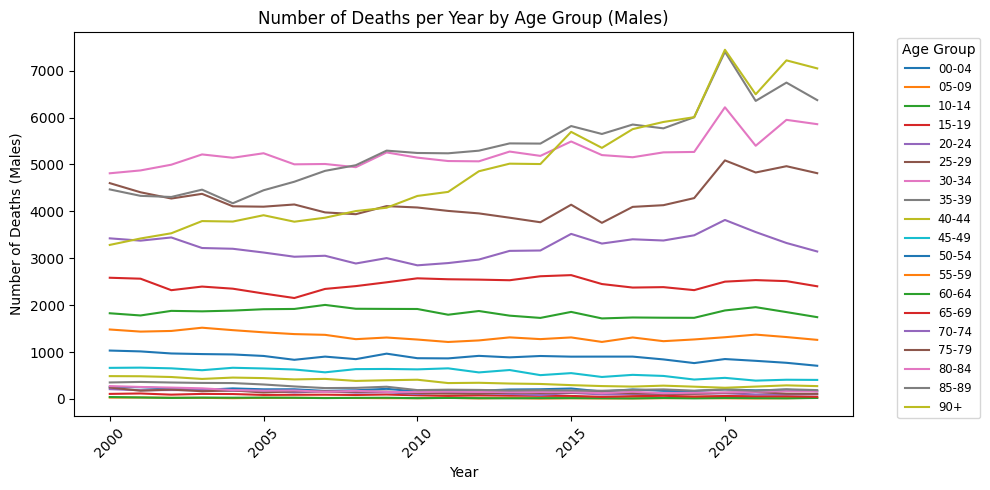

In [21]:
# Plot number of deaths per year by age group

# Filter for males in the original death_df (not prob_death, which is rates)
death_df_m = death_df[death_df['GENDER'] == 'M']

plt.figure(figsize=(10, 5))
for age_group in death_df_m['AGE_GROUP'].unique():
    df_plot = death_df_m[death_df_m['AGE_GROUP'] == age_group]
    plt.plot(df_plot['YEAR'], df_plot['OBS_VALUE'], label=age_group)
plt.xlabel('Year')
plt.ylabel('Number of Deaths (Males)')
plt.title('Number of Deaths per Year by Age Group (Males)')
plt.xticks(rotation=45)
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


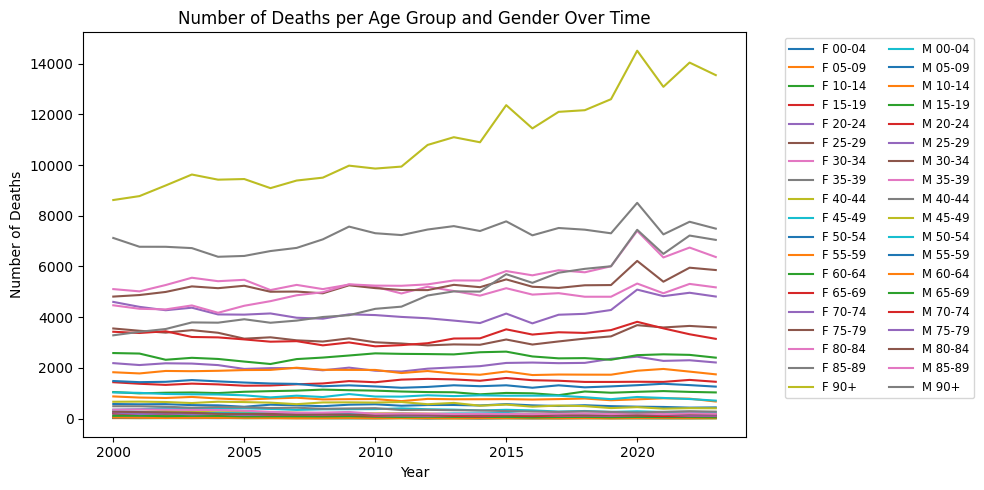

In [22]:
# Plot the number of deaths per age group for tracked years 
plt.figure(figsize=(10, 5))

age_groups = death_df['AGE_GROUP'].unique()
genders = ['F', 'M']

for gender in genders:
    for age_group in age_groups:
        df_plot = death_df[(death_df['GENDER'] == gender) & (death_df['AGE_GROUP'] == age_group)]
        if not df_plot.empty:
            plt.plot(df_plot['YEAR'], df_plot['OBS_VALUE'], label=f'{gender} {age_group}')

plt.xlabel('Year')
plt.ylabel('Number of Deaths')
#plt.yscale('log')
plt.title('Number of Deaths per Age Group and Gender Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()

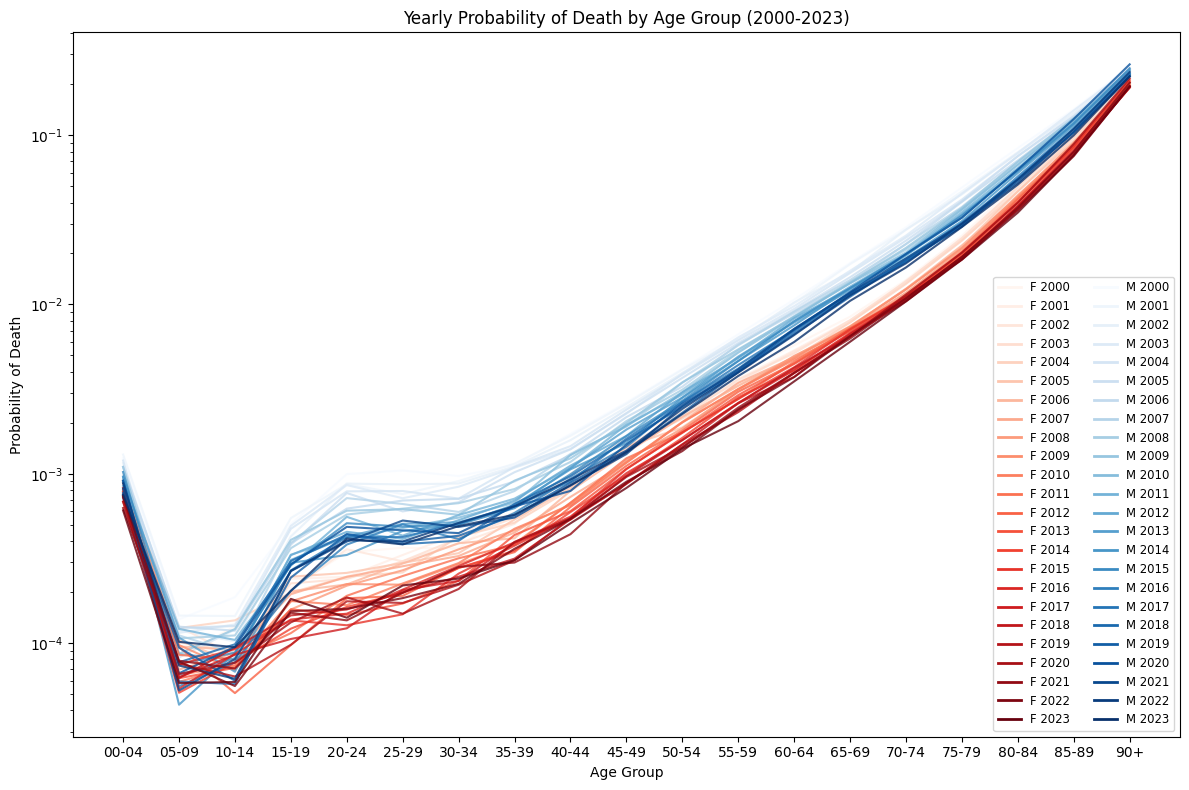

In [23]:
# PLOT PROBABILITY OF DEATH BY AGE GROUP AND YEAR (NICE PLOT)

plt.figure(figsize=(12, 8))

# Filter out years after 2010
years = sorted(prob_death['year'].unique())
# years = [y for y in years if y <= 2015 and y > 2005]

# Get color maps
reds = cm.get_cmap('Reds', len(years))
blues = cm.get_cmap('Blues', len(years))

for i, year in enumerate(years):
    for gender in ['M', 'F']:
        df_plot = prob_death[(prob_death['gender'] == gender) & (prob_death['year'] == year)]
        df_plot = df_plot.sort_values('age_group')
        if gender == 'F':
            color = reds(i)
        else:
            color = blues(i)
        plt.plot(df_plot['age_group'], df_plot['prob_death'], label=f'{gender} {year}', color=color, alpha=0.8)

plt.xlabel('Age Group')
plt.ylabel('Probability of Death')
plt.title('Yearly Probability of Death by Age Group (2000-2023)')
plt.yscale('log')
# Create custom legend handles sorted first by gender (M, F), then by year

# Prepare legend entries: (gender, year, color)
legend_entries = []
for i, year in enumerate(years):
    legend_entries.append(('M', year, blues(i)))
    legend_entries.append(('F', year, reds(i)))

# Sort first by gender (M, F), then by year
legend_entries = sorted(legend_entries, key=lambda x: (x[0], x[1]))

# Create handles and labels
handles = [Line2D([0], [0], color=color, lw=2) for (_, _, color) in legend_entries]
labels = [f"{gender} {year}" for (gender, year, _) in legend_entries]

plt.legend(handles, labels, ncol=2, loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()

##### BIRTH PROBABILITY ######

###### MARRIED ######

In [24]:
# BIRTH PROBABILITY CALCULATION - MARRIED WOMEN --> age distribution of both parents, parity (using Binomial Regression)

# Define bins and labels for women and men age groups <-- from available data
birth_age_bins_w = [0, 20, 25, 30, 35, 40, 45, 50, 200]
birth_age_labels_w = ['19-', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50+']

birth_age_bins_m = [0, 20, 25, 30, 35, 40, 45, 50, 60, 70, 200]
birth_age_labels_m = ['19-', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-59', '60-69', '70+']

parity_list = ['0', '1', '2', '3+']


####### NUMERATOR #######

births_df = pd.read_csv('data/bfs_births_2000_2023_kid_order_parents_ages.csv', delimiter=',')

# rename the columns
births_df.rename(columns={
    'Year' : 'year',
    'Birth order': 'birth_order', 
    'Age class of father': 'father_age_group',
    'Age class of mother': 'mother_age_group',
    'Live births': 'count'
}, inplace=True)    

# replace values in the 'birth order' column with the corresponding numbers
births_df['father_age_group'] = births_df['father_age_group'].replace(
    {'Less than 20 years': '19-', '20-24 years': '20-24', '25-29 years': '25-29', '30-34 years': '30-34',
    '35-39 years': '35-39', '40-44 years': '40-44', '45-49 years': '45-49', '50-59 years': '50-59', '60-69 years': '60-69',
    '70 years or more': '70+', 'Unknown': 'Unknown'})

births_df['mother_age_group'] = births_df['mother_age_group'].replace(
    {'Less than 20 years': '19-', '20-24 years': '20-24', '25-29 years': '25-29', '30-34 years': '30-34',
    '35-39 years': '35-39', '40-44 years': '40-44', '45-49 years': '45-49', '50 years or more': '50+'})

births_df['parity'] = births_df['birth_order'].replace({'First child': '0', 
                                                                 'Second child': '1', 
                                                                 'Third child': '2',
                                                                 'Fourth child or more': '3+', 
                                                                 'Mother not married': '99'})

# births for not married mothers: filter parity=99 as BFS does not provide parity for not married mothers 
births_df_celib = births_df.loc[births_df['parity'] == '99'].groupby(
    ['year', 'father_age_group', 'mother_age_group'], as_index=False)['count'].sum()

# If there are duplicate rows (same year, birth_order, father_age_group, mother_age_group), sum the 'count' column 
# --> to unify 45-49 and 50+ yo mothers categories
births_df = births_df.groupby(['year', 'parity', 'father_age_group', 'mother_age_group'], as_index=False)['count'].sum()




####### DENOMINATOR #######

# use uk data for share of women of a given age group that are mothers of n children already
uk_mothers = pd.read_csv('data/uk_women.csv', delimiter=';')
# replace commas with dots in the last 5 columns and convert to float
uk_mothers.iloc[:, -5:] = uk_mothers.iloc[:, -5:].replace(',', '.', regex=True).astype(float)
# drop Woman YOB column
uk_mothers.drop(columns='Year of birth of woman', inplace=True)
# convert the year column to int    
uk_mothers.iloc[:, :2] = uk_mothers.iloc[:, :2].astype(int)
# rename the columns
uk_mothers.columns = ['year', 'mother_age', '0', '1', '2', '3', '4+']
# group together 3 and 4+ children into a single column '3+' and drop the original columns
uk_mothers['3+'] = uk_mothers['3'] + uk_mothers['4+']
uk_mothers.drop(columns=['3', '4+'], inplace=True) 

uk_mothers['age_group'] = pd.cut(uk_mothers['mother_age'], bins=birth_age_bins_w, labels=birth_age_labels_w, right=False)

# group by year and age group and get the average of the values inside the same age groups
uk_mothers = uk_mothers.loc[uk_mothers.year == 2024]

if alternative_uk_mothers:
    # alternative:
    uk_mothers = pd.concat([uk_mothers, pd.DataFrame([{'year': 2024, 'mother_age': 19, 
                                '0': 98.2, '1': 1.6, '2': 0.2, '3+': 0, 'age_group': '19-'}])], ignore_index=True)
    
    uk_mothers = pd.concat([uk_mothers, pd.DataFrame([{'year': 2024, 'mother_age': 50, 
                                '0': 15.7, '1': 18.6, '2': 38.1, '3+': 27.6, 'age_group': '50+'}])], ignore_index=True)

else:
    # (we will set age group: 19- using data of 20yo as we don't have data before 20yo)
    # (and we will set 50+ using data of 45yo as we don't have data after 45yo)
    
    # Add a row for age group '19-' by duplicating the row where mother_age == 20
    uk_mothers = pd.concat([uk_mothers, uk_mothers[uk_mothers['mother_age'] == 20]], ignore_index=True)
    uk_mothers.loc[uk_mothers.index[-1], ('mother_age','age_group')] = (19,'19-')

    # # Add a row for age group '50+' with mother_age = 50 (duplicate the row where mother_age == 45)
    uk_mothers = pd.concat([uk_mothers, uk_mothers[uk_mothers['mother_age'] == 45]], ignore_index=True)
    uk_mothers.loc[uk_mothers.index[-1], ('mother_age', 'age_group')] = (50, '50+')

uk_mothers_plot = uk_mothers.copy()
uk_mothers = uk_mothers.groupby('age_group')[parity_list].mean().reset_index()



# import census data to compute number of woman married to men in given age group
file_name = f'data/hh_rw_' + str(initial_date) + '_ms.csv'
census_df = pd.read_csv(file_name, delimiter=',')

# import population_counts data --> to get multiplication factor of census to true population 
pop_counts_df = pd.read_csv('data/bfs_population_count.csv', delimiter=',')
pop_counts_df.rename(columns={'Year': 'year', 'Sex':'gender', 'Age':'age', 'Population': 'population'}, inplace=True)

# multiplier to get the population counts from the census data --> being a sample 
multiplier = round(pop_counts_df.loc[pop_counts_df.year == 2010].population.sum()/len(census_df))*multiplier_factor
if to_print:
    print(f"multiply absolute values of census by {multiplier} to get the population counts")


# TRANSFORM data to extract population count (given age of mother, father and birth order)

# filter couples in the census data
census_couples = census_df.loc[census_df.htype.isin([210, 220]) & (census_df.role.isin([1,2])) & (census_df['marital_status'] == 2)]

# group by age groups and count the number of census_couples whose husband (gender = 1) is in the given age group and wife (gender = 2) is in the given age group 
census_husbands = census_couples[census_couples['gender'] == 1][['hid', 'age']].rename(columns={'age': 'husband_age'})
census_wives = census_couples[census_couples['gender'] == 2][['hid', 'age']].rename(columns={'age': 'wife_age'})

census_husbands['husband_age_group'] = pd.cut(census_husbands['husband_age'], bins=birth_age_bins_m, labels=birth_age_labels_m, right=False)
census_wives['wife_age_group'] = pd.cut(census_wives['wife_age'], bins=birth_age_bins_w, labels=birth_age_labels_w, right=False)

# Merge on household id to get census_couples
census_couple_age_groups = pd.merge(census_husbands, census_wives, on='hid')

# Count number of census_couples by (husband_age_group, wife_age_group)
census_couple_age_groups = census_couple_age_groups.groupby(['husband_age_group', 'wife_age_group']).size().unstack(fill_value=0)

# add 1 to avoid division by zero in the next step and multiply by the multiplier to get the population counts (instead of sample counts)
census_couple_age_groups = (census_couple_age_groups + 1)*multiplier



# put census and uk_mothers data together --> DENOMINATOR
uk_mothers_melted = uk_mothers.melt(id_vars='age_group', 
                   value_vars=parity_list,
                   var_name='parity', 
                   value_name='share_women')
uk_mothers_melted.reset_index(inplace=True, drop=True)

exploded_census_couples = census_couple_age_groups.reset_index().melt(
    id_vars='husband_age_group',
    var_name='wife_age_group',
    value_name='count'
)

# for couples divide the number of births by the number of couples in the census data with the same age groups
# we assume distribution of age at women who already had 0,1,2,3+ children is the same independently of the age of the husband 

census_couples_w_births = exploded_census_couples.merge(
    uk_mothers_melted[['age_group','parity','share_women']], 
    left_on='wife_age_group', 
    right_on='age_group', 
    how='outer')

census_couples_w_births['count_adj'] = census_couples_w_births['count'] * census_couples_w_births['share_women']/100




####### NUMERATOR/DENOMINATOR #######

# merge NUMERATOR and DENOMINATOR to get the birth ratio 
birth_ratio = census_couples_w_births.merge(
    births_df.loc[births_df.year == initial_date], 
    left_on = ['parity', 'husband_age_group', 'wife_age_group'],
    right_on = ['parity', 'father_age_group', 'mother_age_group'], how='left')
birth_ratio = birth_ratio[['husband_age_group', 'wife_age_group', 'parity', 'count_adj', 'count_y']].rename(
    columns={'count_y': 'births_count', 'count_adj': 'census_count'})

# birth_ratio['birth_prob'] = birth_ratio.apply(
#    lambda row: row['births_count'] / row['census_count'] if row['census_count'] != 0 else 0, axis=1)

birth_ratio['census_count'].replace(0, 0.001, inplace=True)  # to avoid division by zero
birth_ratio['birth_prob'] = birth_ratio['births_count'] / birth_ratio['census_count']





#### BIRTH PROBABILITY CALCULATION - using Binomial regression #### 

# Calculate the birth probability for each combination of husband, wife age groups and parity using Binomial regression
birth_probability = pd.get_dummies(birth_ratio, columns=['husband_age_group', 'wife_age_group', 'parity'], drop_first=False, dtype=float)

X_cols = [c for c in birth_probability.columns 
          if c.startswith('husband_age_group_') 
          or c.startswith('wife_age_group_') 
          or c.startswith('parity_')]

# Convert boolean columns to int (0/1) for statsmodels
Xb = birth_probability[X_cols].astype(float)
Xb = sm.add_constant(Xb)

endog = np.vstack([
    birth_probability['births_count'],
    birth_probability['census_count'] - birth_probability['births_count']
]).T

binom_mod = sm.GLM(
    endog,
    Xb,
    family=sm.families.Binomial()
)
binom_res = binom_mod.fit()
birth_probability['p_hat_binom'] = binom_res.predict(Xb)


# print summary of the binomial regression model
if to_print:
    print(binom_res.summary())
 

# Recover 'wife_age_group' from dummies
wife_age_group_cols = [col for col in birth_probability.columns if col.startswith('wife_age_group_')]
birth_probability['wife_age_group'] = birth_probability[wife_age_group_cols].idxmax(axis=1).str.replace('wife_age_group_', '')

# Recover 'husband_age_group' from dummies
husband_age_group_cols = [col for col in birth_probability.columns if col.startswith('husband_age_group_')]
birth_probability['husband_age_group'] = birth_probability[husband_age_group_cols].idxmax(axis=1).str.replace('husband_age_group_', '')

# Recover 'husband_age_group' from dummies
parity_cols = [col for col in birth_probability.columns if col.startswith('parity_')]
birth_probability['parity'] = birth_probability[parity_cols].idxmax(axis=1).str.replace('parity_', '')

birth_probability.drop(columns=X_cols, inplace=True)
birth_probability = birth_probability[['wife_age_group', 'husband_age_group', 'parity', 'births_count', 'census_count', 'birth_prob', 'p_hat_binom']]




multiply absolute values of census by 98.0 to get the population counts
                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  320
Model:                            GLM   Df Residuals:                      300
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3967.2
Date:                Tue, 17 Jun 2025   Deviance:                       14008.
Time:                        08:29:23   Pearson chi2:                 7.95e+03
No. Iterations:                    50   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

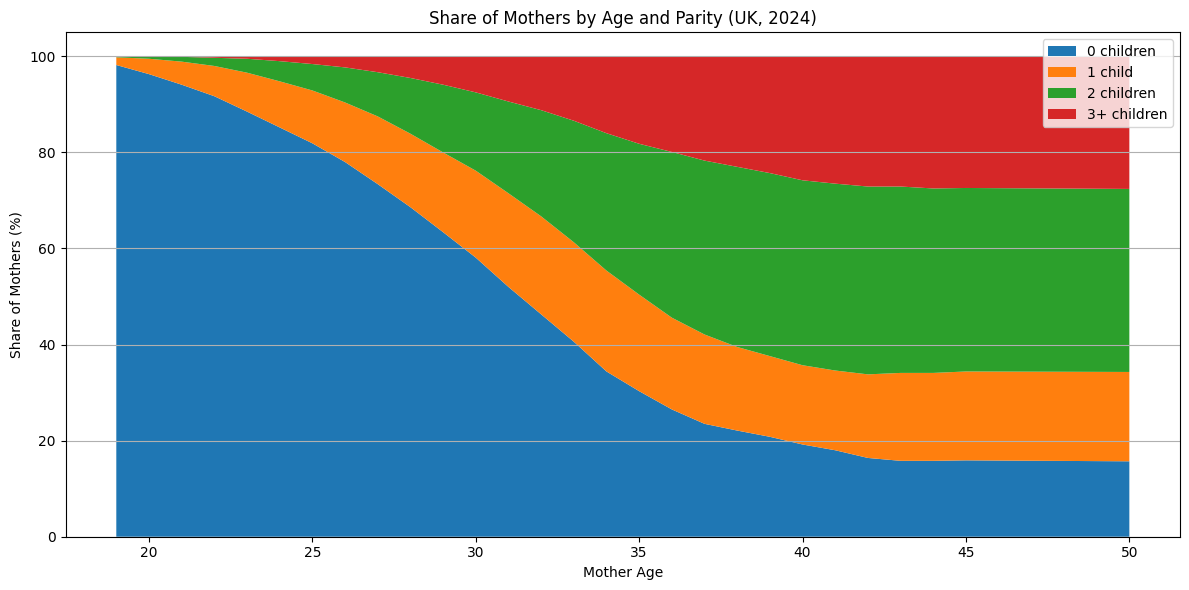

In [25]:
# Filter uk_mothers rate for 2024 --> year with data (avg. age at 1st birth, avg age at birth) closest to swiss data 2010
df_2023 = uk_mothers_plot.sort_values(by='mother_age').reset_index(drop=True)

# Convert columns to float
for n in ['0', '1', '2', '3+']:
    df_2023[n] = df_2023[n].astype(float)

plt.figure(figsize=(12, 6))
plt.stackplot(
    df_2023['mother_age'],
    [df_2023[n] for n in ['0', '1', '2', '3+']],
    labels=['0 children', '1 child', '2 children', '3+ children']
)
plt.xlabel('Mother Age')
plt.ylabel('Share of Mothers (%)')
plt.title('Share of Mothers by Age and Parity (UK, 2024)')
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


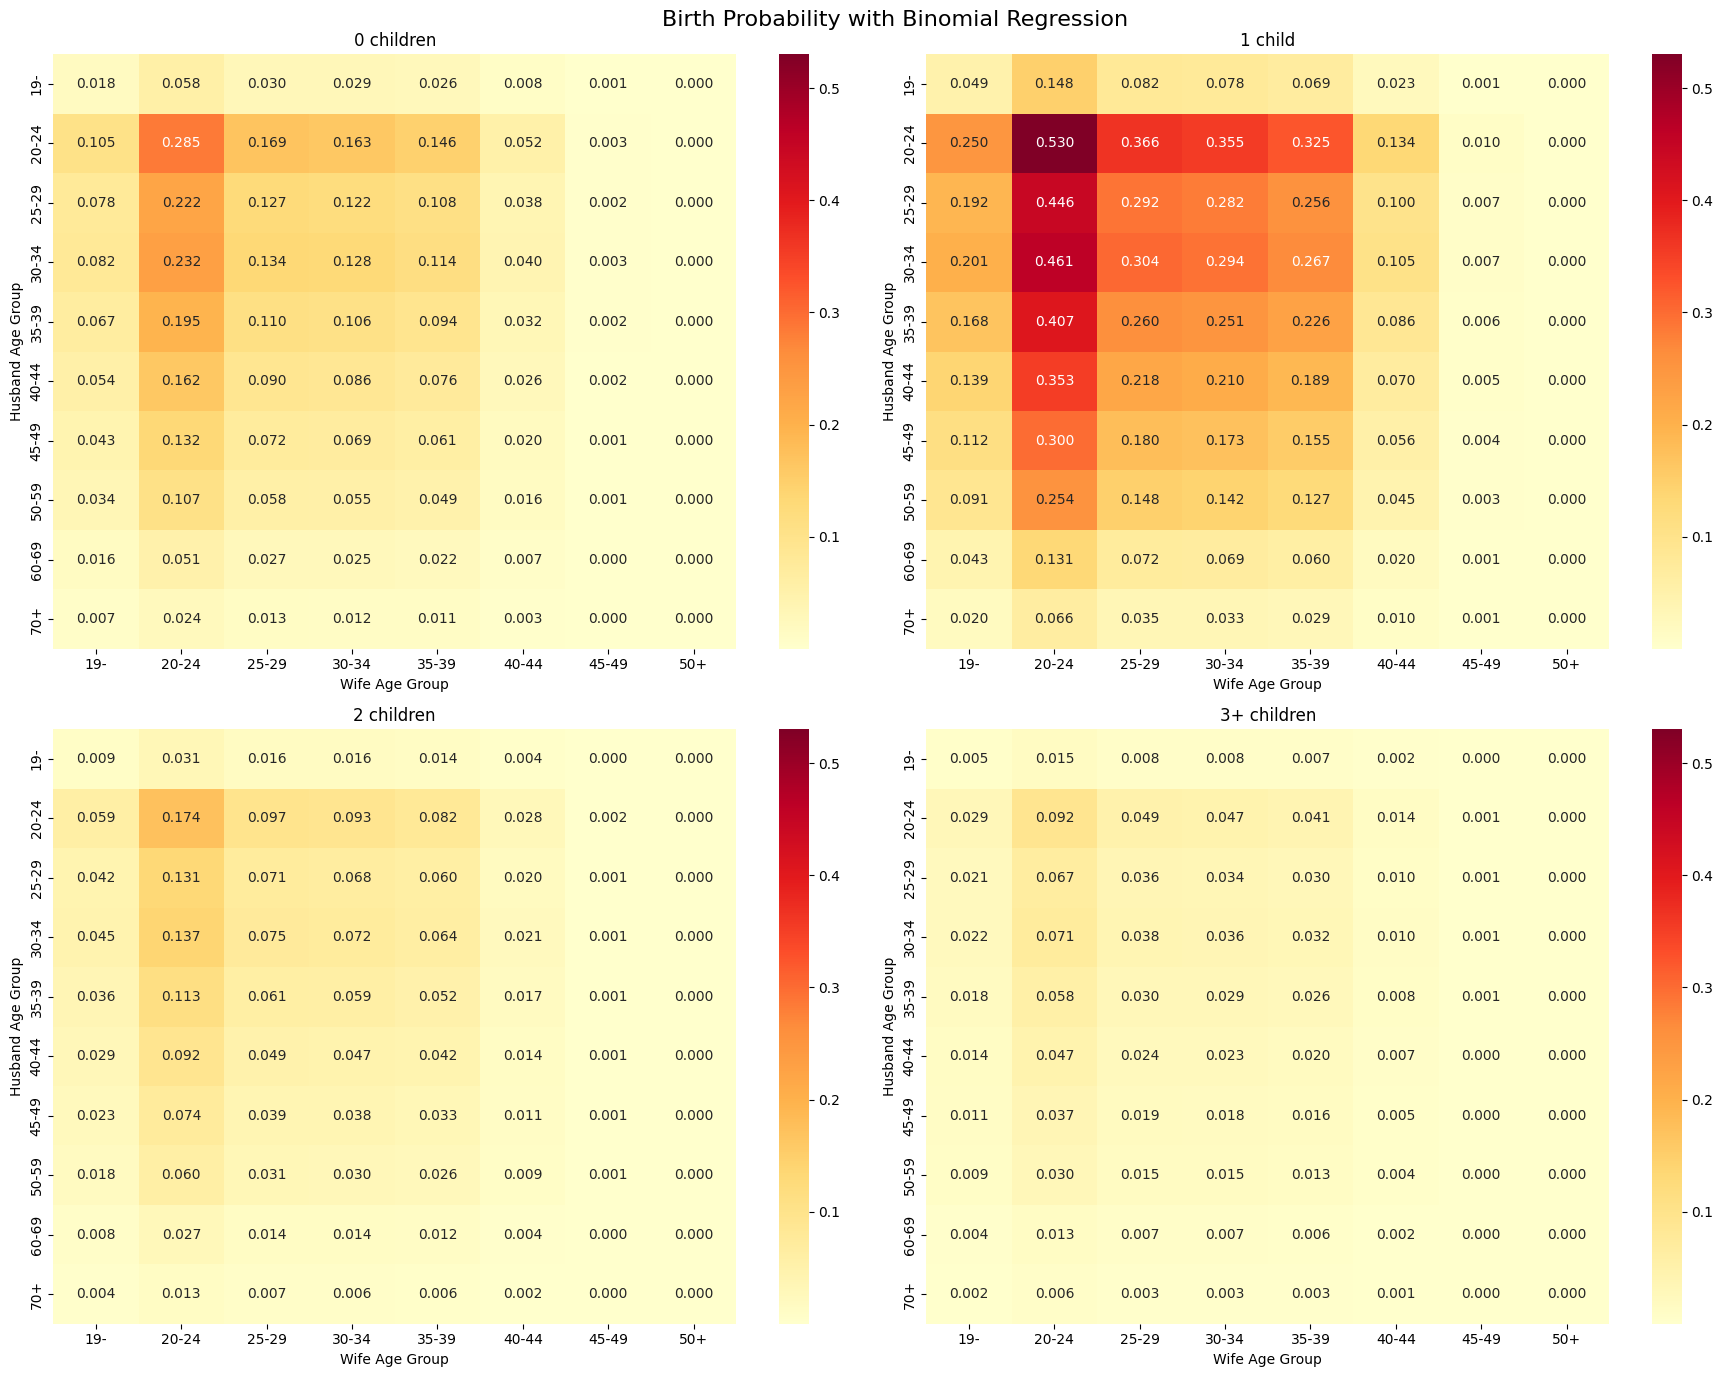

In [26]:
# Plot the birth probabilities as heatmap (for each parity category)

# Create a dictionary to hold the matrices for each parity category
birth_prob_matrices = {}

for parity in parity_list:
    matrix = birth_probability.loc[birth_probability['parity'] == parity].pivot_table(
        index='husband_age_group',
        columns='wife_age_group',
        values='p_hat_binom',
        fill_value=0
    ).reindex(index=birth_age_labels_m, columns=birth_age_labels_w)
    birth_prob_matrices[parity] = matrix

# Find the global min and max birth probability across all matrices for consistent color scale
all_values = np.concatenate([birth_prob_matrices[n].values.flatten() for n in parity_list])
vmin = np.nanmin(all_values)
vmax = np.nanmax(all_values)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
titles = ['0 children', '1 child', '2 children', '3+ children']

for i, n in enumerate(parity_list):
    ax = axes[i // 2, i % 2]
    sns.heatmap(
        birth_prob_matrices[n],
        cmap="YlOrRd",
        annot=True,
        fmt=".3f",
        ax=ax,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title(f'{titles[i]}')
    ax.set_xlabel('Wife Age Group')
    ax.set_ylabel('Husband Age Group')

plt.suptitle('Birth Probability with Binomial Regression', fontsize=16)
plt.tight_layout()
plt.show()



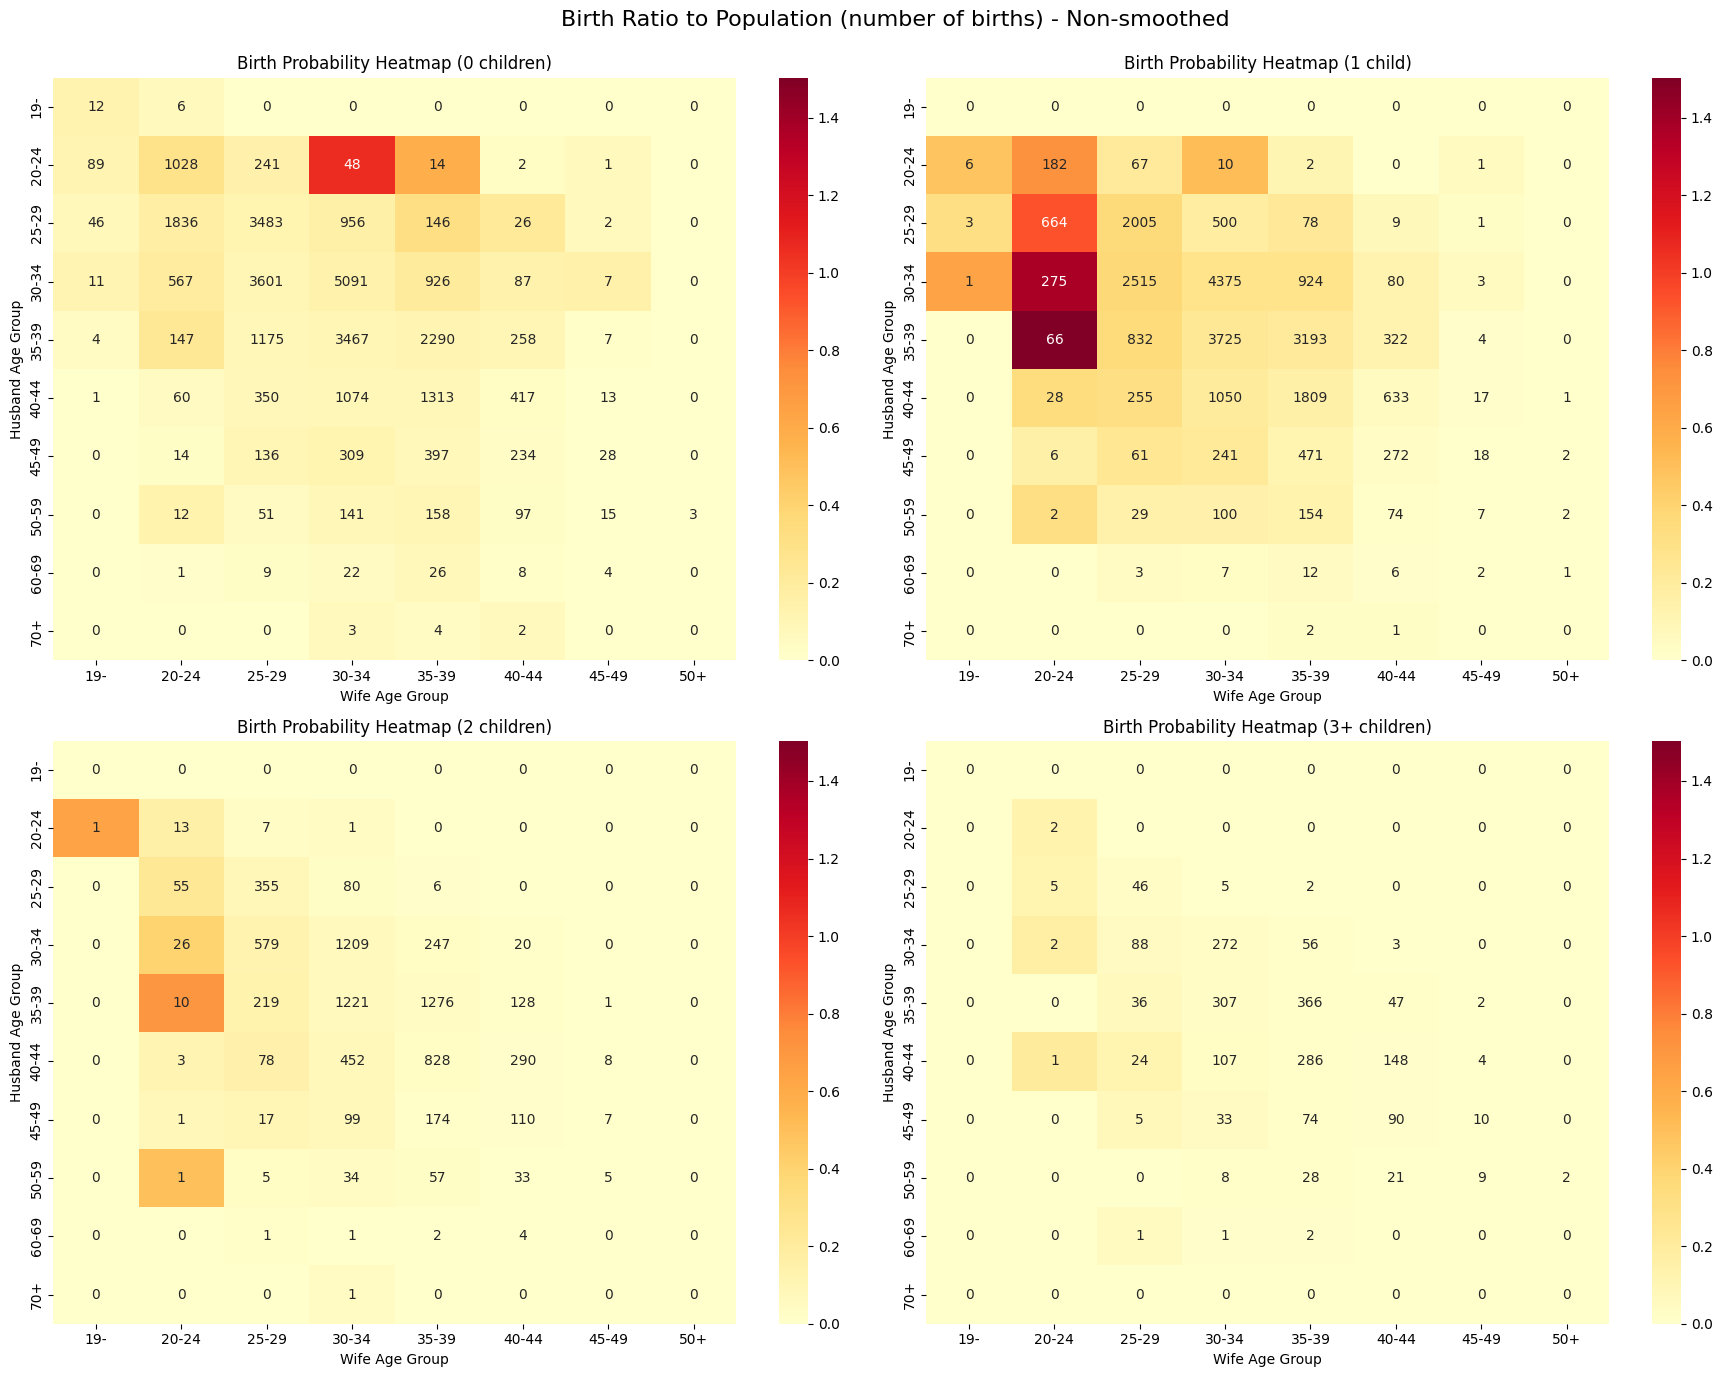

In [27]:
# Plot the birth ratio to population (number of births) as heatmap (for each parity category) - NON-SMOOTHED

# Find the global min and max birth probability across all matrices for consistent color scale
all_values = np.concatenate([
    birth_probability.loc[birth_probability['parity'] == parity]
    .pivot_table(index='husband_age_group', columns='wife_age_group', values='birth_prob', fill_value=0)
    .values.flatten()
    for parity in parity_list
])
vmin = np.nanmin(all_values)
vmax = np.nanmax(all_values)

titles = ['0 children', '1 child', '2 children', '3+ children']

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

for i, parity in enumerate(parity_list):
    ax = axes[i // 2, i % 2]
    mat = birth_probability.loc[birth_probability['parity'] == parity].pivot_table(
        index='husband_age_group',
        columns='wife_age_group',
        values='birth_prob',
        fill_value=0
    ).reindex(index=birth_age_labels_m, columns=birth_age_labels_w)
    # Prepare the annotation matrix with births_count for the current parity
    births_count_mat = birth_probability.loc[birth_probability['parity'] == parity].pivot_table(
        index='husband_age_group',
        columns='wife_age_group',
        values='births_count',
        fill_value=0
    ).reindex(index=birth_age_labels_m, columns=birth_age_labels_w)
    sns.heatmap(
        mat,
        cmap="YlOrRd",
        annot=births_count_mat,
        fmt=".0f",
        ax=ax,
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_title(f'Birth Probability Heatmap ({titles[i]})')
    ax.set_xlabel('Wife Age Group')
    ax.set_ylabel('Husband Age Group')

plt.suptitle('Birth Ratio to Population (number of births) - Non-smoothed\n', fontsize=16)
plt.tight_layout()
plt.show()


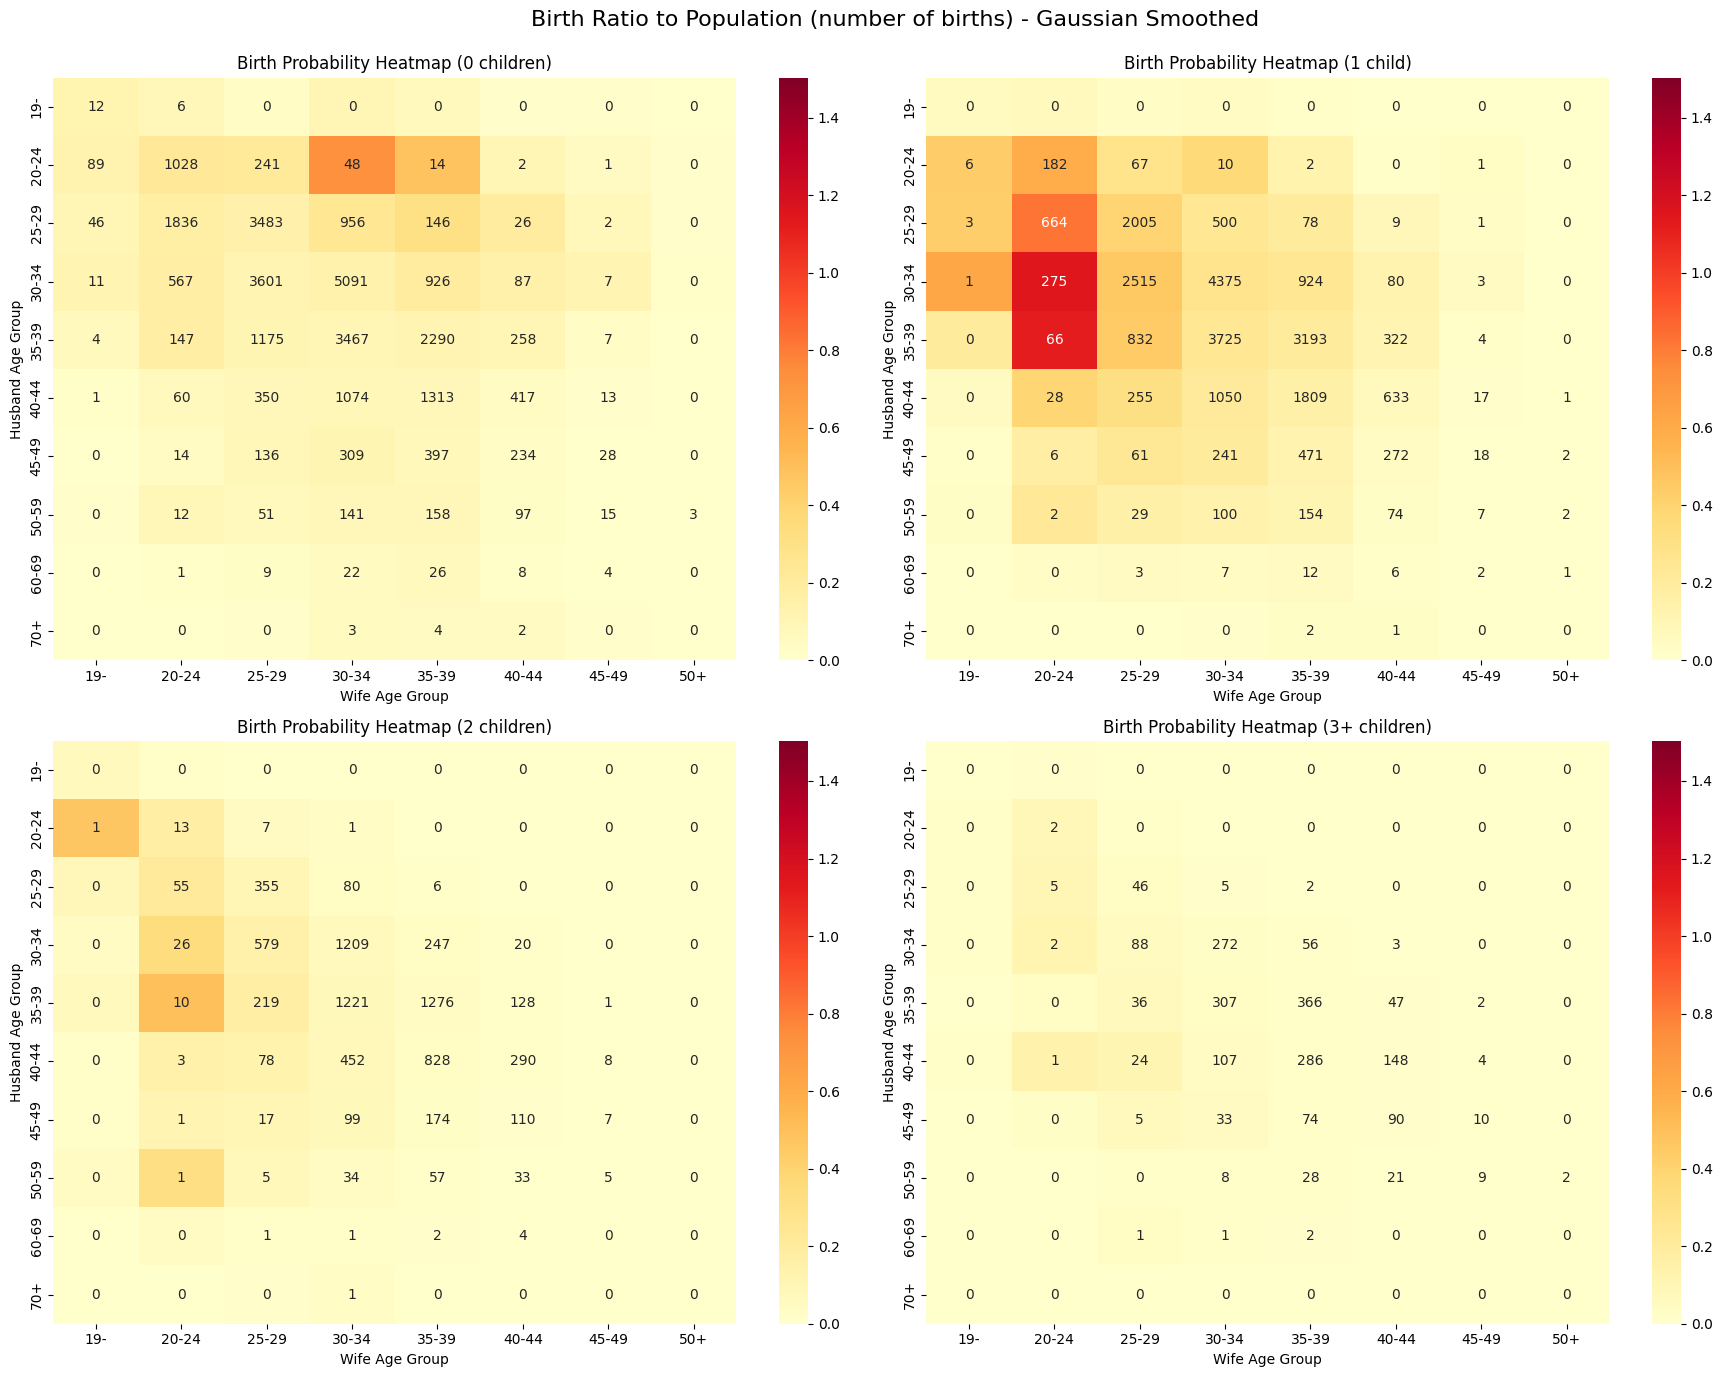

In [28]:
# Plot the birth ratio to population (number of births) as heatmap (for each parity category)

# Find the global min and max birth probability across all matrices for consistent color scale
all_values = np.concatenate([
    birth_probability.loc[birth_probability['parity'] == parity]
    .pivot_table(index='husband_age_group', columns='wife_age_group', values='birth_prob', fill_value=0)
    .values.flatten()
    for parity in parity_list
])
vmin = np.nanmin(all_values)
vmax = np.nanmax(all_values)

# Create a dictionary of smoothed birth probability matrices for each parity group using birth_probability
birth_prob_matrices_smoothed = {}

for parity in parity_list:
    mat = birth_probability.loc[birth_probability['parity'] == parity].pivot_table(
        index='husband_age_group',
        columns='wife_age_group',
        values='birth_prob',
        fill_value=0
    ).reindex(index=birth_age_labels_m, columns=birth_age_labels_w)
    smoothed = gaussian_filter(mat.values, sigma=selected_sigma)
    birth_prob_matrices_smoothed[parity] = pd.DataFrame(smoothed, index=mat.index, columns=mat.columns)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
titles = ['0 children', '1 child', '2 children', '3+ children']

for i, parity in enumerate(parity_list):
    ax = axes[i // 2, i % 2]
    # Avoid LogNorm error if vmin == 0 by setting a small positive value
    norm = LogNorm(vmin=max(vmin, 1e-6), vmax=vmax)
    # Prepare the annotation matrix with births_count for the current parity
    births_count_mat = birth_probability.loc[birth_probability['parity'] == parity].pivot_table(
        index='husband_age_group',
        columns='wife_age_group',
        values='births_count',
        fill_value=0
    ).reindex(index=birth_age_labels_m, columns=birth_age_labels_w)
    sns.heatmap(
        birth_prob_matrices_smoothed[parity],
        cmap="YlOrRd",
        annot=births_count_mat,
        fmt=".0f",
        ax=ax,
        # norm=norm,
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_title(f'Birth Probability Heatmap ({titles[i]})')
    ax.set_xlabel('Wife Age Group')
    ax.set_ylabel('Husband Age Group')

plt.suptitle('Birth Ratio to Population (number of births) - Gaussian Smoothed\n', fontsize=16)

plt.tight_layout()
plt.show()


###### NOT MARRIED ######

In [29]:
# BIRTH PROBABILITY CALCULATION - UNMARRIED WOMEN --> age distribution (using Binomial Regression)


####### NUMERATOR #######

# births_df_celib >>> defined earlier


####### DENOMINATOR #######

# multiplier >>> defined earlier
# census_df >>>  imported earlier

# TRANSFORM data to extract population count of unmarried women in couples

# filter couples in the census data
unmarried_couples = census_df.loc[census_df.htype.isin([210, 220]) & (census_df.role.isin([1,2])) &
                                   (census_df['marital_status'] != 2)]

unmarried_men   = unmarried_couples.loc[unmarried_couples.gender == 1][['hid', 'age']].rename(columns={'age': 'm_age'})
unmarried_women = unmarried_couples.loc[unmarried_couples.gender == 2][['hid', 'age']].rename(columns={'age': 'w_age'})

unmarried_men['m_age_group']    = pd.cut(unmarried_men['m_age'], bins=birth_age_bins_m, labels=birth_age_labels_m, right=False)
unmarried_women['w_age_group']  = pd.cut(unmarried_women['w_age'], bins=birth_age_bins_w, labels=birth_age_labels_w, right=False)

# Merge on household id to get census_couples
unmarried_couples_age_groups = pd.merge(unmarried_men, unmarried_women, on='hid')

# Count number of census_couples by (m_age_group, w_age_group)
unmarried_couples_age_groups = unmarried_couples_age_groups.groupby(['m_age_group', 'w_age_group']).size().unstack(fill_value=0)

# add 1 to avoid division by zero in the next step and multiply by the multiplier to get the population counts (instead of sample counts)
unmarried_couples_age_groups = (unmarried_couples_age_groups + 1)*multiplier

exploded_unmarried_couples = unmarried_couples_age_groups.reset_index().melt(
    id_vars='m_age_group',
    var_name='w_age_group',
    value_name='count')



####### NUMERATOR/DENOMINATOR #######

# merge NUMERATOR and DENOMINATOR to get the birth ratio 
unmarried_birth_ratio = exploded_unmarried_couples.merge(
    births_df_celib.loc[births_df_celib.year == initial_date], 
    left_on = ['m_age_group', 'w_age_group'],
    right_on = ['father_age_group', 'mother_age_group'], how='left')
unmarried_birth_ratio = unmarried_birth_ratio[['m_age_group', 'w_age_group', 'count_x', 'count_y']].rename(
    columns={'count_y': 'births_count', 'count_x': 'census_count'})

# unmarried_birth_ratio['birth_prob'] = unmarried_birth_ratio.apply(
#    lambda row: row['births_count'] / row['census_count'] if row['census_count'] != 0 else 0, axis=1)

unmarried_birth_ratio['census_count'].replace(0, 0.001, inplace=True)  # to avoid division by zero
unmarried_birth_ratio['birth_prob'] = unmarried_birth_ratio['births_count'] / unmarried_birth_ratio['census_count']





#### BIRTH PROBABILITY CALCULATION - using Binomial regression #### 

# Calculate the birth probability for each combination of husband, wife age groups using Binomial regression

# Remove rows with missing or zero census_count (to avoid division by zero and NaNs)
unmarried_birth_ratio_clean = unmarried_birth_ratio.copy()
unmarried_birth_ratio_clean = unmarried_birth_ratio_clean[unmarried_birth_ratio_clean['census_count'] > 0]
unmarried_birth_ratio_clean = unmarried_birth_ratio_clean.fillna(0)

# Create dummies for age groups
unmarried_birth_probability = pd.get_dummies(unmarried_birth_ratio_clean, columns=['m_age_group', 'w_age_group'],
                                              drop_first=False, dtype=float)

X_cols_um = [c for c in unmarried_birth_probability.columns 
          if c.startswith('m_age_group_') 
          or c.startswith('w_age_group_')]

# Convert boolean columns to float for statsmodels
Xb_um = unmarried_birth_probability[X_cols_um].astype(float)
Xb_um = sm.add_constant(Xb_um)

# Ensure births_count <= census_count
endog_um = np.vstack([
    np.minimum(unmarried_birth_probability['births_count'], unmarried_birth_probability['census_count']),
    unmarried_birth_probability['census_count'] - np.minimum(unmarried_birth_probability['births_count'],
                                                              unmarried_birth_probability['census_count'])
]).T

# Fit Binomial regression
binom_mod_um = sm.GLM(
    endog_um,
    Xb_um,
    family=sm.families.Binomial()
)
binom_res_um = binom_mod_um.fit()
unmarried_birth_probability['p_hat_binom'] = binom_res_um.predict(Xb_um)

# Set negative or >1 probabilities to valid range [0,1]
unmarried_birth_probability['p_hat_binom'] = unmarried_birth_probability['p_hat_binom'].clip(0, 1)


# print summary of the binomial regression model
if to_print:
    print(binom_res_um.summary())
 

# Recover 'w_age_group' from dummies
w_age_group_cols = [col for col in unmarried_birth_probability.columns if col.startswith('w_age_group_')]
unmarried_birth_probability['w_age_group'] = unmarried_birth_probability[w_age_group_cols].idxmax(axis=1).str.replace('w_age_group_', '')

# Recover 'm_age_group' from dummies
m_age_group_cols = [col for col in unmarried_birth_probability.columns if col.startswith('m_age_group_')]
unmarried_birth_probability['m_age_group'] = unmarried_birth_probability[m_age_group_cols].idxmax(axis=1).str.replace('m_age_group_', '')

unmarried_birth_probability.drop(columns=X_cols_um, inplace=True)
unmarried_birth_probability = unmarried_birth_probability[['w_age_group', 'm_age_group', 'births_count', 'census_count', 'birth_prob', 'p_hat_binom']]



                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                   80
Model:                            GLM   Df Residuals:                       63
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -994.29
Date:                Tue, 17 Jun 2025   Deviance:                       1669.6
Time:                        08:29:28   Pearson chi2:                 2.18e+03
No. Iterations:                    19   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.5173      0.11

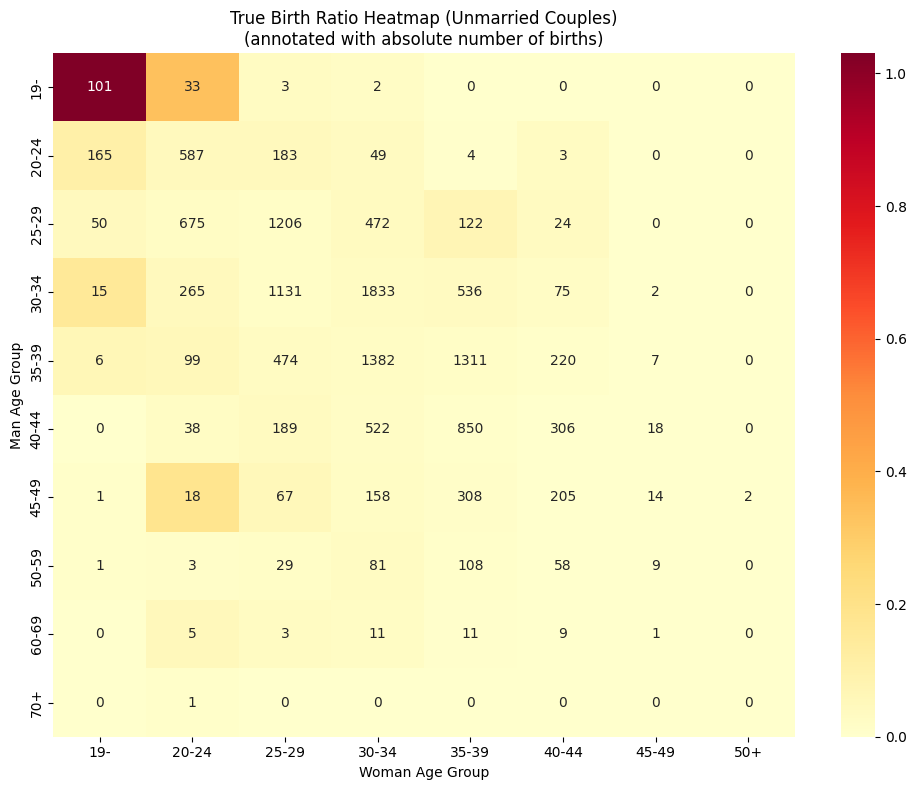

In [30]:
# Create the matrix for true birth ratio (not the binomial estimate)
um_ratio_matrix = unmarried_birth_probability.pivot_table(
    index='m_age_group',
    columns='w_age_group',
    values='birth_prob',
    fill_value=0
).reindex(index=birth_age_labels_m, columns=birth_age_labels_w)

# Create the annotation matrix with absolute number of births
um_births_matrix = unmarried_birth_probability.pivot_table(
    index='m_age_group',
    columns='w_age_group',
    values='births_count',
    fill_value=0
).reindex(index=birth_age_labels_m, columns=birth_age_labels_w)

# Find the min and max for color scale
vmin = np.nanmin(um_ratio_matrix.values)
vmax = np.nanmax(um_ratio_matrix.values)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    um_ratio_matrix,
    cmap="YlOrRd",
    annot=um_births_matrix,
    fmt=".0f",
    ax=ax,
    vmin=vmin,
    vmax=vmax
)
ax.set_title('True Birth Ratio Heatmap (Unmarried Couples)\n(annotated with absolute number of births)')
ax.set_xlabel('Woman Age Group')
ax.set_ylabel('Man Age Group')

plt.tight_layout()
plt.show()


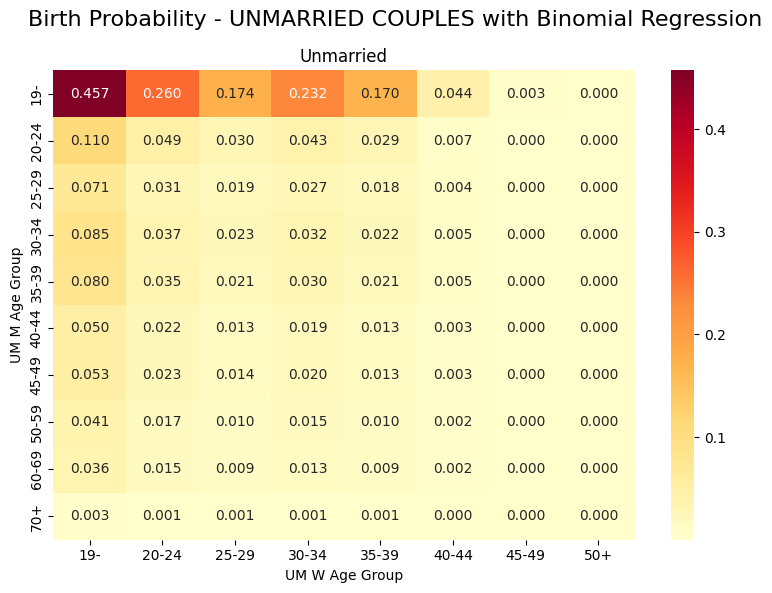

In [31]:
# Plot the birth probabilities as heatmap (for each parity category)

# Create a dictionary to hold the matrices for each parity category
matrix = unmarried_birth_probability.pivot_table(
    index='m_age_group',
    columns='w_age_group',
    values='p_hat_binom',
    fill_value=0
).reindex(index=birth_age_labels_m, columns=birth_age_labels_w)


# Find the global min and max birth probability across all matrices for consistent color scale
all_values = np.concatenate([matrix.values.flatten()])
vmin = np.nanmin(all_values)
vmax = np.nanmax(all_values)

fig, ax = plt.subplots(1, figsize=(8, 6))
sns.heatmap(
    matrix,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=ax,
    vmin=vmin,
    vmax=vmax
)
ax.set_title('Unmarried')
ax.set_xlabel('UM W Age Group')
ax.set_ylabel('UM M Age Group')

plt.suptitle('Birth Probability - UNMARRIED COUPLES with Binomial Regression', fontsize=16)
plt.tight_layout()
plt.show()


##### MARRIAGE PROBABILITY #####

In [32]:
# MARRIAGE RATIO 
# (assumptions: same distribution in and out of cohabitating couples for lack of data) 

census_df = pd.read_csv('data/hh_rw_' + str(initial_date) + '_ms.csv', delimiter=',')
pop_df = pop_age_sex_df

####### NUMERATOR #######
# count of marriages by age group of partners and their marital status

marriages_df = pd.read_csv('data/bfs_marriages_age_groups_marital_status.csv', delimiter=';', encoding='latin1')
marriages_df[['age_group_m', 'age_group_w']] = marriages_df[['age_group_m', 'age_group_w']].replace(
    {'Meno di 20 anni': '19-', '20-24 anni': '20-24', '25-29 anni': '25-29',
    '30-34 anni': '30-34', '35-39 anni': '35-39', '40-49 anni': '40-49',
    '50-59 anni': '50-59', '60 anni o più': '60+'})

marriages_df[['marital_status_m', 'marital_status_w']] = marriages_df[['marital_status_m', 'marital_status_w']].replace(
    {'Celibe/nubile': 1, 'Vedovo/a' : 3, 'Divorziato/a': 3,
     'In unione domestica registrata' : 3, 'Altro (Non coniugato/a, unione domestica sciolta)': 3})

marriages_df['previous_marriages'] = 1
marriages_df.loc[(marriages_df['marital_status_m'] == 1) & (marriages_df['marital_status_w'] == 1), 'previous_marriages'] = 0

# If there are duplicate rows (same year, previous_marriages, age_group_m, age_group_w), sum the 'count' column 
# --> to unify remarriage categories (3)
marriages_df_year = marriages_df.loc[marriages_df.year == initial_date].groupby(['age_group_m', 'age_group_w', 
                                     'previous_marriages'], as_index=False)['count'].sum().rename(columns={'count': 'marriages_count'})



####### DENOMINATOR #######
# count of people by age group and their marital status:   --> at risk population
# 1st marriage = both celib 
# remarriage = at least one of the partners was married before (widowed or divorced)

marriage_age_bins = [0, 20, 25, 30, 35, 40, 50, 60, 200]
marriage_age_labels = ['19-', '20-24', '25-29', '30-34', '35-39', '40-49', '50-59', '60+']

# filter couples in the census data
census_couples = census_df.loc[census_df.htype.isin([210, 220]) & (census_df.role.isin([1,2])) & (census_df['marital_status'] != 2)]

# group by age groups and count the number of census_couples whose husband (gender = 1) is in the given age group and wife (gender = 2) is in the given age group 
census_m = census_couples[census_couples['gender'] == 1][
    ['hid', 'age', 'marital_status']].rename(columns={'age': 'age_m', 'marital_status': 'marital_status_m'})
census_w = census_couples[census_couples['gender'] == 2][
    ['hid', 'age', 'marital_status']].rename(columns={'age': 'age_w', 'marital_status': 'marital_status_w'})   

census_m['age_group_m'] = pd.cut(census_m['age_m'], bins=marriage_age_bins, labels=marriage_age_labels, right=False)
census_w['age_group_w'] = pd.cut(census_w['age_w'], bins=marriage_age_bins, labels=marriage_age_labels, right=False)

# Merge on household id to get census_couples
census_couple_age_groups = pd.merge(census_m, census_w, on='hid')
census_couple_age_groups = census_couple_age_groups[['age_group_m','marital_status_m','age_group_w','marital_status_w']]
# Count number of census_couples by (husband_age_group, wife_age_group, marital_status_m, marital_status_w)

census_couple_age_groups['previous_marriages'] = 1
census_couple_age_groups.loc[
    (census_couple_age_groups['marital_status_m'] == 1) & 
    (census_couple_age_groups['marital_status_w'] == 1), 'previous_marriages'] = 0

# Count number of census_couples by (husband_age_group, wife_age_group, previous_marriages)
census_marriage_count = census_couple_age_groups[
    ['age_group_m', 'age_group_w','previous_marriages']].reset_index().groupby([
        'age_group_m','age_group_w', 'previous_marriages']).size().reset_index(name='count')

# adjust the counts to get the population counts (instead of sample counts)
census_marriage_count['census_count'] = (census_marriage_count['count'] + 1) * multiplier



####### NUMERATOR / DENOMINATOR #######
# to get the marriage ratio
marriage_ratio = marriages_df_year.merge(census_marriage_count, 
    on=['age_group_m', 'age_group_w', 'previous_marriages'], how='left')
marriage_ratio = marriage_ratio[['age_group_m', 'age_group_w', 'previous_marriages', 'census_count', 'marriages_count']]
marriage_ratio['census_count'].replace(0, 0.001, inplace=True)
marriage_ratio['marriage_ratio'] = marriage_ratio.apply(
   lambda row: row['marriages_count'] / row['census_count'] if row['census_count'] != 0 else 0, axis=1)

marriage_ratio_1st = marriage_ratio.loc[marriage_ratio['previous_marriages'] == 0].copy()
marriage_ratio_1st.drop(columns='previous_marriages', inplace=True)

marriage_ratio_remarriage = marriage_ratio.loc[marriage_ratio['previous_marriages'] == 1].copy()
marriage_ratio_remarriage.drop(columns='previous_marriages', inplace=True)


In [33]:
#### MARRIAGE PROBABILITY - with CHILDREN EFFECT #### 

# Calculate the marriage probability for each combination of husband, wife age groups and previous_marriages using Binomial regression

marriage_prob = pd.get_dummies(marriage_ratio, columns=['age_group_m', 'age_group_w', 'previous_marriages'],
                                drop_first=False, dtype=float)

X_cols = [c for c in marriage_prob.columns 
          if c.startswith('age_group_m_') 
          or c.startswith('age_group_w_')
          or c.startswith('previous_marriages_')]

# Convert boolean columns to int (0/1) for statsmodels
Xb = marriage_prob[X_cols].astype(float)
Xb = sm.add_constant(Xb)

endog = np.vstack([
    marriage_prob['marriages_count'],
    marriage_prob['census_count'] - marriage_prob['marriages_count']
]).T

# ADD CHILDREN-EFFECT OFFSET (assume same distribution for 1st marriages and remarriages)
#    e.g. survey says that after 2 year of living together P_2y(married|kids)=0.95 vs P_2y(married|no_kids)=0.59
#    compute probability of marriage each year 
#    P_y(married|kids) = 1-(sqrt(1-P_2y(married|kids)))
#    P_y(married|no_kids) = 1-(sqrt(1-P_2y(married|no_kids)))
#    → odds_with_kids = P_y(married|kids)/(1-P_y(married|kids)) = alfa,  
#    → odds_no_kids = P_y(married|no_kids)/(1-P_y(married|no_kids)) = beta
#    → θ = alfa/beta → ln(θ)

prob_w_kids_2y = .95
prob_wo_kids_2y = .59
nm_prob_w_kids = 1 - prob_w_kids_2y
nm_prob_wo_kids = 1 - prob_wo_kids_2y

y_nm_w_kids = sqrt(1-prob_w_kids_2y)
y_nm_wo_kids = sqrt(1-prob_wo_kids_2y)

y_w_kids = 1-y_nm_w_kids
y_wo_kids = 1-y_nm_wo_kids

theta = (y_w_kids/y_nm_w_kids) / (y_wo_kids/y_nm_wo_kids)
alpha = np.log(theta)
offset = alpha

# 5) Fit GLM with offset
binom_mod = sm.GLM(endog, 
                   Xb,
                   family=sm.families.Binomial()
                   )

binom_res = binom_mod.fit()
marriage_prob['p_hat_binom_no_children'] = binom_res.predict(Xb, offset=[0.0])
marriage_prob['p_hat_binom_children'] = binom_res.predict(Xb, offset=[alpha])


# print summary of the binomial regression model
if to_print:
    print(binom_res.summary())
 

# Recover 'age_group_w' from dummies
age_group_w_cols = [col for col in marriage_prob.columns if col.startswith('age_group_w_')]
marriage_prob['age_group_w'] = marriage_prob[age_group_w_cols].idxmax(axis=1).str.replace('age_group_w_', '')

# Recover 'age_group_m' from dummies
age_group_m_cols = [col for col in marriage_prob.columns if col.startswith('age_group_m_')]
marriage_prob['age_group_m'] = marriage_prob[age_group_m_cols].idxmax(axis=1).str.replace('age_group_m_', '')

# Recover 'previous_marriages' from dummies
previous_marriages_cols = [col for col in marriage_prob.columns if col.startswith('previous_marriages_')]
marriage_prob['previous_marriages'] = marriage_prob[previous_marriages_cols].idxmax(axis=1).str.replace('previous_marriages_', '')

marriage_prob.drop(columns=X_cols, inplace=True)
marriage_prob = marriage_prob[['age_group_w', 'age_group_m', 'previous_marriages', 
                                                 'marriages_count','census_count', 'marriage_ratio', 
                                                 'p_hat_binom_no_children', 'p_hat_binom_children']]

# explode the marriage probability data to have separate rows for couples with and without children
marriage_prob_no_child = marriage_prob.copy()
marriage_prob_no_child['children'] = 0
marriage_prob_no_child['p_hat_binom'] = marriage_prob_no_child['p_hat_binom_no_children']

marriage_prob_child = marriage_prob.copy()
marriage_prob_child['children'] = 1
marriage_prob_child['p_hat_binom'] = marriage_prob_child['p_hat_binom_children']

marriage_prob_draw = pd.concat([marriage_prob_no_child, marriage_prob_child], ignore_index=True)
marriage_prob_draw = marriage_prob_draw.drop(columns=['p_hat_binom_no_children', 'p_hat_binom_children'])


                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  128
Model:                            GLM   Df Residuals:                      112
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 17 Jun 2025   Deviance:                   6.5239e+06
Time:                        08:29:29   Pearson chi2:                 1.63e+20
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.794e+14 

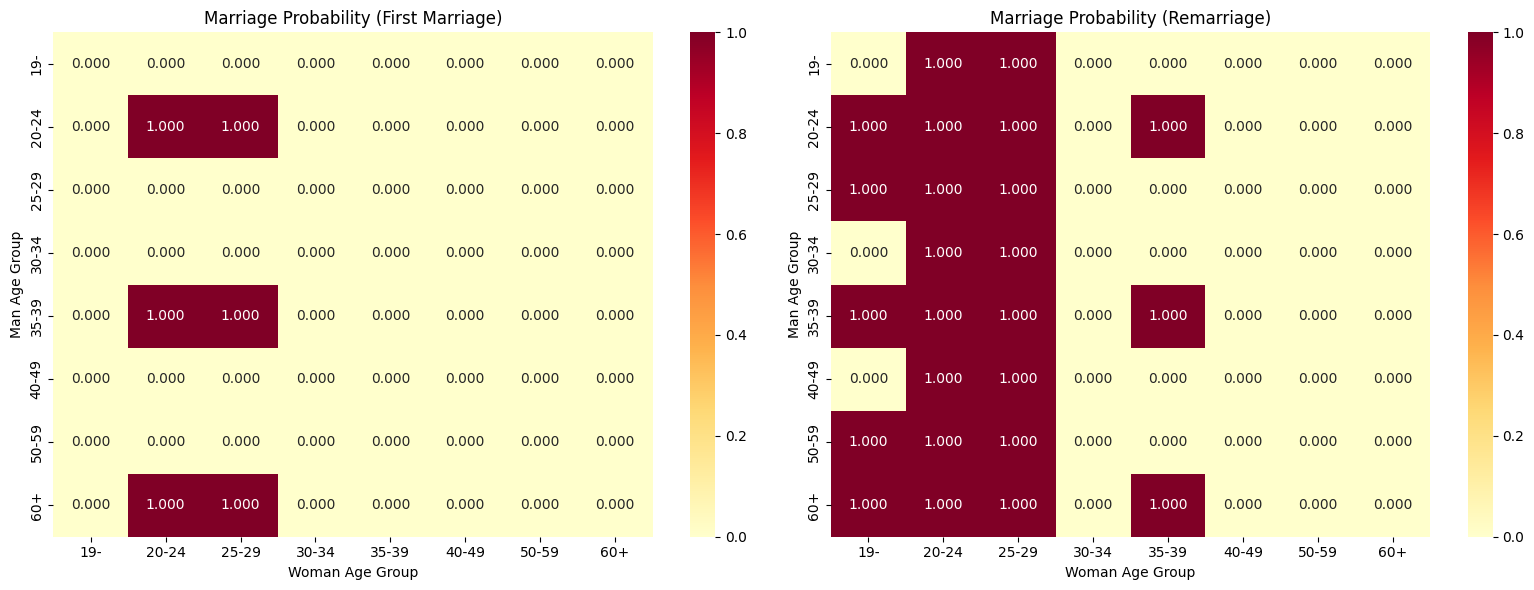

In [34]:
# HEATMAP MARRIAGE PROBABILITY - NO CHILDREN
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
titles = ['Marriage Probability (First Marriage)', 'Marriage Probability (Remarriage)']

# Prepare heatmaps using marriage_prob and multiply probability by previous_marriages factor

# First marriage (previous_marriages = 0)
heatmap_noc_1st = marriage_prob[marriage_prob['previous_marriages'] == '0'].pivot_table(
    index='age_group_m', columns='age_group_w', values='p_hat_binom_no_children', fill_value=0
)

# Remarriage (previous_marriages = 1)
heatmap_noc_remarriage = marriage_prob[marriage_prob['previous_marriages'] == '1'].pivot_table(
    index='age_group_m', columns='age_group_w', values='p_hat_binom_no_children', fill_value=0
)


vmin = min(heatmap_noc_1st.min().min(), heatmap_noc_remarriage.min().min())
vmax = max(heatmap_noc_1st.max().max(), heatmap_noc_remarriage.max().max())


# For first marriage, previous_marriages factor is 1 (no change)
sns.heatmap(
    heatmap_noc_1st,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[0],
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title(titles[0])
axes[0].set_xlabel('Woman Age Group')
axes[0].set_ylabel('Man Age Group')

# For remarriage, multiply probability by previous_marriages factor (which is 1 here, so no change)
sns.heatmap(
    heatmap_noc_remarriage,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[1],
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title(titles[1])
axes[1].set_xlabel('Woman Age Group')
axes[1].set_ylabel('Man Age Group')

plt.tight_layout()
plt.show()


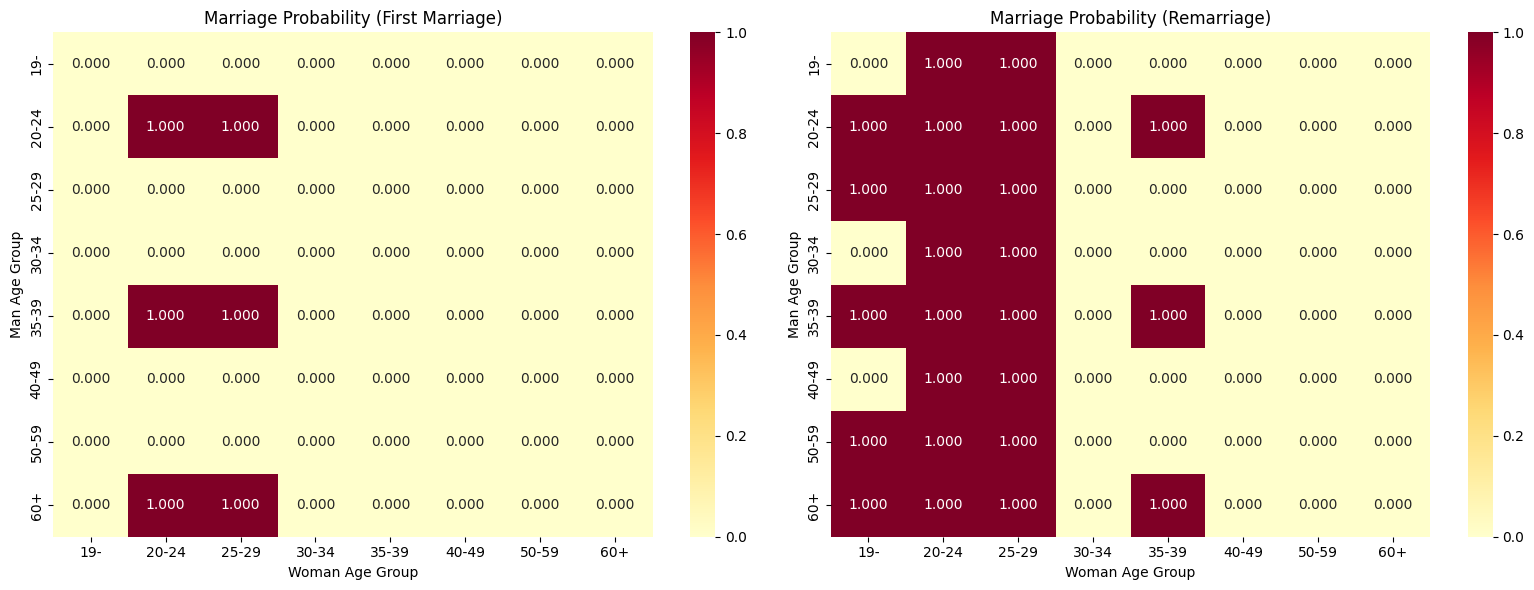

In [35]:
# HEATMAP MARRIAGE PROBABILITY WITH CHILDREN
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
titles = ['Marriage Probability (First Marriage)', 'Marriage Probability (Remarriage)']

# Prepare heatmaps using marriage_prob and multiply probability by previous_marriages factor

# First marriage (previous_marriages = 0)
heatmap_child_1st = marriage_prob[marriage_prob['previous_marriages'] == '0'].pivot_table(
    index='age_group_m', columns='age_group_w', values='p_hat_binom_children', fill_value=0
)

# Remarriage (previous_marriages = 1)
heatmap_child_remarriage = marriage_prob[marriage_prob['previous_marriages'] == '1'].pivot_table(
    index='age_group_m', columns='age_group_w', values='p_hat_binom_children', fill_value=0
)


vmin = min(heatmap_child_1st.min().min(), heatmap_child_remarriage.min().min())
vmax = max(heatmap_child_1st.max().max(), heatmap_child_remarriage.max().max())


# For first marriage, previous_marriages factor is 1 (no change)
sns.heatmap(
    heatmap_child_1st,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[0],
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title(titles[0])
axes[0].set_xlabel('Woman Age Group')
axes[0].set_ylabel('Man Age Group')

# For remarriage, multiply probability by previous_marriages factor (which is 1 here, so no change)
sns.heatmap(
    heatmap_child_remarriage,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[1],
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title(titles[1])
axes[1].set_xlabel('Woman Age Group')
axes[1].set_ylabel('Man Age Group')

plt.tight_layout()
plt.show()

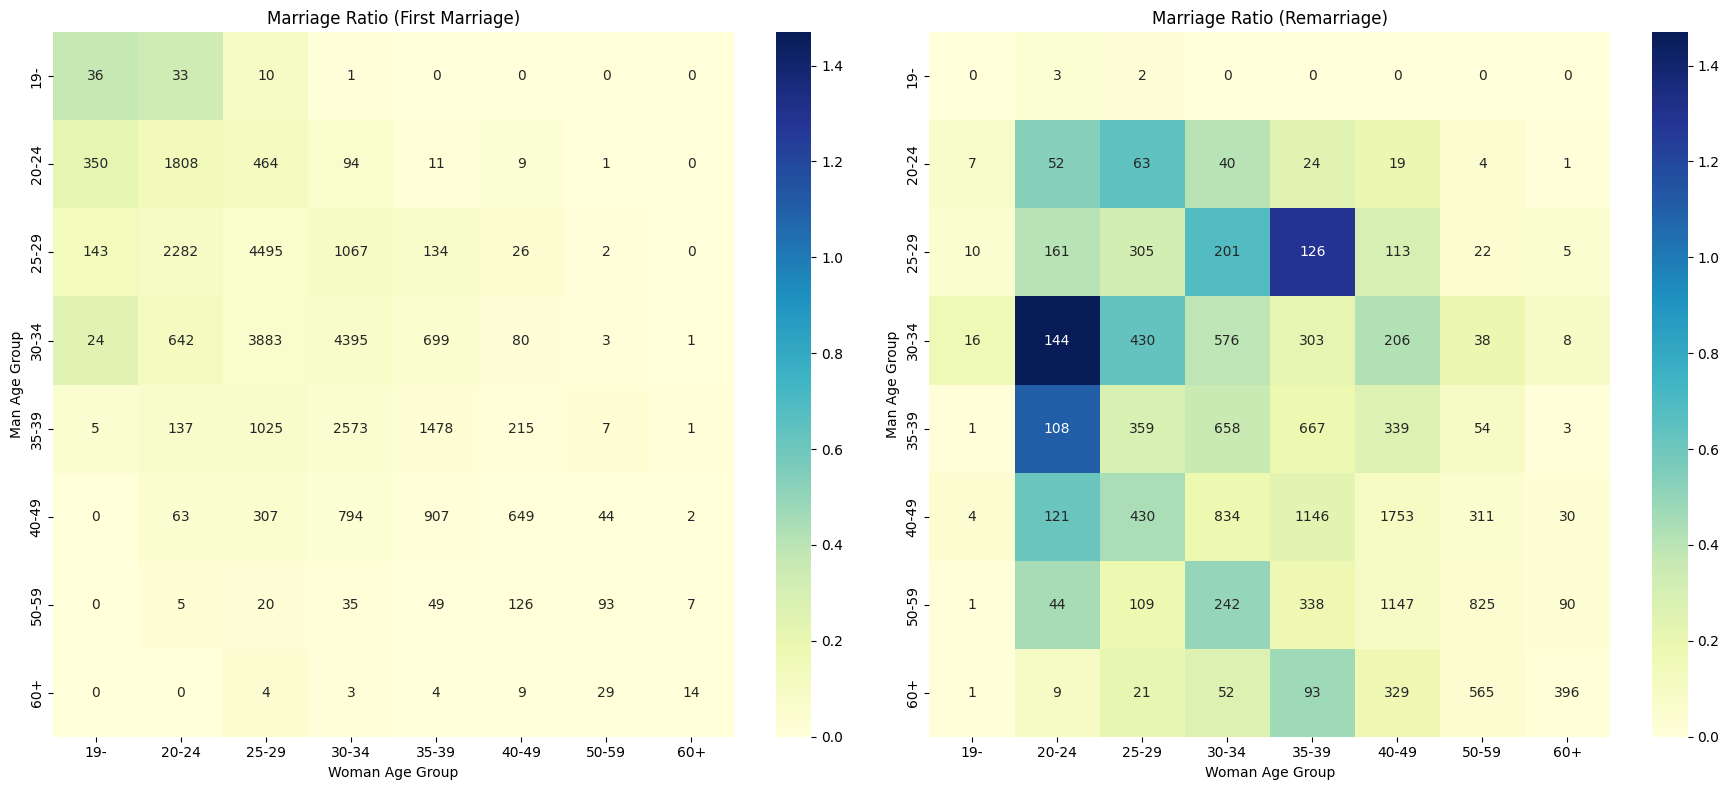

In [36]:
# HEATMAPS RAW MARRIAGE RATIO 

# Pivot tables for previous_marriages = 0 and 1
heatmap_0 = marriage_ratio[marriage_ratio['previous_marriages'] == 0].pivot_table(
    index='age_group_m', columns='age_group_w', values='marriage_ratio', fill_value=0)
annot_0 = marriage_ratio[marriage_ratio['previous_marriages'] == 0].pivot_table(
    index='age_group_m', columns='age_group_w', values='marriages_count', fill_value=0)

heatmap_1 = marriage_ratio[marriage_ratio['previous_marriages'] == 1].pivot_table(
    index='age_group_m', columns='age_group_w', values='marriage_ratio', fill_value=0)
annot_1 = marriage_ratio[marriage_ratio['previous_marriages'] == 1].pivot_table(
    index='age_group_m', columns='age_group_w', values='marriages_count', fill_value=0)

vmin = min(heatmap_0.min().min(), heatmap_1.min().min())
vmax = max(heatmap_0.max().max(), heatmap_1.max().max())

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(
    heatmap_0, annot=annot_0, fmt=".0f", cmap="YlGnBu", ax=axes[0], vmin=vmin, vmax=vmax
)
axes[0].set_title("Marriage Ratio (First Marriage)")
axes[0].set_xlabel("Woman Age Group")
axes[0].set_ylabel("Man Age Group")

sns.heatmap(
    heatmap_1, annot=annot_1, fmt=".0f", cmap="YlGnBu", ax=axes[1], vmin=vmin, vmax=vmax
)
axes[1].set_title("Marriage Ratio (Remarriage)")
axes[1].set_xlabel("Woman Age Group")
axes[1].set_ylabel("Man Age Group")

plt.tight_layout()
plt.show()



##### DIVORCE PROBABILITY #####

In [37]:
#### DIVORCE CENSUS COUPLES MULTIPLIER CALCULATION

divorce_couples = pd.read_csv('data/' + str(initial_date) + '_census_married_year.csv', delimiter=';')

# Add age group column
pop_age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200]
pop_age_labels = ['0-4 years', '5-9 years', '10-14 years', '15-19 years', '20-24 years', '25-29 years',
	'30-34 years', '35-39 years', '40-44 years', '45-49 years', '50-54 years', '55-59 years',
	'60-64 years', '65-69 years', '70-74 years', '75-79 years', '80-84 years', '85-89 years',
	'90-94 years', '95-99 years', '100 years or older']

census_couples = divorce_couples.copy()
census_couples['age_group'] = pd.cut(census_couples['age'], bins=pop_age_bins, labels=pop_age_labels, right=False)

# Group by age group and gender, count number of people
age_sex_counts = census_couples.groupby(['age_group', 'gender']).size().unstack(fill_value=0)

# compare with the real population counts
pop_married = pd.read_csv('data/bfs_married_pop_age_sex.csv', delimiter=';', encoding='latin1')
pop_married_year = pop_married.loc[pop_married.year == initial_date].drop(columns='year')

check = pop_married_year.merge(age_sex_counts, on='age_group', how='left', suffixes=('_pop', '_census'))
check['F_ratio'] = round(check['F_pop']/check['F_census'], 2)
check['M_ratio'] = round(check['M_pop']/check['M_census'], 2)
check['pop_tot'] = check['F_pop'] + check['M_pop']
check['census_tot'] = check['F_census'] + check['M_census']
check['ratio_tot'] = round(check['pop_tot']/check['census_tot'], 2)

# Compute the mean of F_ratio, excluding inf and NaN values
valid_ratios = check['ratio_tot'][~np.isinf(check['ratio_tot']) & ~np.isnan(check['ratio_tot'])]
divorce_couples_multiplier = round(valid_ratios.mean())

In [38]:
#### DIVORCE (DURATION ONLY) RATIO ####
# assumptions:
# - no effect of children (contrasting studies) 
# - age distribution is directly correlated with duration of marriage (could use difference in age within couple but no data available)

# NUMERATOR
divorce_duration_df = pd.read_csv('data/bfs_divorces_duration_5groups.csv', delimiter=';', encoding='latin1')

divorce_duration_df['duration'] = divorce_duration_df['duration'].replace(
    {'0-4 years':'0-4', '5-9 years':'5-9', '10-14 years':'10-14', 
     '15-19 years':'15-19', '20 years or more':'20+'})
divorce_duration_year = divorce_duration_df.loc[divorce_duration_df.year == initial_date]


# DENOMINATOR

divorce_couples = pd.read_csv('data/' + str(initial_date) + '_census_married_year.csv', delimiter=';')

marriage_duration_bins = [0, 5, 10, 15, 20, 100]
marriage_duration_labels = ['0-4', '5-9', '10-14', '15-19', '20+']

divorce_couples['marriage_duration'] = initial_date - divorce_couples['marriage_date']
divorce_couples['marriage_duration_group'] = pd.cut(divorce_couples['marriage_duration'], bins=marriage_duration_bins, 
                                                    labels=marriage_duration_labels, right=False)

divorce_census_couple_count = divorce_couples.drop_duplicates(subset=['household_id'])
divorce_census_couple_count['children'] = (divorce_census_couple_count['children_in_hh']>0).astype(int)

census_marriage_count = divorce_census_couple_count.groupby(['marriage_duration_group']).size().reset_index(name='count')
census_marriage_count['census_count'] = census_marriage_count['count']*(divorce_couples_multiplier)

# NUMERATOR / DENOMINATOR
divorce_ratio = divorce_duration_year.merge(census_marriage_count, 
    left_on=['duration'], right_on=['marriage_duration_group'], how='inner').drop(columns=['marriage_duration_group','count'])

divorce_ratio['divorce_ratio'] = divorce_ratio.apply(
   lambda row: row['divorces_count'] / row['census_count'] if row['census_count'] != 0 else 0, axis=1)



In [39]:
# DIVORCE PROBABILITY CALCULATION YEARLY

duration_order = ['0-4', '5-9', '10-14', '15-19', '20+']
years_per_group = [5, 5, 5, 5, 81]  # adjust as needed

# Get the mean divorce ratio for each duration group
mean_divorce_ratios = []
for d in duration_order:
    mean_divorce_ratios.append(divorce_ratio.loc[divorce_ratio['duration'] == d, 'divorce_ratio'].mean())

# Build a list of years and corresponding divorce ratios
years = []
ratios = []
current_year = 0
for group, n_years, ratio in zip(duration_order, years_per_group, mean_divorce_ratios):
    for i in range(n_years):
        years.append(current_year)
        ratios.append(ratio)
        current_year += 1

divorce_ratio_by_year = pd.DataFrame({'year_since_marriage': years, 'divorce_ratio': ratios})

divorce_ratio_by_year['divorce_ratio_roll5'] = divorce_ratio_by_year['divorce_ratio'].rolling(
    window=5, center=True, min_periods=1).mean()

divorce_ratio_by_year['divorce_prob'] =  1 - np.exp(-divorce_ratio_by_year['divorce_ratio'])
divorce_ratio_by_year['divorce_prob_roll5'] = 1 - np.exp(-divorce_ratio_by_year['divorce_ratio_roll5'])

divorce_prob = divorce_ratio_by_year[['year_since_marriage', 'divorce_prob_roll5']].rename(
    columns={'year_since_marriage': 'years_since_marriage', 'divorce_prob_roll5': 'divorce_prob'})

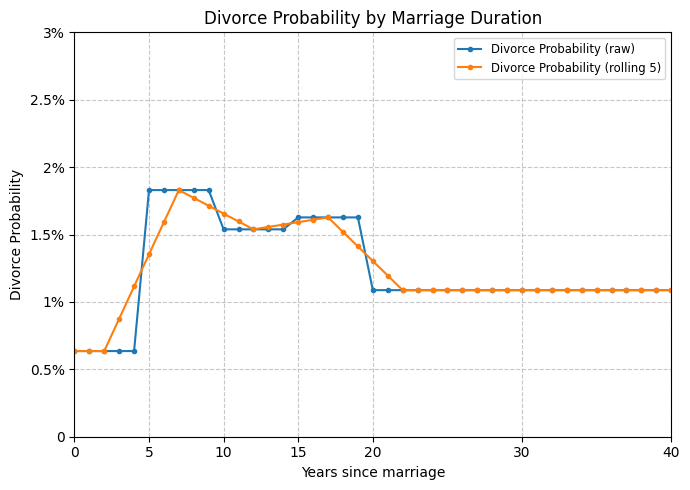

In [40]:
# Plot both the raw divorce_ratio and the rolling average on the same graph
rolling_windows = [5]
plt.figure(figsize=(7, 5))
plt.plot(divorce_ratio_by_year['year_since_marriage'], divorce_ratio_by_year['divorce_prob'], 
         label='Divorce Probability (raw)', marker='.')

for roll in rolling_windows:
    col_name = f'divorce_prob_roll{roll}'
    plt.plot(divorce_ratio_by_year['year_since_marriage'], divorce_ratio_by_year[col_name], 
             label=f'Divorce Probability (rolling {roll})', marker='.')
    
plt.title('Divorce Probability by Marriage Duration')
plt.xlabel('Years since marriage')
plt.ylabel('Divorce Probability')
plt.yticks(np.arange(0, 0.04, 0.005), ['0', '0.5%', '1%', '1.5%', '2%', '2.5%', '3%', '3.5%'])
plt.xticks([0,5,10,15,20,30,40], ['0', '5', '10', '15', '20', '30', '40'])
plt.xlim(0, 40)
plt.ylim(0, 0.03)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

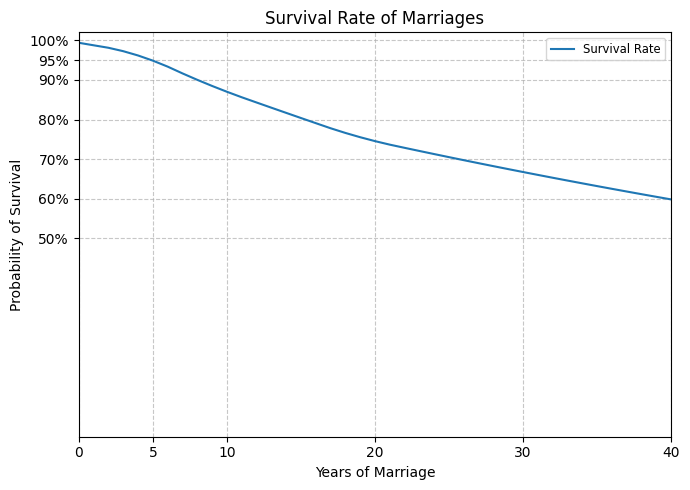

In [41]:
# PLOT MARRIAGE SURVIVAL RATE - AKA NO-DIVORCE PROBABILITY

plt.figure(figsize=(7, 5))

# Compute survival rates for each divorce probability column
probs = divorce_ratio_by_year['divorce_prob_roll5'].values
survival = [1.0]
for p in probs:
    survival.append(survival[-1] * (1 - p))
survival = survival[1:]

plt.plot(divorce_ratio_by_year['year_since_marriage'], survival, label='Survival Rate')

plt.xlabel('Years of Marriage')
plt.ylabel('Probability of Survival')
plt.title('Survival Rate of Marriages')
plt.ylim(0, 1.02)
plt.xlim(0, 40)
plt.xticks([0,5,10,20,30,40], ['0', '5', '10', '20', '30', '40'])
plt.yticks([.5,.6,.7,.8,.9,.95,1], ['50%', '60%', '70%', '80%', '90%', '95%', '100%'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

##### COUPLES SPLIT PROBABILITY #####

In [42]:
split_prob = divorce_ratio_by_year.copy()

# Apply the adjustment for year_since_marriage > 20 directly using vectorized operations
mask = split_prob['year_since_marriage'] > 20

split_prob.loc[mask, 'divorce_ratio'] = 1 /split_prob.loc[mask, 'year_since_marriage']/5

split_prob['split_ratio_roll'] = split_prob['divorce_ratio'].rolling(
    window=9, center=True, min_periods=1).mean()
split_prob['prob_of_split'] = split_prob['split_ratio_roll']*1.75

split_prob = split_prob.iloc[5:,[0,1,-1]]
split_prob['year_since_cohab'] = split_prob['year_since_marriage']-5
split_prob = split_prob[['year_since_cohab', 'prob_of_split']]

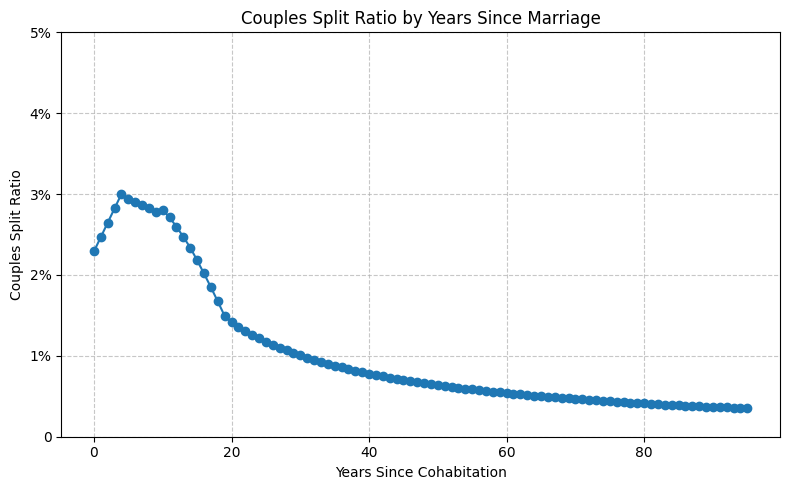

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(split_prob['year_since_cohab'], split_prob['prob_of_split'], marker='o')
plt.xlabel('Years Since Cohabitation')
plt.ylabel('Couples Split Ratio')
plt.yticks(np.arange(0, 0.055, 0.01), ['0', '1%', '2%', '3%', '4%', '5%'])
plt.title('Couples Split Ratio by Years Since Marriage')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

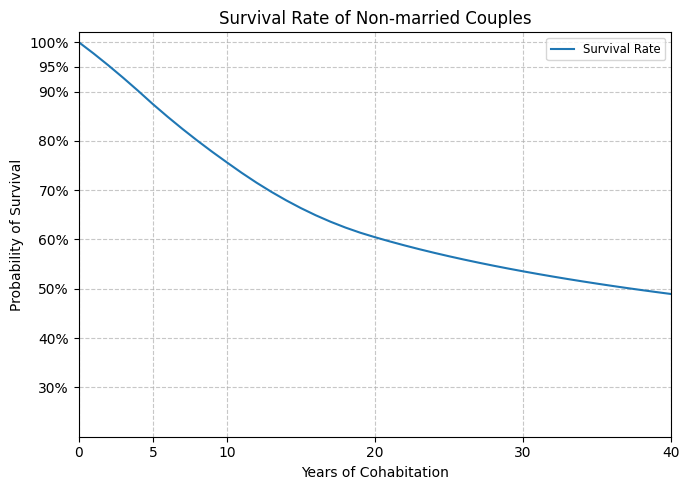

In [44]:
plt.figure(figsize=(7, 5))

# Compute survival rates for each divorce probability column
probs = (split_prob['prob_of_split'].values)
survival = [1.0]
for p in probs:
    survival.append(survival[-1] * (1 - p))
survival = survival[:-1]

plt.plot(split_prob['year_since_cohab'], survival, label='Survival Rate')

plt.xlabel('Years of Cohabitation')
plt.ylabel('Probability of Survival')
plt.title('Survival Rate of Non-married Couples')
plt.ylim(0.2, 1.02)
plt.xlim(0, 40)
plt.xticks([0,5,10,20,30,40], ['0', '5', '10', '20', '30', '40'])
plt.yticks([.3,.4,.5,.6,.7,.8,.9,.95,1], ['30%', '40%','50%', '60%', '70%', '80%', '90%', '95%', '100%'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

In [45]:
# decided to use assumption that couples split follows same mechanism as divorce 
# probability of splitting is the same as twice the probability of divorce

##### KID LEAVING THE HOUSE PROBABILITY #####

In [46]:
# Define known points including F(18) = 0
ages_known = [20, 25, 30]
F_known    = np.array([.26, .786, .966])
M_known    = np.array([.175, .616, .85])

# Ages where we want the per-year probabilities
ages = np.arange(18, 31)

# Linear interpolation of the cumulative distribution
F_interp = np.interp(ages, ages_known, F_known)
M_interp = np.interp(ages, ages_known, M_known)

# Calculate per-year unconditional leaving probabilities p(a) = F(a) - F(a-1)
F_prev = np.interp(ages - 1, ages_known, F_known)
M_prev = np.interp(ages - 1, ages_known, M_known)

p_year_f = F_interp - F_prev
p_year_m = M_interp - M_prev

# Create a DataFrame for easy viewing
df = pd.DataFrame({
    "age": ages,
    "cdf_f": np.round(F_interp, 4),
    "cdf_m": np.round(M_interp, 4),
})


# dataset obtained using linear interpolation (ABOVE) of BFS data on CDF of children leaving home, took data from 2018 
# selected only people born more recently (= 1988-2002)
# reverse engineered the pdf 
leave_house_df = pd.read_csv('data/derived_leaving_parent_house_sex_age.csv', delimiter=';', encoding='latin1')
leave_prob_w = leave_house_df.loc[leave_house_df.gender == 'F'].drop(columns='gender')
leave_prob_m = leave_house_df.loc[leave_house_df.gender == 'M'].drop(columns='gender')

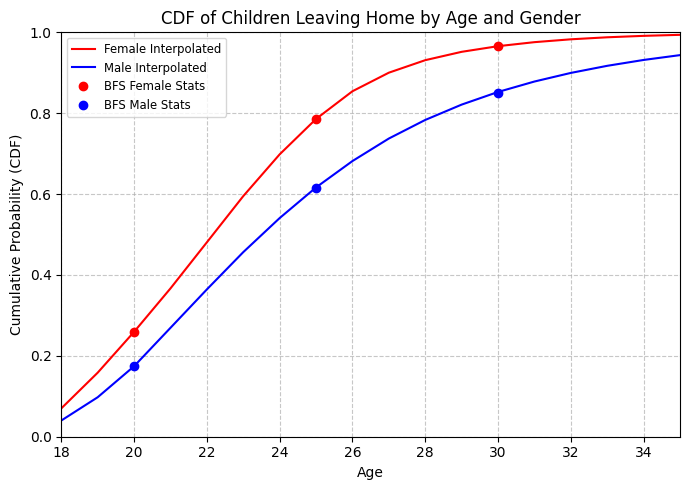

In [47]:
# plot the cdf of children leaving home for male and female 
# limit the x-axis to 18-35 years
plt.figure(figsize=(7, 5))
plt.plot(leave_prob_w['age'], leave_prob_w['cdf'], label='Female Interpolated', color='red')
plt.plot(leave_prob_m['age'], leave_prob_m['cdf'], label='Male Interpolated', color='blue')
plt.xlim(18, 35)
plt.ylim(0, 1)
plt.xlabel('Age')
plt.ylabel('Cumulative Probability (CDF)')
plt.title('CDF of Children Leaving Home by Age and Gender')
plt.grid(True, linestyle='--', alpha=0.7)

# Mark age 20, 25, and 30 with 'o'
# for age in [20, 25, 30]:
#     # Female
#     if age in leave_prob_w['age'].values:
#         y_f = leave_prob_w.loc[leave_prob_w['age'] == age, 'cdf'].values[0]
#         plt.plot(age, y_f, 'ro', markersize=8)
#     # Male
#     if age in leave_prob_m['age'].values:
#         y_m = leave_prob_m.loc[leave_prob_m['age'] == age, 'cdf'].values[0]
#         plt.plot(age, y_m, 'bo', markersize=8)

# Add marks for F_known and M_known at x = [20, 25, 30]
plt.plot([20, 25, 30], F_known, 'r.', markersize=12, label='BFS Female Stats')
plt.plot([20, 25, 30], M_known, 'b.', markersize=12, label='BFS Male Stats ')

plt.legend(fontsize='small', loc='upper left')
plt.tight_layout()
plt.show()



##### COUPLE FORMATION PROBABILITY #####

In [48]:
# Import the BFS data on CDF of people moving habving moved in at least once before age (x) 
# we interpolate the data 
# and we reverse engineer the PDF: per-year probabilities of moving in for each age 
# adjust (increase) to take into account that couple can break up so the person moves in again with different partner
# not accounted in the CDF 

cdf_move_in = pd.read_csv('data/bfs_moved_in_by_age_gender_2024.csv', delimiter=';')
cdf_move_in.rename(columns={'ï»¿age': 'age'}, inplace=True)

ages_known = [18,20, 25, 30, 35, 40]
F_known_cur = np.array(cdf_move_in.loc[cdf_move_in.gender == 'F', 'cdf'].values)
M_known_cur = np.array(cdf_move_in.loc[cdf_move_in.gender == 'M', 'cdf'].values)

# Ages where we want the per-year probabilities
ages = np.arange(18, 41)

# Linear interpolation of the cumulative distribution
F_interp = np.interp(ages, ages_known, F_known_cur)
M_interp = np.interp(ages, ages_known, M_known_cur)

# Calculate per-year unconditional leaving probabilities p(a) = F(a) - F(a-1)
F_prev = np.interp(ages - 1, ages_known, F_known_cur)
M_prev = np.interp(ages - 1, ages_known, M_known_cur)

p_year_f = F_interp - F_prev
p_year_m = M_interp - M_prev

# Create a DataFrame for easy viewing
df = pd.DataFrame({
    "age": ages,
    "cdf_f": np.round(F_interp, 4),
    "cdf_m": np.round(M_interp, 4),
})

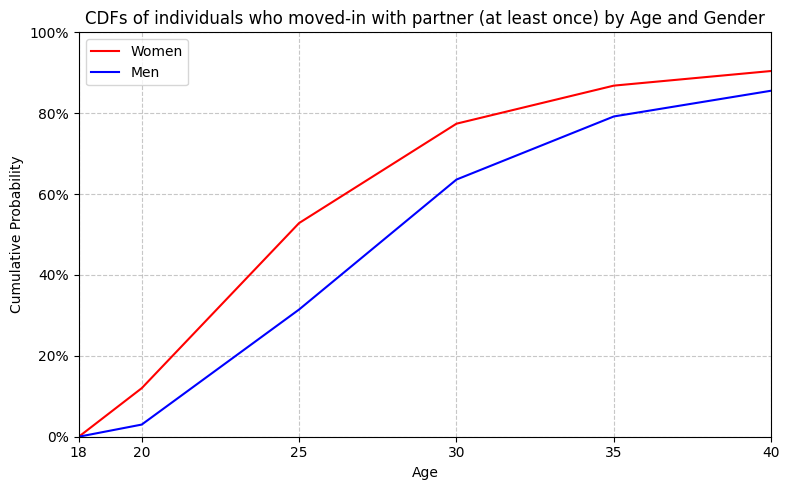

In [49]:
# PLOT CDFs of individuals who moved-in with partner (at least once) by Age and Gender

plt.figure(figsize=(8, 5))
plt.plot(df['age'], df['cdf_f'], label='Women', color='red')
plt.plot(df['age'], df['cdf_m'], label='Men', color='blue')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.xlim(18, 40)
plt.xticks([18,20,25,30,35,40], ['18', '20', '25', '30', '35', '40'])
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 20), ['0%', '20%', '40%', '60%', '80%', '100%'])
plt.title('CDFs of individuals who moved-in with partner (at least once) by Age and Gender')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

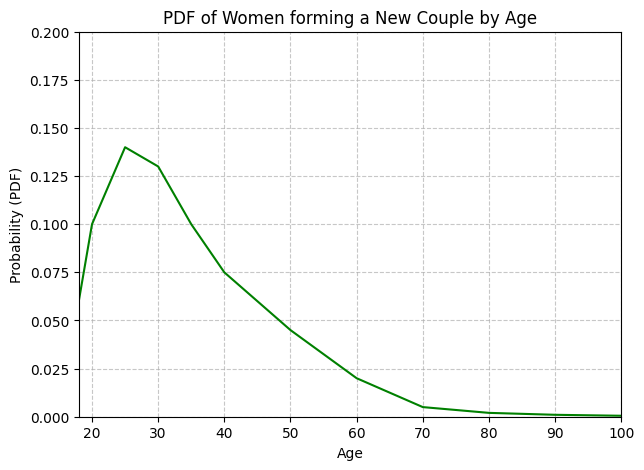

In [50]:
# Interpolate the PDF to get probabilities up to age 100

ages_known = [18,20,25,30,35,40,
              50,60,70,80,90,100]
F_pdf = np.array([0.06, 0.1, 0.14, 0.13, 0.1, 0.075,
                    .045, 0.02, 0.005, 0.002, 0.001, 0.0005])
ages = np.arange(18, 101)
F_interp = np.interp(ages, ages_known, F_pdf)

# Create a DataFrame for easy viewing
prob_f_new_couple = pd.DataFrame({
    "age": ages,
    "pdf": np.round(F_interp, 4)
})

# plot the cdf using F_interp
plt.figure(figsize=(7, 5))
plt.plot(ages, F_interp,
            label='PDF of Moving In (Interpolated)', color='green')
plt.xlim(18, 100)
plt.ylim(0, .2)
plt.xlabel('Age')
plt.ylabel('Probability (PDF)')
plt.title('PDF of Women forming a New Couple by Age')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### SIMULATIONS ###

##### Action Functions #####

In [51]:
# Birth

def birth(memberships_df, persons_df, household_id, date_of_birth):
    # Check if the household has 2 partners of different gender
    hh_members = get_hh_members_details_t(memberships_df, persons_df, household_id, date_of_birth)
    partners = hh_members.loc[hh_members['role'] == 'partner','gender']
    if len(partners) != 2:
        raise Exception("The household must be a couple to have a child.")
    if sorted(partners.tolist()) != ['F', 'M']:
        raise Exception("The couple must be F/M to have a child.")
    
    twins = random.choices([True, False], weights=[0.985, 0.015])[0]  

    # Generate a new person_id for the newborn
    new_person_id = memberships_df['person_id'].max() + 1
    gender = random.choices(['M', 'F'], weights=[0.5122, 0.4878])[0] 

    new_person_row = {
        'name': f'Baby_{new_person_id}',
        'birth': date_of_birth,
        'gender': gender,
        'death': 9999,
        'primary_hh': household_id}

    # Add a new row to the memberships_df for the newborn
    new_membership_row = {
        'person_id': new_person_id,
        'household_id': household_id,
        'start_date': date_of_birth,
        'end_date': 9999,
        'role': 'child',
        'leave_cause': None,
        'marital_status': 1,
        'marriage_date': 9999}

    # Append the new person row to the persons_df
    persons_df.loc[new_person_id] = new_person_row

    # Append the new membership row to the memberships_df
    memberships_df.loc[membership_id_str(new_person_id, household_id)] = new_membership_row

    if twins==True:
        # Generate a new person_id for the newborn
        new_person_id_2 = memberships_df['person_id'].max() + 1
        gender_2 = random.choices(['M', 'F'], weights=[0.5122, 0.4878])[0]  

        new_person_row_2 = {
            'name': f'Baby_{new_person_id_2}',
            'birth': date_of_birth,
            'gender': gender_2,
            'death': 9999,
            'primary_hh': household_id}

        # Add a new row to the memberships_df for the newborn
        new_membership_row_2 = {
            'person_id': new_person_id_2,
            'household_id': household_id,
            'start_date': date_of_birth,
            'end_date': 9999,
            'role': 'child',
            'leave_cause': None,
            'marital_status': 1,
            'marriage_date': 9999}

        # Append the new person row to the persons_df
        persons_df.loc[new_person_id_2] = new_person_row_2

        # Append the new membership row to the memberships_df
        memberships_df.loc[membership_id_str(new_person_id_2, household_id)] = new_membership_row_2
        
    return
    


In [52]:
# Death & related functions

def death(memberships_df, persons_df, households_df, person_id, date_of_death):
    # Check if the person memberships is the last one and currently open in membership_df    
    household_id = get_pers_hh_id_t(memberships_df, person_id, date_of_death)
    current_membership_id = membership_id_str(person_id, household_id)
    
    # check if the person was the last member of the household
    if last_member_check(memberships_df, household_id, person_id, date_of_death):
        households_df.loc[household_id, ['hh_end', 'end_cause']] = [date_of_death,'death last member']

    if last_parent_check(memberships_df, household_id, person_id, date_of_death):
        # TODO
        # CHECK if all other members are children and if all children are minors 
        # if all children are minors move them to a new household (adoption) 
        # else set oldest children as 'single' (act as parent)
        pass

    if partner_death_check(memberships_df, person_id, date_of_death):
        # change marital status of the partner to 'single' = 1 (CHECK)
        hh_members = get_pers_hh_memberships_t(memberships_df, person_id, date_of_death)
        partner_id = hh_members.loc[(hh_members['person_id'] != person_id) & 
                                    (hh_members['role'] == 'partner'), 'person_id'].values[0]
        memberships_df.loc[membership_id_str(partner_id, household_id), 'role'] = 'single'

    if married_death_check(memberships_df, person_id, date_of_death):
        # change marital status of the spouse to 'widowed' = 3 (CHECK)
        hh_members = get_pers_hh_memberships_t(memberships_df, person_id, date_of_death)
        spouse_id = hh_members.loc[(hh_members['person_id'] != person_id) & 
                                   (hh_members['marital_status'] == 2), 'person_id'].values[0]
        memberships_df.loc[membership_id_str(spouse_id, household_id), 'marital_status'] = 3

    # End person's current membership in memberships_df
    memberships_df.loc[current_membership_id, ['end_date','leave_cause']] = [date_of_death, 'death']
    
    # Change the death date of the person in persons_df
    persons_df.loc[person_id, 'death'] = date_of_death

    return


def married_death_check(memberships_df, person_id, date):
    """
    Check if the person is married at the given date and there is another partner in the household
    """
    hh_members = get_pers_hh_memberships_t(memberships_df, person_id, date)
    # Check if the person is married and has a partner in the household
    if hh_members.loc[hh_members['person_id'] == person_id, 'marital_status'].values[0] == 2:
        # Check if there is another partner in the household
        return hh_members[hh_members['marital_status'] == 2].shape[0] > 1
    else:
        # If the person is not a partner, they are not married
        return False
    
def partner_death_check(memberships_df, person_id, date):
    """
    Check if the person is married at the given date and there is another partner in the household
    """
    hh_members = get_pers_hh_memberships_t(memberships_df, person_id, date)
    # Check if the person is married and has a partner in the household
    if hh_members.loc[hh_members['person_id'] == person_id, 'role'].values[0] == 'partner':
        # Check if there is another partner in the household
        return hh_members[hh_members['role'] == 'partner'].shape[0] > 1
    else:
        # If the person is not a partner, they are not married
        return False
    
def last_member_check(memberships_df, household_id, person_id, date):
    """
    Check if the person is the last member of the household at the given date.
    """
    hh_members_ids = get_hh_members_ids_t(memberships_df, household_id, date)

    # Check if the person is the only member in the household
    return hh_members_ids == [person_id]

def last_parent_check(memberships_df, household_id, person_id, date):
    """
    Check if the person is the last parent of the household at the given date.
    """
    hh_members = get_hh_memberships_t(memberships_df, household_id, date)
    parents = hh_members[hh_members['role'] == 'partner']
    children = hh_members[hh_members['role'] == 'child']
    # Check if the person is a parent and if they are the last parent in the household
    if person_id in parents['person_id'].values and len(parents) == 1 and len(children) > 0:
        return True


In [53]:
# New couple and marriage + related functions

# Check if both persons are single (not married or in a couple)
# first create kids move out of the house function --> ow we need to create manually a new membership entry for the child

# TODO: allow divorced indiviudals to form a new couple --> join households with children if present
# for the moment only filter for single individuals with NO past marriages (marital_status == 1), change that 

def both_single(memberships_df, person_id_1, person_id_2, date):
    # Check if both persons belong to households without 2 partners in it
    person_1_membership = get_pers_membership_t(memberships_df, person_id_1, date)
    person_2_membership = get_pers_membership_t(memberships_df, person_id_2, date)

    person_1_single = person_1_membership['role'].values[0] == 'single' and person_1_membership['marital_status'].values[0] !=2
    person_2_single = person_2_membership['role'].values[0] == 'single' and person_2_membership['marital_status'].values[0] !=2

    return person_1_single and person_2_single

def siblings(persons_df, person_id_1, person_id_2):
    # Check if persons are siblings using the primary_hh field
    check = int(persons_df.loc[person_id_1, 'primary_hh']) == int(persons_df.loc[person_id_2, 'primary_hh'])
    return check

def same_sex(persons_df, person_id_1, person_id_2):
    # Check if the two individuals have different sex
    return persons_df.loc[person_id_1, 'gender'] != persons_df.loc[person_id_2, 'gender']

def new_couple(memberships_df, households_df, persons_df, person_id_1, person_id_2, date_new_couple):

    # Check if both persons are single
    if both_single(memberships_df, person_id_1, person_id_2, date_new_couple) == False:
        raise Exception("Both persons must be single to form a new couple.")
    
    # Check if persons are siblings
    if siblings(persons_df, person_id_1, person_id_2) == True:
        raise Exception("Persons cannot be siblings to form a new couple.")

    old_memb_1 = get_pers_membership_t(memberships_df, person_id_1, date_new_couple)
    old_memb_2 = get_pers_membership_t(memberships_df, person_id_2, date_new_couple)

    person_1_ms, person_1_old_hh = old_memb_1['marital_status'].values[0], old_memb_1['household_id'].values[0]
    person_2_ms, person_2_old_hh = old_memb_2['marital_status'].values[0], old_memb_2['household_id'].values[0]

    # Create a new household for the couple
    new_household_id = households_df.index.max() + 1
    
    # SUBSTITUTE WITH THIS ONCE WE SYNC MEMBERSHIPS AND HOUSEHOLDS DF
    # new_household_id = int(memberships_df['household_id'].unique().max()) + 1
    
    new_household_row = {
        'household_id': new_household_id,
        'hh_start': date_new_couple,
        'hh_end': 9999,
        'end_cause': None
        }

    # Update the memberships_df for the new couple
    new_membership_row_1 = {
        'person_id': person_id_1,
        'household_id': new_household_id,
        'start_date': date_new_couple,
        'end_date': 9999,
        'role': 'partner',
        'leave_cause': None, 
        'marital_status': person_1_ms,
        'marriage_date': 9999}
    
    new_membership_row_2 = {
        'person_id': person_id_2,
        'household_id': new_household_id,
        'start_date': date_new_couple,
        'end_date': 9999,
        'role': 'partner',
        'leave_cause': None,
        'marital_status': person_2_ms,
        'marriage_date': 9999}
    
    if has_children(memberships_df, person_1_old_hh, date_new_couple):
        # If person 1 has children, move them to the new household
        children_ids_1 = get_hh_children_ids(memberships_df, person_1_old_hh, date_new_couple)

        for child_id in children_ids_1:

            memberships_df.loc[(memberships_df['person_id'] == child_id) & 
                               (memberships_df['end_date'] == 9999), ('end_date','leave_cause')] = date_new_couple, 'parent joined new couple'
            
            new_membership_row_child = {
                'person_id': child_id,
                'household_id': new_household_id,
                'start_date': date_new_couple,
                'end_date': 9999,
                'role': 'child',
                'leave_cause': None,
                'marital_status': 1,  # Assuming children are always single
                'marriage_date': 9999}
            memberships_df.loc[membership_id_str(child_id, new_household_id)] = new_membership_row_child

    if has_children(memberships_df, person_2_old_hh, date_new_couple):
        # If person 2 has children, move them to the new household
        children_ids_2 = get_hh_children_ids(memberships_df, person_2_old_hh, date_new_couple)
        for child_id in children_ids_2:

            memberships_df.loc[(memberships_df['person_id'] == child_id) & 
                               (memberships_df['end_date'] == 9999), ('end_date','leave_cause')] = date_new_couple, 'parent joined new couple'
            
            new_membership_row_child = {
                'person_id': child_id,
                'household_id': new_household_id,
                'start_date': date_new_couple,
                'end_date': 9999,
                'role': 'child',
                'leave_cause': None,
                'marital_status': 1,  # Assuming children are always single
                'marriage_date': 9999}
            memberships_df.loc[membership_id_str(child_id, new_household_id)] = new_membership_row_child
    
    # Change end date of the old households of the couple and their memberships in the single households
    memberships_df.loc[(memberships_df['person_id'] == person_id_1) &
                       (memberships_df['end_date'] == 9999), ('end_date','leave_cause')] = date_new_couple, 'new couple'
    memberships_df.loc[(memberships_df['person_id'] == person_id_2) & 
                       (memberships_df['end_date'] == 9999), ('end_date','leave_cause')] = date_new_couple, 'new couple'
    
    households_df.loc[person_1_old_hh, ['hh_end', 'end_cause']] = date_new_couple, 'new couple'
    households_df.loc[person_2_old_hh, ['hh_end', 'end_cause']] = date_new_couple, 'new couple'
        
    households_df.loc[new_household_id] = new_household_row
    memberships_df.loc[membership_id_str(person_id_1, new_household_id)] = new_membership_row_1
    memberships_df.loc[membership_id_str(person_id_2, new_household_id)] = new_membership_row_2

    return


def has_children(memberships_df, household_id, date):
    """
    Check if the household has children at the given date.
    """
    hh_members = get_hh_memberships_t(memberships_df, household_id, date)
    # Check if there are any children in the household
    return hh_members[hh_members['role'] == 'child'].shape[0] > 0

def both_unmarried(memberships_df, person_id_1, person_id_2, date_marriage):
    """
    Check if both persons are unmarried (not married or in a couple) at the given date.
    """
    person_1_membership = get_pers_membership_t(memberships_df, person_id_1, date_marriage)
    person_2_membership = get_pers_membership_t(memberships_df, person_id_2, date_marriage)

    # Check if both persons have 'single' role
    return (person_1_membership['marital_status'].values[0] != 2 and 
            person_2_membership['marital_status'].values[0] != 2)


def in_couple_open(memberships_df, person_id_1, person_id_2, date_marriage):
    """
    Check if both persons are in an active couple at the given date.
    """
    person_1_membership = get_pers_membership_t(memberships_df, person_id_1, date_marriage)
    person_2_membership = get_pers_membership_t(memberships_df, person_id_2, date_marriage)

    # Check if both persons have 'partner' role in the same household
    return (is_membership_open(memberships_df, person_1_membership.index[0]) and 
            is_membership_open(memberships_df, person_2_membership.index[0]) and
            person_1_membership['role'].values[0] == 'partner' and 
            person_2_membership['role'].values[0] == 'partner' and 
            person_1_membership['household_id'].values[0] == person_2_membership['household_id'].values[0])


def marriage(memberships_df, person_id_1, person_id_2, date_marriage):
    
    # Check if persons are siblings
    if not in_couple_open(memberships_df, person_id_1, person_id_2, date_marriage):
        raise Exception("Persons must be a couple to get married.")
    
    # Check if both persons are single
    if not both_unmarried(memberships_df, person_id_1, person_id_2, date_marriage):
        raise Exception("Both persons must be single to get married.")

    # Create a new membership_df row to change the marital_status + add marriage_date --> set partners as married 
    household_id = get_pers_hh_id_t(memberships_df, person_id_1, date_marriage)

    memberships_df.loc[membership_id_str(person_id_1, household_id), ('marital_status', 'marriage_date')] = (2, date_marriage)
    memberships_df.loc[membership_id_str(person_id_2, household_id), ('marital_status', 'marriage_date')] = (2, date_marriage)

    return

In [54]:
# Divorce function

def already_married(memberships_df, household_id, date):
    membership_hh = get_hh_memberships_t(memberships_df, household_id, date)
    partners = int((membership_hh['marital_status'] == 2).sum())
    return partners == 2

def divorce(memberships_df, households_df, persons_df, household_id, date_of_divorce):
    # Check if the household is a couple household

    if already_married(memberships_df, household_id, date_of_divorce) == False:
        raise Exception("The household must be a couple household to divorce.")
    
    # get all the members of the household
    members = get_hh_members_details_t(memberships_df, persons_df, household_id, date_of_divorce)
    members.sort_values(by='gender', inplace=True)
    
    # check if they have children in the household or not --> get all members with role 'child'
    children_ids = get_hh_children_ids(memberships_df, household_id, date_of_divorce)
    with_children = len(children_ids) > 0
    
    if with_children == True:
        partners = members.loc[~members['person_id'].isin(children_ids)]
        wife_id = partners.iloc[0, 0] 
        husband_id = partners.iloc[1, 0] 

    else: 
        wife_id = members.iloc[0, 0] 
        husband_id = members.iloc[1, 0] 


    # create 2 new households (one per partner) with start date, date of divorce (end date: 9999)
    new_household_id_wife = households_df.index.max() + 1
    new_household_id_husband = households_df.index.max() + 2
    new_household_row_wife = {
        'hh_start': date_of_divorce,
        'hh_end': 9999,
        'end_cause': None
    }
    new_household_row_husband = {
        'hh_start': date_of_divorce,
        'hh_end': 9999,
        'end_cause': None
    }

    # change end_cause column in households_df to 'divorce'
    households_df.loc[household_id, 'end_cause'] = 'divorce'

    # change end date of the old household in households_df to date of divorce
    households_df.loc[household_id, 'hh_end'] = date_of_divorce
    
    # Add the new households to the households_df
    households_df.loc[new_household_id_wife] = new_household_row_wife
    households_df.loc[new_household_id_husband] = new_household_row_husband

    # change memberships_df row with old household_id and persons_id to end at the date of divorce and have as leave_cause 'divorce'
    memberships_df.loc[(memberships_df['household_id'] == household_id) &
                       (memberships_df['person_id'] == wife_id) &
                       (memberships_df['end_date'] == 9999), ['end_date', 'leave_cause']] = date_of_divorce, 'divorce'
    memberships_df.loc[(memberships_df['household_id'] == household_id) &
                       (memberships_df['person_id'] == husband_id) &
                       (memberships_df['end_date'] == 9999), ['end_date', 'leave_cause']] = date_of_divorce, 'divorce'
   
    # create new memberships_df row with new household_id and persons_id starting at the date of divorce end date: 9999
        #if they have children, assign them to mother with 90% probability 
    
    new_membership_row_husband = {
        'person_id': husband_id,
        'household_id': new_household_id_husband,
        'start_date': date_of_divorce,
        'end_date': 9999,
        'role': 'single',
        'leave_cause': None,
        'marital_status': 4,  # set marital status to 'divorced'
        'marriage_date': 9999  # set marriage date to None
    }
    new_membership_id_husband = membership_id_str(husband_id, new_household_id_husband)

    new_membership_row_wife = {
        'person_id': wife_id,
        'household_id': new_household_id_wife,
        'start_date': date_of_divorce,
        'end_date': 9999,
        'role': 'single',
        'leave_cause': None,
        'marital_status': 4,  # set marital status to 'divorced'
        'marriage_date': 9999  # set marriage date to None
    }
    new_membership_id_wife = membership_id_str(wife_id, new_household_id_wife)

    if with_children == True:

        # end assignment of children to old household AND create new membership to new household with the mother
        memberships_df.loc[(memberships_df['household_id'] == household_id) &
                            (memberships_df['person_id'].isin(children_ids)) &
                            (memberships_df['end_date'] == 9999), ['end_date','leave_cause']] = date_of_divorce, 'divorce'

        if random.choices([True, False], weights=[0.89, 0.11])[0] == True:
            household_id_kids = new_household_id_wife
        else:
            household_id_kids = new_household_id_husband

        for child_id in children_ids:
            new_membership_row_child = {
                'person_id': child_id,
                'household_id': household_id_kids,
                'start_date': date_of_divorce,
                'end_date': 9999,
                'role': 'child',
                'leave_cause': None, 
                'marital_status': 1,  # set marital status to 'single'
                'marriage_date': 9999  # set marriage date to None
            }
            new_membership_id_child = membership_id_str(child_id, household_id_kids)
            # Append the new membership row for the child to the memberships_df
            memberships_df.loc[new_membership_id_child] = new_membership_row_child

    # add the new memberships_df rows for husband and wife to the memberships_df
    memberships_df.loc[new_membership_id_husband] = new_membership_row_husband
    memberships_df.loc[new_membership_id_wife] = new_membership_row_wife
    return 


In [55]:
# Couple_split function 
# --> same as divorce but not setting marital status to 4 = divorced, just changing the household

def already_couple(memberships_df, household_id, date):
    membership_hh = get_hh_memberships_t(memberships_df, household_id, date)
    partners = int((membership_hh['role'] == 'partner').sum())
    return partners == 2

def couple_split(memberships_df, households_df, persons_df, household_id, date_of_split):
    # Check if the household is a couple household
    if already_couple(memberships_df, household_id, date_of_split) == False:
        print("Household ID NOT COUPLE!!!:", household_id)
        raise Exception("The household must be a couple household to couple_split.")
    
    # get all the members of the household
    members = get_hh_members_details_t(memberships_df, persons_df, household_id, date_of_split)
    members.sort_values(by='gender', inplace=True)

    # check if they have children in the household or not --> get all members with role 'child'
    children_ids = get_hh_children_ids(memberships_df, household_id, date_of_split)
    with_children = len(children_ids) > 0
    
    if with_children == True:
        partners = members.loc[~members['person_id'].isin(children_ids)]
        wife_id = partners.iloc[0, 0] 
        husband_id = partners.iloc[1, 0] 

    else: 
        wife_id = members.iloc[0, 0] 
        husband_id = members.iloc[1, 0] 


    # create 2 new households (one per partner) with start date, date_of_split (end date: 9999)
    new_household_id_wife = households_df.index.max() + 1
    new_household_id_husband = households_df.index.max() + 2
    new_household_row_wife = {
        'hh_start': date_of_split,
        'hh_end': 9999,
        'end_cause': None
    }
    new_household_row_husband = {
        'hh_start': date_of_split,
        'hh_end': 9999,
        'end_cause': None
    }

    # change end_cause column in households_df to 'date_of_split'
    households_df.loc[household_id, 'end_cause'] = 'couple split'

    # change end date of the old household in households_df to date of date_of_split
    households_df.loc[household_id, 'hh_end'] = date_of_split
    # Add the new households to the households_df
    households_df.loc[new_household_id_wife] = new_household_row_wife
    households_df.loc[new_household_id_husband] = new_household_row_husband

    # change memberships_df row with old household_id and persons_id to end at the date of date_of_split
    memberships_df.loc[(memberships_df['household_id'] == household_id) &
                       (memberships_df['person_id'] == wife_id) &
                       (memberships_df['end_date'] == 9999), 'end_date'] = date_of_split
    memberships_df.loc[(memberships_df['household_id'] == household_id) &
                       (memberships_df['person_id'] == husband_id) &
                       (memberships_df['end_date'] == 9999), 'end_date'] = date_of_split

    # change end_cause column in memberships_df to 'date_of_split'
    memberships_df.loc[(memberships_df['household_id'] == household_id) &
                       (memberships_df['person_id'] == wife_id) &
                          (memberships_df['end_date'] == date_of_split), 'leave_cause'] = 'couple split'
    memberships_df.loc[(memberships_df['household_id'] == household_id) &
                          (memberships_df['person_id'] == husband_id) &
                            (memberships_df['end_date'] == date_of_split), 'leave_cause'] = 'couple split'
    
    # get marital status of husband and wife in the old household
    husband_marital_status = memberships_df.loc[membership_id_str(husband_id, household_id), 'marital_status']
    wife_marital_status = memberships_df.loc[membership_id_str(wife_id, household_id), 'marital_status']
   
    # create new memberships_df row with new household_id and persons_id starting at the date of date_of_split end date: 9999
        #if they have children, the children stay with the mother --> assign them to mother's household

    new_membership_row_husband = {
        'person_id': husband_id,
        'household_id': new_household_id_husband,
        'start_date': date_of_split,
        'end_date': 9999,
        'role': 'single',
        'leave_cause': None,
        'marital_status': husband_marital_status,  
        'marriage_date': 9999  # set marriage date to None
    }
    new_membership_id_husband = membership_id_str(husband_id, new_household_id_husband)

    new_membership_row_wife = {
        'person_id': wife_id,
        'household_id': new_household_id_wife,
        'start_date': date_of_split,
        'end_date': 9999,
        'role': 'single',
        'leave_cause': None,
        'marital_status': wife_marital_status,  
        'marriage_date': 9999  # set marriage date to None
    }
    new_membership_id_wife = membership_id_str(wife_id, new_household_id_wife)

    if with_children == True:

        # end assignment of children to old household AND create new membership to new household with the mother
        memberships_df.loc[(memberships_df['household_id'] == household_id) &
                            (memberships_df['person_id'].isin(children_ids)) &
                            (memberships_df['end_date'] == 9999), ['end_date','leave_cause']] = date_of_split, 'parent couple split'

        if random.choices([True, False], weights=[0.89, 0.11])[0] == True:
            household_id_kids = new_household_id_wife
        else:
            household_id_kids = new_household_id_husband

        for child_id in children_ids:
            new_membership_row_child = {
                'person_id': child_id,
                'household_id': household_id_kids,
                'start_date': date_of_split,
                'end_date': 9999,
                'role': 'child',
                'leave_cause': None, 
                'marital_status': 1,  # set marital status to 'single'
                'marriage_date': 9999  # set marriage date to None
            }
            new_membership_id_child = membership_id_str(child_id, household_id_kids)
            # Append the new membership row for the child to the memberships_df
            memberships_df.loc[new_membership_id_child] = new_membership_row_child

    # add the new memberships_df rows for husband and wife to the memberships_df
    memberships_df.loc[new_membership_id_husband] = new_membership_row_husband
    memberships_df.loc[new_membership_id_wife] = new_membership_row_wife
    return 


In [56]:
# Kids leaving the house function
def kid_leaving(memberships_df, households_df, person_id, date_of_leaving):
    
    household_id = get_pers_hh_id_t(memberships_df, person_id, date_of_leaving)

    # check if the person was the last member of the household
    if last_member_check(memberships_df, household_id, person_id, date_of_leaving):
        households_df.loc[household_id, ['hh_end', 'end_cause']] = [date_of_leaving,'last kid leaving']
    
    # Change the end date of the person's membership in memberships_df
    memberships_df.loc[(memberships_df['household_id'] == household_id) &
                       (memberships_df['person_id'] == person_id) &
                       (memberships_df['end_date'] == 9999), ['end_date', 'leave_cause']] = date_of_leaving, 'kid leaving'

    # Create a new household for the child
    new_household_id_1 = households_df.index.max() + 1
    new_household_row = {
        'hh_start': date_of_leaving,
        'hh_end': 9999,
        'end_cause': None
    }
    households_df.loc[new_household_id_1] = new_household_row

    # Update the memberships_df for the child
    new_membership_row = {
        'person_id': person_id,
        'household_id': new_household_id_1,
        'start_date': date_of_leaving,
        'end_date': 9999,
        'role': 'single',
        'leave_cause': None,
        'marital_status': 1,  # set marital status to 'single'
        'marriage_date': 9999  # set marriage date to None
    }
    new_membership_id = membership_id_str(person_id, new_household_id_1)
    memberships_df.loc[new_membership_id] = new_membership_row

    return


##### Simulation Functions #####

In [57]:
# SIMULATION OF BIRTHS - MARRIED WOMEN 

def births_married_sim(memberships_df, persons_df, households_df, current_date):
    
    pop = get_available_actions(memberships_df, persons_df, current_date)

    #  change names here and put it into production 
    married_women = pop.loc[(pop['role'] == 'partner') & (pop['gender'] == 'F') & (pop['partners_in_hh'] == 2) & (pop['marital_status'] == 2)]
    married_couples_hh_id = married_women.household_id.unique()
    married_men = pop.loc[pop['household_id'].isin(married_couples_hh_id) & (pop['gender'] == 'M') & (pop['role'] == 'partner')]
    # married_men.set_index('household_id')['age'].to_dict()
    mask = (pop['role'] == 'partner') & (pop['gender'] == 'F') & (pop['partners_in_hh'] == 2) & (pop['marital_status'] == 2)
    husband_ages = married_men.set_index('household_id')['age']

    married_women.loc[:,'husband_age'] = married_women.loc[:,'household_id'].map(husband_ages)

    # then merge married_women with birth probability data and draw births accordingly (age of husband, age of wife, parity)
    # do the same for non-married women (single mothers)

    married_women['wife_age_group'] = pd.cut(married_women['age'],
                                            bins=birth_age_bins_w, 
                                                labels=birth_age_labels_w, right=False)
    married_women['husband_age_group'] = pd.cut(married_women['husband_age'],
                                                bins=birth_age_bins_m,
                                                labels=birth_age_labels_m, right=False)  
    married_women['parity'] = pd.cut(married_women['children_in_hh'],
                                    bins=[0, 1, 2, 3, 100],
                                    labels=['0', '1', '2', '3+'], right=False)

    draw_births = married_women[['household_id', 'person_id', 'age', 'husband_age', 'wife_age_group',
                                    'husband_age_group','birth_av', 'parity']].merge(
                                                                birth_probability,
                                                                left_on=['husband_age_group', 'wife_age_group', 'parity'],
                                                                right_on=['husband_age_group', 'wife_age_group', 'parity'],
                                                                how='left' )

    # Simulate births for each person in draw_births based on their prob_birth
    draw_births['simulated_birth'] = np.random.rand(len(draw_births)) < draw_births['p_hat_binom']

    birth_hh_id_list = draw_births.loc[draw_births['simulated_birth'], 'household_id'].tolist()

    aaa = len(birth_hh_id_list)
    print(f"\n{aaa} BIRTHS to simulate in {current_date}" )

    for i, hh_id in enumerate(tqdm(birth_hh_id_list, desc="Simulating births", unit="birth")):
        birth(memberships_df, persons_df, hh_id, current_date)

    return draw_births

In [58]:
# SIMULATION OF BIRTHS - UNMARRIED WOMEN

def births_unmarried_sim(memberships_df, persons_df, households_df, current_date):
    pop = get_available_actions(memberships_df, persons_df, current_date)

    #  change names here and put it into production 
    unmarried_women = pop.loc[(pop['role'] == 'partner') & (pop['gender'] == 'F') & (pop['partners_in_hh'] == 2) & 
                            (pop['marital_status'] != 2)]
    unmarried_couples_hh_id = unmarried_women.household_id.unique()
    unmarried_men = pop.loc[pop['household_id'].isin(unmarried_couples_hh_id) & (pop['gender'] == 'M') & (pop['role'] == 'partner')]
    # unmarried_men.set_index('household_id')['age'].to_dict()
    mask = (pop['role'] == 'partner') & (pop['gender'] == 'F') & (pop['partners_in_hh'] == 2) & (pop['marital_status'] == 2)
    m_ages = unmarried_men.set_index('household_id')['age']

    unmarried_women.loc[:,'m_age'] = unmarried_women.loc[:,'household_id'].map(m_ages)

    # then merge unmarried_women with birth probability data and draw births accordingly (age of husband, age of wife, parity)
    # do the same for non-married women (single mothers)

    unmarried_women['w_age_group'] = pd.cut(unmarried_women['age'],
                                            bins=birth_age_bins_w, 
                                                labels=birth_age_labels_w, right=False)
    unmarried_women['m_age_group'] = pd.cut(unmarried_women['m_age'],
                                                bins=birth_age_bins_m,
                                                labels=birth_age_labels_m, right=False)  

    draw_births_unmarried = unmarried_women[['household_id', 'person_id', 'age', 'm_age', 'w_age_group',
                                    'm_age_group','birth_av']].merge(
                                                                unmarried_birth_probability,
                                                                left_on=['m_age_group', 'w_age_group'],
                                                                right_on=['m_age_group', 'w_age_group'],
                                                                how='left' )

    # Simulate births for each person in draw_births_unmarried based on their prob_birth
    draw_births_unmarried['simulated_birth'] = np.random.rand(len(draw_births_unmarried)) < draw_births_unmarried['p_hat_binom']

    birth_hh_id_list = draw_births_unmarried.loc[draw_births_unmarried['simulated_birth'], 'household_id'].tolist()

    aaa = len(birth_hh_id_list)
    print(f"\n{aaa} BIRTHS (unmarried) to simulate in {current_date}")

    for i, hh_id in enumerate(tqdm(birth_hh_id_list, desc="Simulating births", unit="birth")):
        birth(memberships_df, persons_df, hh_id, current_date)

    return draw_births_unmarried

In [59]:
# SIMULATION OF KIDS LEAVING THE HOUSE

def kids_leave_sim(memberships_df, persons_df, households_df, current_date):
    
    pop = get_available_actions(memberships_df, persons_df, current_date)

    # Get all children in households
    children_in_hh = pop.loc[(pop['role'] == 'child') & (pop['age'] >= 18)]
    children_in_hh['age'] = children_in_hh['age'].apply(lambda x: min(x,70))  # we have probabilities only for ages 0-70

    draw_kids_leaving = children_in_hh[['person_id','household_id','birth','gender','age']].merge(
        leave_house_df, on=['gender','age'], how='left').drop(columns=['cdf'])

    # Simulate kids_leaving for each kid in draw_kids_leaving based on their pdf of leaving the house
    draw_kids_leaving['simulated_kid_leaving'] = np.random.rand(len(draw_kids_leaving)) < draw_kids_leaving['pdf']

    kids_leaving_id_list = draw_kids_leaving.loc[draw_kids_leaving['simulated_kid_leaving'], 'person_id'].to_list()

    aaa = len(kids_leaving_id_list)
    print(f"\n{aaa} KIDS LEAVING to simulate in {current_date}")
    
    for _, person_id in enumerate(tqdm(kids_leaving_id_list, desc="Simulating kids leaving", unit="kid_leaving")):
        kid_leaving(memberships_df, households_df, person_id, current_date)

    return

In [60]:
# SIMULATION OF NEW COUPLES

def new_couples_sim(memberships_df, persons_df, households_df, current_date):

    pop = get_available_actions(memberships_df, persons_df, current_date)

    # Import age_difference probabilities and bins
    age_diff_df = pd.read_csv('data/bfs_couples_age_diff_2013.csv', delimiter=';', encoding='latin1')
    age_diff_bins = np.sort(age_diff_df['age_diff_ub'].to_list() + [-200])
    age_diff_labels = age_diff_df['age_diff_label'].to_list()[::-1]

    single_women = pop.loc[(pop['role'] == 'single') & (pop['marital_status'] != 2) &
                            (pop['age'] >= 18) & (pop['gender'] == 'F')]
    single_men = pop.loc[(pop['role'] == 'single') & (pop['marital_status'] != 2) &
                            (pop['age'] >= 18) & (pop['gender'] == 'M')]

    single_women['age'] = single_women['age'].apply(lambda x: min(x,100))  # we have probabilities only for ages 0-100

    women_draw_new_couples = single_women.merge(prob_f_new_couple, on='age', how='left')
    women_draw_new_couples['simulated_new_couple'] = np.random.rand(len(women_draw_new_couples)) < women_draw_new_couples['pdf']

    women_to_match = women_draw_new_couples.loc[women_draw_new_couples['simulated_new_couple']]


    aaa = len(women_to_match)
    print(f"\n{aaa} NEW COUPLES to simulate in {current_date}")

    for _, row in tqdm(women_to_match.iterrows(), total=aaa, desc="Simulating new couples", unit="new_couple"):
        w_person_id = row['person_id']
        w_age = row['age']
        w_primary_hh = row['primary_hh']
        
        # Get a random partner
        potential_partners = single_men.loc[single_men['primary_hh'] != w_primary_hh]
        if potential_partners.empty:
            continue  # No potential partners available

        potential_partners['age_diff_w'] = potential_partners['age'] - w_age
        potential_partners['age_diff_group'] = pd.cut(potential_partners['age_diff_w'],
                                                    bins=age_diff_bins,
                                                    labels=age_diff_labels, right=False)
        
        available_age_diff = potential_partners['age_diff_group'].unique().tolist()

        indices = [age_diff_df['age_diff_label'].tolist().index(label) for label in available_age_diff if label in age_diff_df['age_diff_label'].tolist()]
        indices = np.sort(indices)
        missing_indices = np.setdiff1d(np.arange(len(age_diff_df)), indices)
        if len(missing_indices) > 0:
            probs_array = rescale_array(age_diff_df['prob'].values, missing_indices)
        else:
            probs_array = age_diff_df['prob'].values

        temp_age_diff_prob = age_diff_df.iloc[indices][['age_diff_label','prob']]
        temp_age_diff_prob['prob'] = probs_array
        
        chosen_age_diff_group = random.choices(temp_age_diff_prob['age_diff_label'].tolist(),
                                            weights=temp_age_diff_prob['prob'].tolist(), k=1)[0]
        
        
        potential_partners = potential_partners.loc[potential_partners['age_diff_group'] == chosen_age_diff_group]
        if potential_partners.empty:
            continue  # No potential partners available after filtering by age difference

        # Randomly select a partner from the filtered potential partners
        chosen_partner = potential_partners.sample(n=1).iloc[0]
        m_person_id = chosen_partner['person_id']

        single_men = single_men.loc[single_men.person_id != m_person_id] # Remove the chosen partner from the pool

        new_couple(memberships_df, households_df, persons_df, w_person_id, m_person_id, current_date)
        
    return

In [61]:
# SIMULATION OF MARRIAGES 

def marriages_sim(memberships_df, persons_df, households_df, current_date):

    pop = get_available_actions(memberships_df, persons_df, current_date)

    unmarried_couples_ind = pop.loc[pop.htype.isin([210, 220]) & (pop.role == 'partner') & (pop['marital_status'] != 2)]

    unmarried_women = unmarried_couples_ind.loc[(unmarried_couples_ind['gender'] == 'F')]
    unmarried_couples_hh_id = unmarried_women.household_id.unique()
    unmarried_men = unmarried_couples_ind.loc[unmarried_couples_ind['household_id'].isin(unmarried_couples_hh_id) & 
                                            (unmarried_couples_ind['gender'] == 'M')]

    unmarried_women = unmarried_women.merge(unmarried_men[['household_id', 'age', 'marital_status', 'person_id']],
                                            on='household_id', suffixes=['', '_m'], how='left')

    unmarried_women['age_group_w'] = pd.cut(unmarried_women['age'],
                                            bins=marriage_age_bins, 
                                                labels=marriage_age_labels, right=False)
    unmarried_women['age_group_m'] = pd.cut(unmarried_women['age_m'],
                                                bins=marriage_age_bins,
                                                labels=marriage_age_labels, right=False)  
    unmarried_women['previous_marriages'] = 1
    unmarried_women.loc[(unmarried_women['marital_status']==1) & (unmarried_women['marital_status_m']==1), 'previous_marriages'] = 0

    unmarried_women['children'] = (unmarried_women['children_in_hh'] > 0).astype(int)

    # Ensure 'previous_marriages' is of the same type in both DataFrames before merging
    unmarried_women['previous_marriages'] = unmarried_women['previous_marriages'].astype(int)
    marriage_prob_draw['previous_marriages'] = marriage_prob_draw['previous_marriages'].astype(int)

    unmarried_women = unmarried_women.merge(marriage_prob_draw,
                                            on=['age_group_m', 'age_group_w', 'previous_marriages', 'children'], how='left')
    draw_marriages = unmarried_women[['household_id', 'person_id', 'person_id_m', 'marital_status', 'marital_status_m',
                    'age_group_w', 'age_group_m', 'previous_marriages', 'children', 'p_hat_binom']]
    
    # Simulate MARRIAGES for each person in draw_marriages based on their prob_birth
    draw_marriages['simulated_marriage'] = np.random.rand(len(draw_marriages)) < draw_marriages['p_hat_binom']

    marriage_persons_id_list = draw_marriages.loc[draw_marriages['simulated_marriage'], ['person_id', 'person_id_m']].values.tolist()


    aaa = len(marriage_persons_id_list)
    print(f"\n{aaa} MARRIAGES to simulate in {current_date}")

    for n, _ in enumerate(tqdm(marriage_persons_id_list, desc="Simulating marriages", unit="marriage")):

        person_id_1 = marriage_persons_id_list[n][0]
        person_id_2 = marriage_persons_id_list[n][1]
        
        marriage(memberships_df, person_id_1, person_id_2, current_date)

    return
    

In [62]:
# SIMULATION OF COUPLE SPLITS

def couple_splits_sim(memberships_df, persons_df, households_df, current_date):
    pop = get_available_actions(memberships_df, persons_df, current_date)

    nonmarried_couples_ind = pop.loc[pop.htype.isin([210, 220]) & (pop.role == 'partner') &
                                    (pop.gender == 'F') & (pop['marital_status'] != 2),
                                    ['person_id','household_id', 'age', 'marriage_date']].rename(columns={'age': 'w_age'})
    
    nonmarried_couples_ind['ind_rank'] = nonmarried_couples_ind.groupby('household_id').cumcount() + 1
    nonmarried_couples_ind = nonmarried_couples_ind[nonmarried_couples_ind['ind_rank'] == 1].drop(columns=['ind_rank'])
    
    nonmarried_couples_ind['membership_id'] = nonmarried_couples_ind.apply(lambda x: membership_id_str(x['person_id'], x['household_id']), axis=1)
    membership_use = memberships_df.copy().reset_index()
    nonmarried_couples_ind = nonmarried_couples_ind.merge(membership_use[['membership_id','start_date']], on='membership_id', 
                                                          how='left', suffixes=('', '_membership'))

    nonmarried_couples_ind['couple_duration'] = current_date - nonmarried_couples_ind['start_date']

    draw_split = nonmarried_couples_ind.merge(split_prob, left_on='couple_duration', right_on='year_since_cohab',
                                               how='left').drop(columns=['year_since_cohab'])

    # Simulate divorces for each person in draw_split based on their prob_of_split
    draw_split['simulated_split'] = np.random.rand(len(draw_split)) < draw_split['prob_of_split']

    split_household_id_list = draw_split.loc[draw_split['simulated_split'], 'household_id'].to_list()

    aaa = len(split_household_id_list)
    print(f"\n{aaa} COUPLES SPLIT to simulate in {current_date}")

    for _, hid in enumerate(tqdm(split_household_id_list, desc="Simulating couples split", unit="couple_split")):
        couple_split(memberships_df, households_df, persons_df, hid, current_date)

    return
                                             

In [63]:
# SIMULATION OF DIVORCES

def divorces_sim(memberships_df, persons_df, households_df, current_date):
    pop = get_available_actions(memberships_df, persons_df, current_date)

    married_couples_ind = pop.loc[pop.htype.isin([210, 220]) & (pop.role == 'partner') &
                                    (pop.gender == 'F') & (pop['marital_status'] == 2),
                                    ['household_id', 'age', 'marriage_date']].rename(columns={'age': 'wife_age'})
    
    married_couples_ind['ind_rank'] = married_couples_ind.groupby('household_id').cumcount() + 1
    married_couples_ind = married_couples_ind[married_couples_ind['ind_rank'] == 1].drop(columns=['ind_rank'])

    married_couples_ind['marriage_duration'] = current_date - married_couples_ind['marriage_date']

    draw_divorces = married_couples_ind.merge(
        divorce_prob, left_on='marriage_duration', right_on='years_since_marriage', how='left'
    ).drop(columns=['years_since_marriage'])

    # Simulate divorces for each person in draw_divorces based on their divorce_prob
    draw_divorces['simulated_divorce'] = np.random.rand(len(draw_divorces)) < draw_divorces['divorce_prob']

    divorce_household_id_list = draw_divorces.loc[draw_divorces['simulated_divorce'], 'household_id'].to_list()
    
    aaa = len(divorce_household_id_list)
    print(f"\n{aaa} DIVORCES to simulate in {current_date}")

    for _, hid in enumerate(tqdm(divorce_household_id_list, desc="Simulating divorces", unit="divorce")):
        divorce(memberships_df, households_df, persons_df, hid, current_date)

    return

In [64]:
# SIMULATION OF DEATHS 

def deaths_sim(memberships_df, persons_df, households_df, current_date):
        
    pop = get_available_actions(memberships_df, persons_df, current_date)

    pop['age_group_death'] = pd.cut(pop['age'],bins=age_bins_death, labels=age_labels_death, right=False)
    # Merge with the death probabilities
    draw_deaths = pop.merge(prob_death.loc[prob_death['year']==initial_date][['age_group','gender','prob_death']],
                    left_on=['age_group_death', 'gender'],
                    right_on=['age_group', 'gender'],
                    how='left')

    # now extract for each person their death depending on their prob_death
    # for each person a random number between 0 and 1 must be generated and compared to the prob_death
    # if the random number is lower than prob_death, then the person dies    

    # Simulate deaths for each person in draw_deaths based on their prob_death
    draw_deaths['simulated_death'] = np.random.rand(len(draw_deaths)) < draw_deaths['prob_death']

    dead_id_list = draw_deaths.loc[draw_deaths['simulated_death'], 'person_id'].tolist()

    aaa = len(dead_id_list)
    print(f"\n{aaa} DEATHS to simulate in {current_date}")

    for _, id in enumerate(tqdm(dead_id_list, desc="Simulating deaths", unit="death")):
        death(memberships_df, persons_df, households_df, id, current_date)

    return 

#### BIG BEAUTIFUL SIMULATION LOOP ####

In [ ]:
print(f"SIMULATION DETAILS: \n"
      f"Experiment NUM: {experiment_number}\n"
      f"Initial date: {initial_date} \n"
      f"Final date: {final_date} \n"
      f"Notes: \t{experiment_notes}\n")

years = list(range(initial_date, final_date + 1))
      
for idx, current_date in enumerate(tqdm(years, desc="Simulating years", unit="year")):

    # to avoid double birhts the first year (we already hve the ones in the census) 
    if current_date != initial_date:
        globals()[f"birth_prob_{current_date}"] = births_married_sim(memberships_df, persons_df, households_df, current_date)
        globals()[f"birth_unmarried_prob_{current_date}"] = births_unmarried_sim(memberships_df, persons_df, households_df, current_date)
        # save them to check later
    
        # save the birth probabilities to a csv file
        if to_save:
            output_birth_dir = f'{output_dir}/births'
            if not os.path.exists(output_birth_dir):
                os.makedirs(output_birth_dir)
                
            globals()[f"birth_prob_{current_date}"].to_csv(f'{output_birth_dir}/birth_sim_{current_date}.csv', index=False)
            globals()[f"birth_unmarried_prob_{current_date}"].to_csv(f'{output_birth_dir}/birth_unmarried_sim_{current_date}.csv', index=False)

    kids_leave_sim(memberships_df, persons_df, households_df, current_date)
    new_couples_sim(memberships_df, persons_df, households_df, current_date)
    marriages_sim(memberships_df, persons_df, households_df, current_date)
    couple_splits_sim(memberships_df, persons_df, households_df, current_date)
    divorces_sim(memberships_df, persons_df, households_df, current_date)
    deaths_sim(memberships_df, persons_df, households_df, current_date)

    # get the status of population at the end of the year
    if to_save:
        globals()[f"status_{current_date}"] = get_available_actions(memberships_df, persons_df, current_date)
        globals()[f"status_{current_date}"].to_csv(f'{output_dir}/status_{current_date}.csv')

    print(f"\n{current_date} SIMULATION FINISHED! \n \n \n")

# Save the final dataframes if to_save is True
if to_save:
    memberships_df.to_csv(f'{output_dir}/memberships_df_final_{current_date}.csv')
    households_df.to_csv(f'{output_dir}/households_df_final_{current_date}.csv')
    persons_df.to_csv(f'{output_dir}/persons_df_final_{current_date}.csv')

SIMULATION DETAILS: 
Experiment NUM: 14
Initial date: 2010 
Final date: 2025 
Notes: 	same as experiment 11, changed the multiplier factor to 1.75 




Simulating years:   0%|          | 0/16 [00:00<?, ?year/s]


1792 KIDS LEAVING to simulate in 2010


Simulating kids leaving:   0%|          | 0/1792 [00:00<?, ?kid_leaving/s]


704 NEW COUPLES to simulate in 2010


Simulating new couples:   0%|          | 0/704 [00:00<?, ?new_couple/s]


525 MARRIAGES to simulate in 2010


Simulating marriages:   0%|          | 0/525 [00:00<?, ?marriage/s]


310 COUPLES SPLIT to simulate in 2010


Simulating couples split:   0%|          | 0/310 [00:00<?, ?couple_split/s]


257 DIVORCES to simulate in 2010


Simulating divorces:   0%|          | 0/257 [00:00<?, ?divorce/s]


956 DEATHS to simulate in 2010


Simulating deaths:   0%|          | 0/956 [00:00<?, ?death/s]


2010 SIMULATION FINISHED! 
 
 


832 BIRTHS to simulate in 2011


Simulating births:   0%|          | 0/832 [00:00<?, ?birth/s]


117 BIRTHS (unmarried) to simulate in 2011


Simulating births:   0%|          | 0/117 [00:00<?, ?birth/s]


1752 KIDS LEAVING to simulate in 2011


Simulating kids leaving:   0%|          | 0/1752 [00:00<?, ?kid_leaving/s]


748 NEW COUPLES to simulate in 2011


Simulating new couples:   0%|          | 0/748 [00:00<?, ?new_couple/s]


244 MARRIAGES to simulate in 2011


Simulating marriages:   0%|          | 0/244 [00:00<?, ?marriage/s]


399 COUPLES SPLIT to simulate in 2011


Simulating couples split:   0%|          | 0/399 [00:00<?, ?couple_split/s]


265 DIVORCES to simulate in 2011


Simulating divorces:   0%|          | 0/265 [00:00<?, ?divorce/s]


948 DEATHS to simulate in 2011


Simulating deaths:   0%|          | 0/948 [00:00<?, ?death/s]


2011 SIMULATION FINISHED! 
 
 


654 BIRTHS to simulate in 2012


Simulating births:   0%|          | 0/654 [00:00<?, ?birth/s]


123 BIRTHS (unmarried) to simulate in 2012


Simulating births:   0%|          | 0/123 [00:00<?, ?birth/s]


1758 KIDS LEAVING to simulate in 2012


Simulating kids leaving:   0%|          | 0/1758 [00:00<?, ?kid_leaving/s]


845 NEW COUPLES to simulate in 2012


Simulating new couples:   0%|          | 0/845 [00:00<?, ?new_couple/s]


203 MARRIAGES to simulate in 2012


Simulating marriages:   0%|          | 0/203 [00:00<?, ?marriage/s]


446 COUPLES SPLIT to simulate in 2012


Simulating couples split:   0%|          | 0/446 [00:00<?, ?couple_split/s]


265 DIVORCES to simulate in 2012


Simulating divorces:   0%|          | 0/265 [00:00<?, ?divorce/s]


1063 DEATHS to simulate in 2012


Simulating deaths:   0%|          | 0/1063 [00:00<?, ?death/s]


2012 SIMULATION FINISHED! 
 
 


542 BIRTHS to simulate in 2013


Simulating births:   0%|          | 0/542 [00:00<?, ?birth/s]


116 BIRTHS (unmarried) to simulate in 2013


Simulating births:   0%|          | 0/116 [00:00<?, ?birth/s]


1771 KIDS LEAVING to simulate in 2013


Simulating kids leaving:   0%|          | 0/1771 [00:00<?, ?kid_leaving/s]